# [실습6] 오버피팅 방지 기법 적용 및 최신 딥러닝 모델 TabNet 적용

---

## 실습 목표
---
- MLP 모델에 각종 오버피팅 방지 기법을 적용해 봅니다.
- TabNet을 활용해 학습을 진행하고, MLP 모델과 성능을 비교합니다.

## 실습 목차

1. **MLP를 활용한 잉크젯 생성 예측에 오버피팅 방지기법 적용** : 5일차 코드베이스에 오버피팅 방지 기법을 추가로 구현합니다.
2. **TabNet 활용한 잉크젯 생성 예측 구현 및 실험** : 정형 데이터에 딥러닝을 활용한 TabNet 모델을 구현하고 성능을 확인합니다.
3. **연습문제** : 연습문제를 통해 실제 모델을 구현해보고, 결과를 확인합니다.


---

## 1. MLP를 활용한 잉크젯 생성 데이터 예측


- 5일차에 구현한 MLP (Multi Layer Perceptron) 모델에 오버피팅 방지 기법을 적용해봅니다.


먼저 필요한 라이브러리를 불러옵니다.
- **tensorflow의 kerasAPI** 를 활용해 실습을 진행하겠습니다.
- **텐서플로(TensorFlow)** : 구글(Google)에서 만든, 딥러닝 프로그램을 쉽게 구현할 수 있도록 다양한 기능을 제공해주는 라이브러리입니다.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation

2025-02-11 06:48:08.470515: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-11 06:48:08.586571: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-11 06:48:08.616276: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-11 06:48:09.324094: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

### 1.1 데이터 로드 및 전처리

이전 시간에 전처리했던 잉크젯 데이터를 불러옵니다.

In [2]:
df = pd.read_csv('InkjetDB_preprocessing.csv')

In [3]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df.head()

,Viscosity,Velocity,PrintingSpeed,PatternSize
0,8,5,150,19
1,5,7,50,224
2,8,5,125,29
3,8,7,25,88
4,5,6,175,61


In [4]:
X = df.loc[:, 'Viscosity': 'PrintingSpeed']
Y = df['PatternSize']

In [5]:
from sklearn.preprocessing import StandardScaler

# 원래 데이터들의 평균과 분산 확인 
print('feature 들의 평균 값')
print(X.mean())
print('\nfeature 들의 분산 값')
print(X.var())

# train : val 비율을 8:2로 나누었습니다.
X_train = X.loc[:int(len(X)*0.8)-1]
X_val = X.loc[int(len(X)*0.8):]
Y_train = Y.loc[:int(len(Y)*0.8)-1]
Y_val = Y.loc[int(len(Y)*0.8):]
print("\n=========== 표준화 ==============\n")
# StandardScaler객체 생성
scaler = StandardScaler()
# StandardScaler 로 데이터 셋 변환. fit( ) 과 transform( ) 호출.  
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled=scaler.transform(X_val)

#transform( )시 scale 변환된 데이터 셋이 numpy ndarry로 반환되어 이를 DataFrame으로 변환
X_df_scaled = pd.DataFrame(data=X_train_scaled, columns=X.columns)
print('(Train) feature 들의 평균 값')
print(X_df_scaled.mean())
print('\n(Train) feature 들의 분산 값')
print(X_df_scaled.var())

feature 들의 평균 값
Viscosity          6.080000
Velocity           6.537778
PrintingSpeed    129.777778
dtype: float64

feature 들의 분산 값
Viscosity           3.493571
Velocity            1.356825
PrintingSpeed    4728.745040
dtype: float64

=========== 표준화 ==============

(Train) feature 들의 평균 값
Viscosity       -1.973730e-16
Velocity        -1.973730e-17
PrintingSpeed   -1.875043e-16
dtype: float64

(Train) feature 들의 분산 값
Viscosity        1.005587
Velocity         1.005587
PrintingSpeed    1.005587
dtype: float64


In [6]:
X_train=tf.convert_to_tensor(X_train_scaled)
X_val=tf.convert_to_tensor(X_val_scaled)
Y_train=tf.convert_to_tensor(Y_train)
Y_val=tf.convert_to_tensor(Y_val)


print('X_train_shape : ', X_train.shape)
print('X_val_shape : ', X_val.shape)
print('Y_train_shape : ', Y_train.shape)
print('Y_val_shape :', Y_val.shape)

X_train_shape :  (180, 3)
X_val_shape :  (45, 3)
Y_train_shape :  (180,)
Y_val_shape : (45,)


2025-02-11 06:48:12.901837: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2025-02-11 06:48:12.901882: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2025-02-11 06:48:12.901929: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (2a0ea417a514): /proc/driver/nvidia/version does not exist
2025-02-11 06:48:12.902446: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### 1.2 MLP 베이스 모델 구현

In [7]:
model = tf.keras.Sequential()

model.add(tf.keras.Input(shape = 3))
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dense(300))
model.add(Activation('relu'))
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dense(1))

In [8]:
learning_rate = 5e-4
optimizer = tf.keras.optimizers.Adam(lr = learning_rate)
loss = MeanSquaredError()
epochs = 1000

model.compile(loss=loss, optimizer=optimizer, metrics=['mse', 'mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               400       
                                                                 
 activation (Activation)     (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 200)               20200     
                                                                 
 activation_1 (Activation)   (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 300)               60300     
                                                                 
 activation_2 (Activation)   (None, 300)               0         
                                                                 
 dense_3 (Dense)             (None, 200)               6

/home/elicer/.local/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [9]:
hist = model.fit(X_train, Y_train, batch_size=32, epochs=epochs, validation_data =(X_val, Y_val))

Epoch 1/1000
6/6 [==============================] - 1s 67ms/step - loss: 23044.6230 - mse: 23044.6230 - mae: 102.0755 - val_loss: 34040.4766 - val_mse: 34040.4766 - val_mae: 126.8913
Epoch 2/1000
6/6 [==============================] - 0s 10ms/step - loss: 22911.5742 - mse: 22911.5742 - mae: 101.4699 - val_loss: 33766.8320 - val_mse: 33766.8320 - val_mae: 125.9389
Epoch 3/1000
6/6 [==============================] - 0s 10ms/step - loss: 22605.3691 - mse: 22605.3691 - mae: 100.1040 - val_loss: 33149.7266 - val_mse: 33149.7266 - val_mae: 123.7277
Epoch 4/1000
6/6 [==============================] - 0s 50ms/step - loss: 21940.3730 - mse: 21940.3730 - mae: 97.0632 - val_loss: 31756.4609 - val_mse: 31756.4609 - val_mae: 118.7513
Epoch 5/1000
6/6 [==============================] - 0s 9ms/step - loss: 20580.2324 - mse: 20580.2324 - mae: 90.7118 - val_loss: 28724.2168 - val_mse: 28724.2168 - val_mae: 108.5666
Epoch 6/1000
6/6 [==============================] - 0s 9ms/step - loss: 17566.6328 - mse

6/6 [==============================] - 0s 9ms/step - loss: 646.7612 - mse: 646.7612 - mae: 15.2159 - val_loss: 1762.5470 - val_mse: 1762.5470 - val_mae: 19.9438
Epoch 48/1000
6/6 [==============================] - 0s 9ms/step - loss: 632.5897 - mse: 632.5897 - mae: 14.9708 - val_loss: 1607.4374 - val_mse: 1607.4374 - val_mae: 19.6289
Epoch 49/1000
6/6 [==============================] - 0s 9ms/step - loss: 648.7862 - mse: 648.7862 - mae: 15.1014 - val_loss: 1634.0599 - val_mse: 1634.0597 - val_mae: 19.9062
Epoch 50/1000
6/6 [==============================] - 0s 9ms/step - loss: 649.6550 - mse: 649.6550 - mae: 14.8771 - val_loss: 1776.8405 - val_mse: 1776.8405 - val_mae: 20.0405
Epoch 51/1000
6/6 [==============================] - 0s 9ms/step - loss: 625.4114 - mse: 625.4114 - mae: 14.7070 - val_loss: 1592.4840 - val_mse: 1592.4840 - val_mae: 19.5619
Epoch 52/1000
6/6 [==============================] - 0s 9ms/step - loss: 631.0151 - mse: 631.0151 - mae: 14.8475 - val_loss: 1623.1547 - va

Epoch 94/1000
6/6 [==============================] - 0s 9ms/step - loss: 383.4637 - mse: 383.4637 - mae: 10.2351 - val_loss: 1221.4025 - val_mse: 1221.4025 - val_mae: 15.4350
Epoch 95/1000
6/6 [==============================] - 0s 9ms/step - loss: 364.6259 - mse: 364.6259 - mae: 10.6244 - val_loss: 1137.0573 - val_mse: 1137.0573 - val_mae: 15.2394
Epoch 96/1000
6/6 [==============================] - 0s 9ms/step - loss: 336.1565 - mse: 336.1565 - mae: 9.8314 - val_loss: 1240.1919 - val_mse: 1240.1919 - val_mae: 16.8795
Epoch 97/1000
6/6 [==============================] - 0s 9ms/step - loss: 327.6776 - mse: 327.6776 - mae: 9.4503 - val_loss: 1111.6229 - val_mse: 1111.6229 - val_mae: 15.1227
Epoch 98/1000
6/6 [==============================] - 0s 9ms/step - loss: 365.6926 - mse: 365.6926 - mae: 10.0338 - val_loss: 1163.2178 - val_mse: 1163.2178 - val_mae: 15.5219
Epoch 99/1000
6/6 [==============================] - 0s 9ms/step - loss: 305.8746 - mse: 305.8746 - mae: 8.8791 - val_loss: 936

6/6 [==============================] - 0s 9ms/step - loss: 143.8549 - mse: 143.8549 - mae: 6.7120 - val_loss: 766.2333 - val_mse: 766.2333 - val_mae: 12.6525
Epoch 142/1000
6/6 [==============================] - 0s 9ms/step - loss: 141.5122 - mse: 141.5122 - mae: 6.7145 - val_loss: 751.6144 - val_mse: 751.6144 - val_mae: 11.6269
Epoch 143/1000
6/6 [==============================] - 0s 9ms/step - loss: 144.8189 - mse: 144.8189 - mae: 6.9976 - val_loss: 763.7007 - val_mse: 763.7007 - val_mae: 12.3430
Epoch 144/1000
6/6 [==============================] - 0s 9ms/step - loss: 149.0712 - mse: 149.0712 - mae: 6.7069 - val_loss: 829.4526 - val_mse: 829.4526 - val_mae: 12.4708
Epoch 145/1000
6/6 [==============================] - 0s 9ms/step - loss: 127.9111 - mse: 127.9111 - mae: 6.5156 - val_loss: 647.4346 - val_mse: 647.4346 - val_mae: 11.2186
Epoch 146/1000
6/6 [==============================] - 0s 9ms/step - loss: 130.1726 - mse: 130.1726 - mae: 6.6467 - val_loss: 784.0629 - val_mse: 784.0

Epoch 189/1000
6/6 [==============================] - 0s 9ms/step - loss: 51.9605 - mse: 51.9605 - mae: 4.4175 - val_loss: 614.4159 - val_mse: 614.4159 - val_mae: 12.1862
Epoch 190/1000
6/6 [==============================] - 0s 9ms/step - loss: 48.4086 - mse: 48.4086 - mae: 4.2109 - val_loss: 581.7614 - val_mse: 581.7614 - val_mae: 11.7518
Epoch 191/1000
6/6 [==============================] - 0s 10ms/step - loss: 45.1997 - mse: 45.1997 - mae: 4.0976 - val_loss: 543.9628 - val_mse: 543.9628 - val_mae: 11.4082
Epoch 192/1000
6/6 [==============================] - 0s 9ms/step - loss: 45.3278 - mse: 45.3278 - mae: 4.0756 - val_loss: 611.2523 - val_mse: 611.2523 - val_mae: 12.2357
Epoch 193/1000
6/6 [==============================] - 0s 9ms/step - loss: 50.3673 - mse: 50.3673 - mae: 4.5038 - val_loss: 539.7898 - val_mse: 539.7898 - val_mae: 10.8717
Epoch 194/1000
6/6 [==============================] - 0s 9ms/step - loss: 43.2368 - mse: 43.2368 - mae: 4.2270 - val_loss: 578.2372 - val_mse: 5

Epoch 237/1000
6/6 [==============================] - 0s 9ms/step - loss: 23.4831 - mse: 23.4831 - mae: 3.1575 - val_loss: 494.1924 - val_mse: 494.1924 - val_mae: 10.8028
Epoch 238/1000
6/6 [==============================] - 0s 9ms/step - loss: 25.2304 - mse: 25.2304 - mae: 3.4450 - val_loss: 552.7701 - val_mse: 552.7701 - val_mae: 12.2859
Epoch 239/1000
6/6 [==============================] - 0s 9ms/step - loss: 24.1833 - mse: 24.1833 - mae: 3.2677 - val_loss: 456.7340 - val_mse: 456.7340 - val_mae: 10.3884
Epoch 240/1000
6/6 [==============================] - 0s 9ms/step - loss: 23.2001 - mse: 23.2001 - mae: 3.1928 - val_loss: 595.8636 - val_mse: 595.8636 - val_mae: 12.6701
Epoch 241/1000
6/6 [==============================] - 0s 8ms/step - loss: 26.1026 - mse: 26.1026 - mae: 3.3340 - val_loss: 474.4590 - val_mse: 474.4590 - val_mae: 10.5004
Epoch 242/1000
6/6 [==============================] - 0s 9ms/step - loss: 23.4979 - mse: 23.4979 - mae: 3.1820 - val_loss: 537.4509 - val_mse: 53

Epoch 285/1000
6/6 [==============================] - 0s 9ms/step - loss: 15.6162 - mse: 15.6162 - mae: 2.5179 - val_loss: 501.9587 - val_mse: 501.9587 - val_mae: 11.3404
Epoch 286/1000
6/6 [==============================] - 0s 9ms/step - loss: 15.5265 - mse: 15.5265 - mae: 2.5087 - val_loss: 483.2582 - val_mse: 483.2582 - val_mae: 11.1141
Epoch 287/1000
6/6 [==============================] - 0s 9ms/step - loss: 15.6900 - mse: 15.6900 - mae: 2.5911 - val_loss: 524.4401 - val_mse: 524.4401 - val_mae: 11.8363
Epoch 288/1000
6/6 [==============================] - 0s 9ms/step - loss: 16.1980 - mse: 16.1980 - mae: 2.6284 - val_loss: 443.9360 - val_mse: 443.9360 - val_mae: 10.8228
Epoch 289/1000
6/6 [==============================] - 0s 9ms/step - loss: 17.9592 - mse: 17.9592 - mae: 2.7605 - val_loss: 545.1970 - val_mse: 545.1970 - val_mae: 11.8858
Epoch 290/1000
6/6 [==============================] - 0s 9ms/step - loss: 25.0452 - mse: 25.0452 - mae: 3.0965 - val_loss: 540.5430 - val_mse: 54

Epoch 333/1000
6/6 [==============================] - 0s 9ms/step - loss: 20.0213 - mse: 20.0213 - mae: 3.0703 - val_loss: 529.2317 - val_mse: 529.2317 - val_mae: 12.3137
Epoch 334/1000
6/6 [==============================] - 0s 9ms/step - loss: 15.1630 - mse: 15.1630 - mae: 2.6835 - val_loss: 463.7500 - val_mse: 463.7500 - val_mae: 11.1324
Epoch 335/1000
6/6 [==============================] - 0s 9ms/step - loss: 15.0390 - mse: 15.0390 - mae: 2.6208 - val_loss: 452.3119 - val_mse: 452.3119 - val_mae: 11.4510
Epoch 336/1000
6/6 [==============================] - 0s 9ms/step - loss: 12.9257 - mse: 12.9257 - mae: 2.4064 - val_loss: 552.2744 - val_mse: 552.2744 - val_mae: 11.9935
Epoch 337/1000
6/6 [==============================] - 0s 9ms/step - loss: 15.4773 - mse: 15.4773 - mae: 2.6822 - val_loss: 474.6824 - val_mse: 474.6824 - val_mae: 11.0762
Epoch 338/1000
6/6 [==============================] - 0s 10ms/step - loss: 13.8538 - mse: 13.8538 - mae: 2.5693 - val_loss: 439.6019 - val_mse: 4

Epoch 381/1000
6/6 [==============================] - 0s 9ms/step - loss: 8.7931 - mse: 8.7931 - mae: 1.8950 - val_loss: 505.9745 - val_mse: 505.9745 - val_mae: 11.8097
Epoch 382/1000
6/6 [==============================] - 0s 9ms/step - loss: 9.2939 - mse: 9.2939 - mae: 1.9544 - val_loss: 464.5501 - val_mse: 464.5501 - val_mae: 11.2876
Epoch 383/1000
6/6 [==============================] - 0s 9ms/step - loss: 9.2439 - mse: 9.2439 - mae: 1.9661 - val_loss: 491.3846 - val_mse: 491.3846 - val_mae: 11.6090
Epoch 384/1000
6/6 [==============================] - 0s 9ms/step - loss: 8.9884 - mse: 8.9884 - mae: 1.9051 - val_loss: 434.5436 - val_mse: 434.5436 - val_mae: 10.8380
Epoch 385/1000
6/6 [==============================] - 0s 9ms/step - loss: 10.0409 - mse: 10.0409 - mae: 2.0819 - val_loss: 527.8900 - val_mse: 527.8900 - val_mae: 12.0384
Epoch 386/1000
6/6 [==============================] - 0s 9ms/step - loss: 9.9430 - mse: 9.9430 - mae: 2.1067 - val_loss: 491.9457 - val_mse: 491.9457 - v

6/6 [==============================] - 0s 9ms/step - loss: 7.5377 - mse: 7.5377 - mae: 1.7585 - val_loss: 434.3429 - val_mse: 434.3429 - val_mae: 11.0205
Epoch 430/1000
6/6 [==============================] - 0s 9ms/step - loss: 10.6201 - mse: 10.6201 - mae: 2.2401 - val_loss: 490.5183 - val_mse: 490.5183 - val_mae: 11.2966
Epoch 431/1000
6/6 [==============================] - 0s 9ms/step - loss: 8.5947 - mse: 8.5947 - mae: 2.0472 - val_loss: 519.3651 - val_mse: 519.3651 - val_mae: 12.2815
Epoch 432/1000
6/6 [==============================] - 0s 9ms/step - loss: 7.6928 - mse: 7.6928 - mae: 1.8701 - val_loss: 503.2841 - val_mse: 503.2841 - val_mae: 11.5130
Epoch 433/1000
6/6 [==============================] - 0s 9ms/step - loss: 7.4591 - mse: 7.4591 - mae: 1.8576 - val_loss: 452.9880 - val_mse: 452.9880 - val_mae: 11.2879
Epoch 434/1000
6/6 [==============================] - 0s 9ms/step - loss: 8.2876 - mse: 8.2876 - mae: 1.8361 - val_loss: 515.9293 - val_mse: 515.9293 - val_mae: 11.4854

6/6 [==============================] - 0s 8ms/step - loss: 6.5246 - mse: 6.5246 - mae: 1.7480 - val_loss: 451.5135 - val_mse: 451.5135 - val_mae: 11.4195
Epoch 478/1000
6/6 [==============================] - 0s 9ms/step - loss: 6.7444 - mse: 6.7444 - mae: 1.6953 - val_loss: 561.6833 - val_mse: 561.6833 - val_mae: 12.0521
Epoch 479/1000
6/6 [==============================] - 0s 9ms/step - loss: 12.1393 - mse: 12.1393 - mae: 2.2439 - val_loss: 453.6848 - val_mse: 453.6848 - val_mae: 11.9924
Epoch 480/1000
6/6 [==============================] - 0s 9ms/step - loss: 10.7424 - mse: 10.7424 - mae: 2.4269 - val_loss: 441.7126 - val_mse: 441.7126 - val_mae: 11.0427
Epoch 481/1000
6/6 [==============================] - 0s 9ms/step - loss: 8.3461 - mse: 8.3461 - mae: 2.0286 - val_loss: 475.6084 - val_mse: 475.6084 - val_mae: 11.7545
Epoch 482/1000
6/6 [==============================] - 0s 9ms/step - loss: 7.5334 - mse: 7.5334 - mae: 1.8404 - val_loss: 454.9066 - val_mse: 454.9066 - val_mae: 10.98

6/6 [==============================] - 0s 9ms/step - loss: 3.7396 - mse: 3.7396 - mae: 1.2920 - val_loss: 480.6827 - val_mse: 480.6827 - val_mae: 11.6214
Epoch 526/1000
6/6 [==============================] - 0s 9ms/step - loss: 3.9840 - mse: 3.9840 - mae: 1.3760 - val_loss: 478.8189 - val_mse: 478.8189 - val_mae: 11.9166
Epoch 527/1000
6/6 [==============================] - 0s 9ms/step - loss: 3.3642 - mse: 3.3642 - mae: 1.2617 - val_loss: 469.3500 - val_mse: 469.3500 - val_mae: 11.5853
Epoch 528/1000
6/6 [==============================] - 0s 9ms/step - loss: 3.2166 - mse: 3.2166 - mae: 1.2258 - val_loss: 467.1587 - val_mse: 467.1587 - val_mae: 11.6619
Epoch 529/1000
6/6 [==============================] - 0s 9ms/step - loss: 3.4303 - mse: 3.4303 - mae: 1.2317 - val_loss: 477.3832 - val_mse: 477.3832 - val_mae: 11.4183
Epoch 530/1000
6/6 [==============================] - 0s 9ms/step - loss: 3.5220 - mse: 3.5220 - mae: 1.2437 - val_loss: 495.5045 - val_mse: 495.5045 - val_mae: 11.8491
E

6/6 [==============================] - 0s 9ms/step - loss: 11.8481 - mse: 11.8481 - mae: 2.2778 - val_loss: 610.9889 - val_mse: 610.9889 - val_mae: 12.6505
Epoch 574/1000
6/6 [==============================] - 0s 10ms/step - loss: 8.4486 - mse: 8.4486 - mae: 1.9122 - val_loss: 539.5282 - val_mse: 539.5282 - val_mae: 11.8294
Epoch 575/1000
6/6 [==============================] - 0s 9ms/step - loss: 5.6395 - mse: 5.6395 - mae: 1.7138 - val_loss: 492.7859 - val_mse: 492.7859 - val_mae: 11.5963
Epoch 576/1000
6/6 [==============================] - 0s 10ms/step - loss: 5.2140 - mse: 5.2140 - mae: 1.6274 - val_loss: 508.9197 - val_mse: 508.9197 - val_mae: 11.8087
Epoch 577/1000
6/6 [==============================] - 0s 9ms/step - loss: 4.9143 - mse: 4.9143 - mae: 1.6031 - val_loss: 536.4436 - val_mse: 536.4436 - val_mae: 12.1103
Epoch 578/1000
6/6 [==============================] - 0s 9ms/step - loss: 4.6078 - mse: 4.6078 - mae: 1.5220 - val_loss: 473.4138 - val_mse: 473.4138 - val_mae: 11.55

6/6 [==============================] - 0s 10ms/step - loss: 2.5389 - mse: 2.5389 - mae: 1.1002 - val_loss: 511.4794 - val_mse: 511.4794 - val_mae: 11.9263
Epoch 622/1000
6/6 [==============================] - 0s 9ms/step - loss: 2.4378 - mse: 2.4378 - mae: 1.0539 - val_loss: 500.5969 - val_mse: 500.5969 - val_mae: 11.8865
Epoch 623/1000
6/6 [==============================] - 0s 9ms/step - loss: 2.4374 - mse: 2.4374 - mae: 1.0825 - val_loss: 498.9503 - val_mse: 498.9503 - val_mae: 11.7143
Epoch 624/1000
6/6 [==============================] - 0s 9ms/step - loss: 2.2812 - mse: 2.2812 - mae: 1.0494 - val_loss: 475.2093 - val_mse: 475.2093 - val_mae: 11.5812
Epoch 625/1000
6/6 [==============================] - 0s 9ms/step - loss: 2.4481 - mse: 2.4481 - mae: 1.0920 - val_loss: 507.4216 - val_mse: 507.4216 - val_mae: 11.8258
Epoch 626/1000
6/6 [==============================] - 0s 9ms/step - loss: 2.4447 - mse: 2.4447 - mae: 1.0553 - val_loss: 524.2355 - val_mse: 524.2355 - val_mae: 12.2139


6/6 [==============================] - 0s 9ms/step - loss: 2.4822 - mse: 2.4822 - mae: 1.0700 - val_loss: 491.6838 - val_mse: 491.6838 - val_mae: 11.5977
Epoch 670/1000
6/6 [==============================] - 0s 9ms/step - loss: 2.8960 - mse: 2.8960 - mae: 1.1114 - val_loss: 462.7086 - val_mse: 462.7086 - val_mae: 11.3941
Epoch 671/1000
6/6 [==============================] - 0s 9ms/step - loss: 5.3789 - mse: 5.3789 - mae: 1.4253 - val_loss: 411.8782 - val_mse: 411.8782 - val_mae: 10.3967
Epoch 672/1000
6/6 [==============================] - 0s 9ms/step - loss: 7.5854 - mse: 7.5854 - mae: 1.7987 - val_loss: 515.7597 - val_mse: 515.7597 - val_mae: 11.7238
Epoch 673/1000
6/6 [==============================] - 0s 10ms/step - loss: 6.3965 - mse: 6.3965 - mae: 1.7464 - val_loss: 516.8831 - val_mse: 516.8831 - val_mae: 12.5675
Epoch 674/1000
6/6 [==============================] - 0s 10ms/step - loss: 3.9190 - mse: 3.9190 - mae: 1.3737 - val_loss: 490.4170 - val_mse: 490.4170 - val_mae: 11.6662

6/6 [==============================] - 0s 10ms/step - loss: 3.2006 - mse: 3.2006 - mae: 1.2192 - val_loss: 542.9384 - val_mse: 542.9384 - val_mae: 11.7951
Epoch 718/1000
6/6 [==============================] - 0s 9ms/step - loss: 3.0418 - mse: 3.0418 - mae: 1.2612 - val_loss: 537.2020 - val_mse: 537.2020 - val_mae: 12.1085
Epoch 719/1000
6/6 [==============================] - 0s 9ms/step - loss: 3.2559 - mse: 3.2559 - mae: 1.3194 - val_loss: 478.3813 - val_mse: 478.3813 - val_mae: 11.3427
Epoch 720/1000
6/6 [==============================] - 0s 10ms/step - loss: 2.4269 - mse: 2.4269 - mae: 1.0843 - val_loss: 478.8082 - val_mse: 478.8082 - val_mae: 11.5782
Epoch 721/1000
6/6 [==============================] - 0s 9ms/step - loss: 2.3568 - mse: 2.3568 - mae: 1.0900 - val_loss: 506.9313 - val_mse: 506.9313 - val_mae: 11.6220
Epoch 722/1000
6/6 [==============================] - 0s 9ms/step - loss: 2.4643 - mse: 2.4643 - mae: 1.1370 - val_loss: 505.9161 - val_mse: 505.9161 - val_mae: 11.6988

6/6 [==============================] - 0s 9ms/step - loss: 1.1992 - mse: 1.1992 - mae: 0.7482 - val_loss: 480.5483 - val_mse: 480.5483 - val_mae: 11.4200
Epoch 766/1000
6/6 [==============================] - 0s 10ms/step - loss: 1.4664 - mse: 1.4664 - mae: 0.8074 - val_loss: 503.1829 - val_mse: 503.1829 - val_mae: 11.7378
Epoch 767/1000
6/6 [==============================] - 0s 9ms/step - loss: 1.3109 - mse: 1.3109 - mae: 0.7957 - val_loss: 510.6625 - val_mse: 510.6625 - val_mae: 11.8040
Epoch 768/1000
6/6 [==============================] - 0s 9ms/step - loss: 1.1423 - mse: 1.1423 - mae: 0.7296 - val_loss: 515.1804 - val_mse: 515.1804 - val_mae: 11.7400
Epoch 769/1000
6/6 [==============================] - 0s 10ms/step - loss: 1.2059 - mse: 1.2059 - mae: 0.7626 - val_loss: 497.2190 - val_mse: 497.2190 - val_mae: 11.7790
Epoch 770/1000
6/6 [==============================] - 0s 9ms/step - loss: 1.4684 - mse: 1.4684 - mae: 0.8373 - val_loss: 492.4042 - val_mse: 492.4042 - val_mae: 11.3840

6/6 [==============================] - 0s 9ms/step - loss: 1.2267 - mse: 1.2267 - mae: 0.7193 - val_loss: 488.5298 - val_mse: 488.5298 - val_mae: 11.5618
Epoch 814/1000
6/6 [==============================] - 0s 9ms/step - loss: 1.4431 - mse: 1.4431 - mae: 0.8320 - val_loss: 471.4306 - val_mse: 471.4306 - val_mae: 11.3027
Epoch 815/1000
6/6 [==============================] - 0s 9ms/step - loss: 1.1134 - mse: 1.1134 - mae: 0.7518 - val_loss: 486.7296 - val_mse: 486.7296 - val_mae: 11.6133
Epoch 816/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.8251 - mse: 0.8251 - mae: 0.6365 - val_loss: 482.0062 - val_mse: 482.0062 - val_mae: 11.5046
Epoch 817/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.8705 - mse: 0.8705 - mae: 0.6673 - val_loss: 494.5780 - val_mse: 494.5780 - val_mae: 11.6592
Epoch 818/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.9757 - mse: 0.9757 - mae: 0.7133 - val_loss: 509.5064 - val_mse: 509.5064 - val_mae: 11.8988


6/6 [==============================] - 0s 10ms/step - loss: 2.8377 - mse: 2.8377 - mae: 1.0687 - val_loss: 488.3831 - val_mse: 488.3831 - val_mae: 11.1215
Epoch 862/1000
6/6 [==============================] - 0s 10ms/step - loss: 2.1202 - mse: 2.1202 - mae: 0.9827 - val_loss: 422.7941 - val_mse: 422.7941 - val_mae: 10.9308
Epoch 863/1000
6/6 [==============================] - 0s 9ms/step - loss: 6.9561 - mse: 6.9561 - mae: 1.6254 - val_loss: 523.8983 - val_mse: 523.8983 - val_mae: 10.7740
Epoch 864/1000
6/6 [==============================] - 0s 9ms/step - loss: 4.9361 - mse: 4.9361 - mae: 1.4832 - val_loss: 436.1856 - val_mse: 436.1856 - val_mae: 11.3515
Epoch 865/1000
6/6 [==============================] - 0s 9ms/step - loss: 10.0556 - mse: 10.0556 - mae: 2.2000 - val_loss: 497.0413 - val_mse: 497.0413 - val_mae: 10.7470
Epoch 866/1000
6/6 [==============================] - 0s 9ms/step - loss: 6.5293 - mse: 6.5293 - mae: 1.8606 - val_loss: 461.5316 - val_mse: 461.5316 - val_mae: 11.88

6/6 [==============================] - 0s 9ms/step - loss: 9.8653 - mse: 9.8653 - mae: 2.2207 - val_loss: 545.3167 - val_mse: 545.3167 - val_mae: 11.4454
Epoch 910/1000
6/6 [==============================] - 0s 9ms/step - loss: 7.7206 - mse: 7.7206 - mae: 1.9854 - val_loss: 563.0458 - val_mse: 563.0458 - val_mae: 12.5599
Epoch 911/1000
6/6 [==============================] - 0s 9ms/step - loss: 9.7240 - mse: 9.7240 - mae: 2.3028 - val_loss: 419.7339 - val_mse: 419.7339 - val_mae: 10.3882
Epoch 912/1000
6/6 [==============================] - 0s 10ms/step - loss: 7.4531 - mse: 7.4531 - mae: 1.7856 - val_loss: 526.3167 - val_mse: 526.3167 - val_mae: 12.1301
Epoch 913/1000
6/6 [==============================] - 0s 9ms/step - loss: 5.6435 - mse: 5.6435 - mae: 1.6940 - val_loss: 413.2839 - val_mse: 413.2839 - val_mae: 10.7303
Epoch 914/1000
6/6 [==============================] - 0s 10ms/step - loss: 6.1427 - mse: 6.1427 - mae: 1.5062 - val_loss: 475.8867 - val_mse: 475.8867 - val_mae: 11.3157

6/6 [==============================] - 0s 9ms/step - loss: 0.8943 - mse: 0.8943 - mae: 0.6429 - val_loss: 505.4066 - val_mse: 505.4066 - val_mae: 11.4743
Epoch 958/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.8832 - mse: 0.8832 - mae: 0.6619 - val_loss: 525.9522 - val_mse: 525.9522 - val_mae: 11.8230
Epoch 959/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.9312 - mse: 0.9312 - mae: 0.6709 - val_loss: 474.3940 - val_mse: 474.3940 - val_mae: 11.0057
Epoch 960/1000
6/6 [==============================] - 0s 9ms/step - loss: 1.4276 - mse: 1.4276 - mae: 0.8713 - val_loss: 489.8248 - val_mse: 489.8248 - val_mae: 11.2762
Epoch 961/1000
6/6 [==============================] - 0s 9ms/step - loss: 1.0871 - mse: 1.0871 - mae: 0.7227 - val_loss: 513.8655 - val_mse: 513.8655 - val_mae: 11.5834
Epoch 962/1000
6/6 [==============================] - 0s 9ms/step - loss: 1.2881 - mse: 1.2881 - mae: 0.7451 - val_loss: 530.1398 - val_mse: 530.1398 - val_mae: 11.8383
E

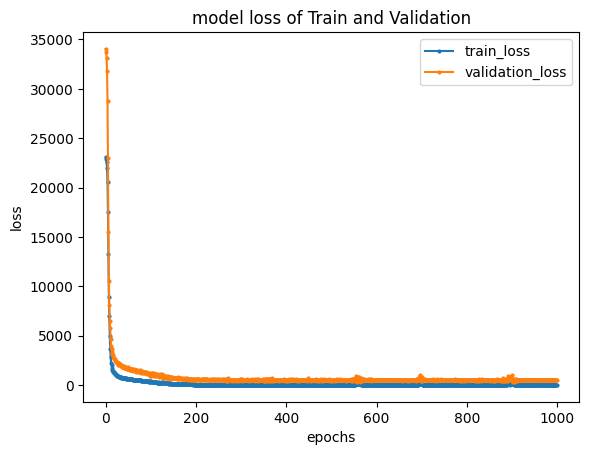

In [10]:
plt.title('model loss of Train and Validation')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(hist.history['loss'], marker = 'o', ms = 2, label='train_loss')
plt.plot(hist.history['val_loss'], marker = 'o', ms = 2, label='validation_loss')
plt.legend()

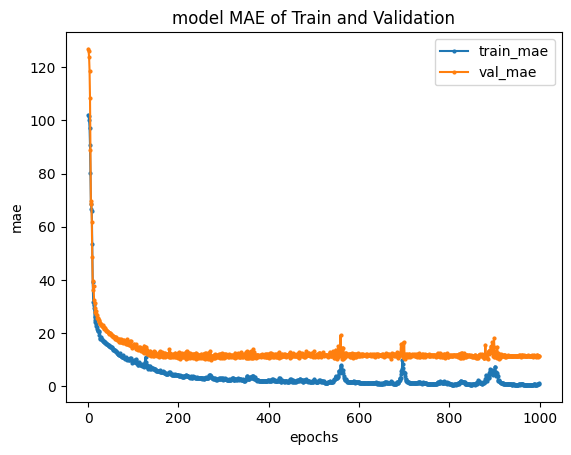

In [11]:
plt.title('model MAE of Train and Validation')
plt.xlabel('epochs')
plt.ylabel('mae')
plt.plot(hist.history['mae'], marker = 'o', ms = 2, label='train_mae')
plt.plot(hist.history['val_mae'], marker = 'o', ms = 2, label='val_mae')
plt.legend()

In [12]:
preds = model.predict(X_val, batch_size=128)
print('예측값 : ', preds[0])
print('정답 : ', Y_val[0])

1/1 [==============================] - 0s 145ms/step
예측값 :  [162.84047]
정답 :  tf.Tensor(171, shape=(), dtype=int64)


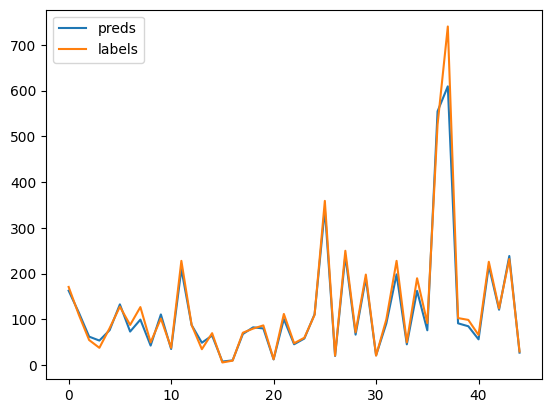

In [13]:
x_axis = [i for i in range(len(preds))]
plt.plot(x_axis,preds,label='preds')
plt.plot(x_axis,Y_val,label='labels')
plt.legend()

In [14]:
from sklearn.metrics import r2_score
r2 = r2_score(Y_val, preds)
print(r2)

0.9712209833710711


### 1.3 EarlyStopping 적용

Early stopping을 걸어주어 설정한 epoch동안 모델이 개선되지 않을시 학습을 조기 종료합니다.

In [15]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [16]:
model2 = tf.keras.Sequential()

################# 자유롭게 MLP 모델을 구현합니다.
model2.add(tf.keras.Input(shape = 3))
model2.add(Dense(100))
model2.add(Activation('relu'))
model2.add(Dense(200))
model2.add(Activation('relu'))
model2.add(Dense(300))
model2.add(Activation('relu'))
model2.add(Dense(200))
model2.add(Activation('relu'))
model2.add(Dense(100))
model2.add(Activation('relu'))
model2.add(Dense(1))

In [17]:
learning_rate = 5e-4
optimizer = tf.keras.optimizers.Adam(lr = learning_rate)
loss = MeanSquaredError()
epochs = 1000
batch_size=32

/home/elicer/.local/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [18]:
model2.compile(loss=loss, optimizer=optimizer, metrics=['mse', 'mae'])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 100)               400       
                                                                 
 activation_5 (Activation)   (None, 100)               0         
                                                                 
 dense_7 (Dense)             (None, 200)               20200     
                                                                 
 activation_6 (Activation)   (None, 200)               0         
                                                                 
 dense_8 (Dense)             (None, 300)               60300     
                                                                 
 activation_7 (Activation)   (None, 300)               0         
                                                                 
 dense_9 (Dense)             (None, 200)              

In [19]:
# Early stopping : 성능 개선이 없으면 종료
earlystopping = EarlyStopping(monitor='val_loss',  # 모니터 기준 설정 (val loss) 
                patience=10,                       # 10회 Epoch동안 개선되지 않는다면 종료
                )

In [20]:
# 체크포인트: 중간에 모델을 저장하고 싶을 때 저장하는 기능
ckpt_name = 'checkpoint-epoch-{}-batch-{}-trial-001.h5'.format(epochs, batch_size)
checkpoint = ModelCheckpoint(ckpt_name,             # file명을 지정합니다
                            monitor='val_loss',     # val_loss 값이 개선되었을때 호출됩니다
                            verbose=1,              # 로그를 출력합니다
                            save_best_only=True,    # 가장 best 값만 저장합니다
                            )

In [21]:
model2.compile(loss=loss, optimizer=optimizer, metrics=['mse', 'mae'])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 100)               400       
                                                                 
 activation_5 (Activation)   (None, 100)               0         
                                                                 
 dense_7 (Dense)             (None, 200)               20200     
                                                                 
 activation_6 (Activation)   (None, 200)               0         
                                                                 
 dense_8 (Dense)             (None, 300)               60300     
                                                                 
 activation_7 (Activation)   (None, 300)               0         
                                                                 
 dense_9 (Dense)             (None, 200)              

In [22]:
# callbacks=[checkpoint,earlystopping] 추가
hist2 = model2.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, validation_data =(X_val, Y_val), callbacks=[checkpoint, earlystopping])

Epoch 1/1000
1/6 [====>.........................] - ETA: 2s - loss: 20495.3477 - mse: 20495.3477 - mae: 93.5654
Epoch 1: val_loss improved from inf to 34027.22266, saving model to checkpoint-epoch-1000-batch-32-trial-001.h5
6/6 [==============================] - 1s 55ms/step - loss: 23043.7285 - mse: 23043.7285 - mae: 102.0430 - val_loss: 34027.2227 - val_mse: 34027.2227 - val_mae: 126.8121
Epoch 2/1000
1/6 [====>.........................] - ETA: 0s - loss: 15284.4463 - mse: 15284.4463 - mae: 87.6809
Epoch 2: val_loss improved from 34027.22266 to 33708.11328, saving model to checkpoint-epoch-1000-batch-32-trial-001.h5
6/6 [==============================] - 0s 18ms/step - loss: 22874.4824 - mse: 22874.4824 - mae: 101.2730 - val_loss: 33708.1133 - val_mse: 33708.1133 - val_mae: 125.6326
Epoch 3/1000
1/6 [====>.........................] - ETA: 0s - loss: 22057.8008 - mse: 22057.8008 - mae: 96.8879
Epoch 3: val_loss improved from 33708.11328 to 32977.06250, saving model to checkpoint-epoch

1/6 [====>.........................] - ETA: 0s - loss: 660.5071 - mse: 660.5071 - mae: 16.7955
Epoch 22: val_loss improved from 2320.83154 to 2319.48462, saving model to checkpoint-epoch-1000-batch-32-trial-001.h5
6/6 [==============================] - 0s 17ms/step - loss: 1094.6311 - mse: 1094.6311 - mae: 22.0286 - val_loss: 2319.4846 - val_mse: 2319.4846 - val_mae: 25.2228
Epoch 23/1000
1/6 [====>.........................] - ETA: 0s - loss: 915.8230 - mse: 915.8230 - mae: 22.4222
Epoch 23: val_loss did not improve from 2319.48462
6/6 [==============================] - 0s 10ms/step - loss: 1034.7747 - mse: 1034.7747 - mae: 19.9682 - val_loss: 2485.5259 - val_mse: 2485.5259 - val_mae: 23.7695
Epoch 24/1000
1/6 [====>.........................] - ETA: 0s - loss: 1649.5785 - mse: 1649.5785 - mae: 21.3337
Epoch 24: val_loss did not improve from 2319.48462
6/6 [==============================] - 0s 9ms/step - loss: 1000.6251 - mse: 1000.6251 - mae: 19.1070 - val_loss: 2368.7173 - val_mse: 23

1/6 [====>.........................] - ETA: 0s - loss: 462.1071 - mse: 462.1071 - mae: 15.2890
Epoch 46: val_loss did not improve from 1636.52295
6/6 [==============================] - 0s 9ms/step - loss: 671.2571 - mse: 671.2571 - mae: 15.5592 - val_loss: 1713.4725 - val_mse: 1713.4725 - val_mae: 19.5201
Epoch 47/1000
1/6 [====>.........................] - ETA: 0s - loss: 471.9550 - mse: 471.9550 - mae: 14.5194
Epoch 47: val_loss did not improve from 1636.52295
6/6 [==============================] - 0s 9ms/step - loss: 686.3755 - mse: 686.3755 - mae: 15.4902 - val_loss: 1746.8610 - val_mse: 1746.8610 - val_mae: 19.4902
Epoch 48/1000
1/6 [====>.........................] - ETA: 0s - loss: 344.6705 - mse: 344.6705 - mae: 12.2777
Epoch 48: val_loss improved from 1636.52295 to 1490.26733, saving model to checkpoint-epoch-1000-batch-32-trial-001.h5
6/6 [==============================] - 0s 17ms/step - loss: 721.4088 - mse: 721.4088 - mae: 16.1488 - val_loss: 1490.2673 - val_mse: 1490.2673 -

6/6 [==============================] - 0s 16ms/step - loss: 494.8518 - mse: 494.8518 - mae: 12.2456 - val_loss: 1329.5106 - val_mse: 1329.5106 - val_mae: 16.0832
Epoch 71/1000
1/6 [====>.........................] - ETA: 0s - loss: 133.9000 - mse: 133.9000 - mae: 8.1225
Epoch 71: val_loss did not improve from 1329.51062
6/6 [==============================] - 0s 11ms/step - loss: 492.9708 - mse: 492.9708 - mae: 11.7095 - val_loss: 1410.8907 - val_mse: 1410.8907 - val_mae: 16.8661
Epoch 72/1000
1/6 [====>.........................] - ETA: 0s - loss: 959.2388 - mse: 959.2388 - mae: 17.2709
Epoch 72: val_loss did not improve from 1329.51062
6/6 [==============================] - 0s 9ms/step - loss: 486.6683 - mse: 486.6683 - mae: 11.8036 - val_loss: 1414.2947 - val_mse: 1414.2947 - val_mae: 16.2772
Epoch 73/1000
1/6 [====>.........................] - ETA: 0s - loss: 657.9038 - mse: 657.9038 - mae: 12.5700
Epoch 73: val_loss improved from 1329.51062 to 1243.30188, saving model to checkpoint-e

Epoch 95/1000
1/6 [====>.........................] - ETA: 0s - loss: 87.4559 - mse: 87.4559 - mae: 6.6965
Epoch 95: val_loss improved from 1113.87671 to 1003.12024, saving model to checkpoint-epoch-1000-batch-32-trial-001.h5
6/6 [==============================] - 0s 17ms/step - loss: 343.8885 - mse: 343.8885 - mae: 9.1959 - val_loss: 1003.1202 - val_mse: 1003.1202 - val_mae: 13.6505
Epoch 96/1000
1/6 [====>.........................] - ETA: 0s - loss: 615.1545 - mse: 615.1545 - mae: 10.9736
Epoch 96: val_loss did not improve from 1003.12024
6/6 [==============================] - 0s 11ms/step - loss: 349.7524 - mse: 349.7524 - mae: 9.3868 - val_loss: 1128.3928 - val_mse: 1128.3928 - val_mae: 14.0687
Epoch 97/1000
1/6 [====>.........................] - ETA: 0s - loss: 504.3402 - mse: 504.3402 - mae: 13.5327
Epoch 97: val_loss improved from 1003.12024 to 968.36798, saving model to checkpoint-epoch-1000-batch-32-trial-001.h5
6/6 [==============================] - 0s 43ms/step - loss: 323.83

In [23]:
model2.load_weights(ckpt_name)
preds = model2.predict(X_val, batch_size=128)
print('예측값 : ', preds[0])
print('정답 : ', Y_val[0])

1/1 [==============================] - 0s 88ms/step
예측값 :  [154.712]
정답 :  tf.Tensor(171, shape=(), dtype=int64)


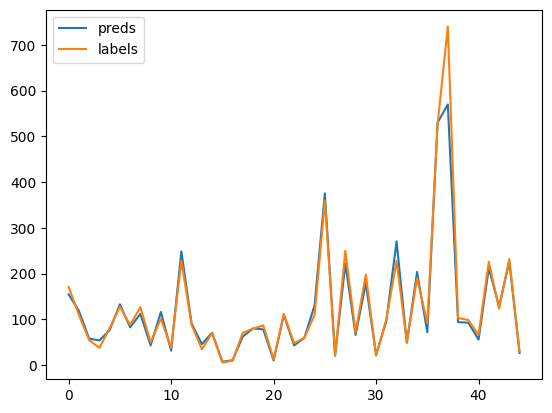

In [24]:
x_axis = [i for i in range(len(preds))]
plt.plot(x_axis,preds,label='preds')
plt.plot(x_axis,Y_val,label='labels')
plt.legend()

회귀 모델의 성능 평가를 위해 r2 score를 확인합니다.

In [25]:
from sklearn.metrics import r2_score
r2 = r2_score(Y_val, preds)
print(r2)

0.9557528534403033


성능이 더 나빠진 것을 확인할 수 있습니다. Patience가 너무 낮아서, 학습이 충분히 되기 전에 종료 된 것 같습니다.\
Patience를 바꿔서 다시 실험해 보겠습니다.

In [26]:
#model2와 동일
model3 = tf.keras.Sequential()

################# 자유롭게 MLP 모델을 구현합니다.
model3.add(tf.keras.Input(shape = 3))
model3.add(Dense(100))
model3.add(Activation('relu'))
model3.add(Dense(200))
model3.add(Activation('relu'))
model3.add(Dense(300))
model3.add(Activation('relu'))
model3.add(Dense(200))
model3.add(Activation('relu'))
model3.add(Dense(100))
model3.add(Activation('relu'))
model3.add(Dense(1))

learning_rate = 5e-4
optimizer = tf.keras.optimizers.Adam(lr = learning_rate)
loss = MeanSquaredError()
epochs = 1000
batch_size=32
# Early stopping : 성능 개선이 없으면 종료
earlystopping = EarlyStopping(monitor='val_loss',  # 모니터 기준 설정 (val loss) 
                patience=100,                      # 100회 Epoch동안 개선되지 않는다면 종료
                )
# 체크포인트: 중간에 모델을 저장하고 싶을 때 저장하는 기능

ckpt_name = 'checkpoint-epoch-{}-batch-{}-trial-001.h5'.format(epochs, batch_size)
checkpoint = ModelCheckpoint(ckpt_name,             # file명을 지정합니다
                            monitor='val_loss',     # val_loss 값이 개선되었을때 호출됩니다
                            verbose=1,              # 로그를 출력합니다
                            save_best_only=True,    # 가장 best 값만 저장합니다
                            )
model3.compile(loss=loss, optimizer=optimizer, metrics=['mse', 'mae'])
model3.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 100)               400       
                                                                 
 activation_10 (Activation)  (None, 100)               0         
                                                                 
 dense_13 (Dense)            (None, 200)               20200     
                                                                 
 activation_11 (Activation)  (None, 200)               0         
                                                                 
 dense_14 (Dense)            (None, 300)               60300     
                                                                 
 activation_12 (Activation)  (None, 300)               0         
                                                                 
 dense_15 (Dense)            (None, 200)              

/home/elicer/.local/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [27]:
hist3 = model3.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, validation_data =(X_val, Y_val), callbacks=[checkpoint, earlystopping])

Epoch 1/1000
1/6 [====>.........................] - ETA: 3s - loss: 18985.0938 - mse: 18985.0938 - mae: 85.3574
Epoch 1: val_loss improved from inf to 34012.53516, saving model to checkpoint-epoch-1000-batch-32-trial-001.h5
6/6 [==============================] - 1s 54ms/step - loss: 23030.1133 - mse: 23030.1133 - mae: 102.0162 - val_loss: 34012.5352 - val_mse: 34012.5352 - val_mae: 126.8320
Epoch 2/1000
1/6 [====>.........................] - ETA: 0s - loss: 13090.1768 - mse: 13090.1768 - mae: 90.4291
Epoch 2: val_loss improved from 34012.53516 to 33687.69922, saving model to checkpoint-epoch-1000-batch-32-trial-001.h5
6/6 [==============================] - 0s 18ms/step - loss: 22874.4727 - mse: 22874.4727 - mae: 101.3421 - val_loss: 33687.6992 - val_mse: 33687.6992 - val_mae: 125.7770
Epoch 3/1000
1/6 [====>.........................] - ETA: 0s - loss: 20428.3730 - mse: 20428.3730 - mae: 101.2233
Epoch 3: val_loss improved from 33687.69922 to 32907.05078, saving model to checkpoint-epoc

1/6 [====>.........................] - ETA: 0s - loss: 2360.7793 - mse: 2360.7793 - mae: 27.3492
Epoch 22: val_loss improved from 2494.06152 to 2348.40894, saving model to checkpoint-epoch-1000-batch-32-trial-001.h5
6/6 [==============================] - 0s 16ms/step - loss: 1226.0514 - mse: 1226.0514 - mae: 22.9171 - val_loss: 2348.4089 - val_mse: 2348.4089 - val_mae: 27.9002
Epoch 23/1000
1/6 [====>.........................] - ETA: 0s - loss: 1599.3701 - mse: 1599.3701 - mae: 30.4190
Epoch 23: val_loss did not improve from 2348.40894
6/6 [==============================] - 0s 10ms/step - loss: 1104.2113 - mse: 1104.2113 - mae: 22.1001 - val_loss: 2433.0112 - val_mse: 2433.0112 - val_mae: 25.4044
Epoch 24/1000
1/6 [====>.........................] - ETA: 0s - loss: 379.4289 - mse: 379.4289 - mae: 12.7353
Epoch 24: val_loss did not improve from 2348.40894
6/6 [==============================] - 0s 9ms/step - loss: 1101.1060 - mse: 1101.1060 - mae: 20.7445 - val_loss: 2459.9246 - val_mse: 

1/6 [====>.........................] - ETA: 0s - loss: 259.4907 - mse: 259.4907 - mae: 11.6789
Epoch 45: val_loss improved from 1769.69189 to 1569.59009, saving model to checkpoint-epoch-1000-batch-32-trial-001.h5
6/6 [==============================] - 0s 17ms/step - loss: 704.5167 - mse: 704.5167 - mae: 16.1743 - val_loss: 1569.5901 - val_mse: 1569.5901 - val_mae: 19.8492
Epoch 46/1000
1/6 [====>.........................] - ETA: 0s - loss: 683.9653 - mse: 683.9653 - mae: 16.3832
Epoch 46: val_loss did not improve from 1569.59009
6/6 [==============================] - 0s 10ms/step - loss: 686.8894 - mse: 686.8894 - mae: 15.7918 - val_loss: 1665.4058 - val_mse: 1665.4058 - val_mae: 19.4738
Epoch 47/1000
1/6 [====>.........................] - ETA: 0s - loss: 1001.2663 - mse: 1001.2663 - mae: 15.9375
Epoch 47: val_loss did not improve from 1569.59009
6/6 [==============================] - 0s 9ms/step - loss: 691.4296 - mse: 691.4296 - mae: 15.5302 - val_loss: 1693.7297 - val_mse: 1693.729

6/6 [==============================] - 0s 9ms/step - loss: 510.8330 - mse: 510.8330 - mae: 11.7749 - val_loss: 1310.7866 - val_mse: 1310.7866 - val_mae: 15.9623
Epoch 70/1000
1/6 [====>.........................] - ETA: 0s - loss: 304.4734 - mse: 304.4734 - mae: 8.9513
Epoch 70: val_loss did not improve from 1308.15808
6/6 [==============================] - 0s 9ms/step - loss: 526.7774 - mse: 526.7774 - mae: 11.4444 - val_loss: 1525.0016 - val_mse: 1525.0016 - val_mae: 16.6035
Epoch 71/1000
1/6 [====>.........................] - ETA: 0s - loss: 243.8982 - mse: 243.8982 - mae: 7.9101
Epoch 71: val_loss did not improve from 1308.15808
6/6 [==============================] - 0s 9ms/step - loss: 491.1684 - mse: 491.1684 - mae: 11.7237 - val_loss: 1321.1995 - val_mse: 1321.1995 - val_mae: 15.8007
Epoch 72/1000
1/6 [====>.........................] - ETA: 0s - loss: 183.4498 - mse: 183.4498 - mae: 8.5447
Epoch 72: val_loss did not improve from 1308.15808
6/6 [==============================] - 0

6/6 [==============================] - 0s 9ms/step - loss: 372.5665 - mse: 372.5665 - mae: 9.7697 - val_loss: 1074.8452 - val_mse: 1074.8452 - val_mae: 14.5780
Epoch 95/1000
1/6 [====>.........................] - ETA: 0s - loss: 186.6282 - mse: 186.6282 - mae: 8.8305
Epoch 95: val_loss did not improve from 1073.43054
6/6 [==============================] - 0s 9ms/step - loss: 365.4764 - mse: 365.4764 - mae: 9.5728 - val_loss: 1248.8547 - val_mse: 1248.8547 - val_mae: 15.9315
Epoch 96/1000
1/6 [====>.........................] - ETA: 0s - loss: 97.5016 - mse: 97.5016 - mae: 6.4531
Epoch 96: val_loss did not improve from 1073.43054
6/6 [==============================] - 0s 9ms/step - loss: 359.0335 - mse: 359.0335 - mae: 9.8058 - val_loss: 1124.2285 - val_mse: 1124.2285 - val_mae: 14.5030
Epoch 97/1000
1/6 [====>.........................] - ETA: 0s - loss: 370.1589 - mse: 370.1589 - mae: 8.5689
Epoch 97: val_loss improved from 1073.43054 to 1066.32019, saving model to checkpoint-epoch-1000

1/6 [====>.........................] - ETA: 0s - loss: 356.4194 - mse: 356.4194 - mae: 13.4199
Epoch 119: val_loss did not improve from 830.61078
6/6 [==============================] - 0s 9ms/step - loss: 261.7943 - mse: 261.7943 - mae: 8.4041 - val_loss: 969.7925 - val_mse: 969.7925 - val_mae: 14.4181
Epoch 120/1000
1/6 [====>.........................] - ETA: 0s - loss: 537.4166 - mse: 537.4166 - mae: 12.5366
Epoch 120: val_loss did not improve from 830.61078
6/6 [==============================] - 0s 9ms/step - loss: 247.5750 - mse: 247.5750 - mae: 8.7473 - val_loss: 869.0988 - val_mse: 869.0988 - val_mae: 12.6088
Epoch 121/1000
1/6 [====>.........................] - ETA: 0s - loss: 248.6272 - mse: 248.6272 - mae: 8.7864
Epoch 121: val_loss did not improve from 830.61078
6/6 [==============================] - 0s 9ms/step - loss: 229.2860 - mse: 229.2860 - mae: 8.1114 - val_loss: 983.7218 - val_mse: 983.7218 - val_mae: 13.2146
Epoch 122/1000
1/6 [====>.........................] - ETA: 

6/6 [==============================] - 0s 18ms/step - loss: 182.1971 - mse: 182.1971 - mae: 7.7093 - val_loss: 664.8962 - val_mse: 664.8962 - val_mae: 11.9093
Epoch 145/1000
1/6 [====>.........................] - ETA: 0s - loss: 75.4755 - mse: 75.4755 - mae: 5.6566
Epoch 145: val_loss did not improve from 664.89618
6/6 [==============================] - 0s 11ms/step - loss: 168.6356 - mse: 168.6356 - mae: 7.6199 - val_loss: 837.3649 - val_mse: 837.3649 - val_mae: 12.0414
Epoch 146/1000
1/6 [====>.........................] - ETA: 0s - loss: 158.4234 - mse: 158.4234 - mae: 7.1701
Epoch 146: val_loss improved from 664.89618 to 639.63025, saving model to checkpoint-epoch-1000-batch-32-trial-001.h5
6/6 [==============================] - 0s 36ms/step - loss: 162.1461 - mse: 162.1461 - mae: 8.1662 - val_loss: 639.6302 - val_mse: 639.6302 - val_mae: 10.7770
Epoch 147/1000
1/6 [====>.........................] - ETA: 0s - loss: 143.4110 - mse: 143.4110 - mae: 5.7652
Epoch 147: val_loss did not i

Epoch 170/1000
1/6 [====>.........................] - ETA: 0s - loss: 50.3678 - mse: 50.3678 - mae: 5.0399
Epoch 170: val_loss did not improve from 569.51056
6/6 [==============================] - 0s 9ms/step - loss: 76.4032 - mse: 76.4032 - mae: 5.4262 - val_loss: 620.0561 - val_mse: 620.0561 - val_mae: 10.6944
Epoch 171/1000
1/6 [====>.........................] - ETA: 0s - loss: 82.4930 - mse: 82.4930 - mae: 5.2704
Epoch 171: val_loss did not improve from 569.51056
6/6 [==============================] - 0s 9ms/step - loss: 96.0607 - mse: 96.0607 - mae: 6.0018 - val_loss: 613.5937 - val_mse: 613.5937 - val_mae: 11.7436
Epoch 172/1000
1/6 [====>.........................] - ETA: 0s - loss: 32.9531 - mse: 32.9531 - mae: 3.9979
Epoch 172: val_loss did not improve from 569.51056
6/6 [==============================] - 0s 9ms/step - loss: 80.5040 - mse: 80.5040 - mae: 5.5432 - val_loss: 693.9489 - val_mse: 693.9489 - val_mae: 11.5185
Epoch 173/1000
1/6 [====>.........................] - ETA:

1/6 [====>.........................] - ETA: 0s - loss: 24.8265 - mse: 24.8265 - mae: 3.7106
Epoch 195: val_loss did not improve from 463.30121
6/6 [==============================] - 0s 11ms/step - loss: 45.4923 - mse: 45.4923 - mae: 4.2073 - val_loss: 575.1966 - val_mse: 575.1966 - val_mae: 11.2288
Epoch 196/1000
1/6 [====>.........................] - ETA: 0s - loss: 52.1348 - mse: 52.1348 - mae: 3.7892
Epoch 196: val_loss did not improve from 463.30121
6/6 [==============================] - 0s 10ms/step - loss: 42.0433 - mse: 42.0433 - mae: 4.0569 - val_loss: 532.7292 - val_mse: 532.7292 - val_mae: 10.5458
Epoch 197/1000
1/6 [====>.........................] - ETA: 0s - loss: 42.9120 - mse: 42.9120 - mae: 4.1887
Epoch 197: val_loss did not improve from 463.30121
6/6 [==============================] - 0s 10ms/step - loss: 40.7314 - mse: 40.7314 - mae: 4.0732 - val_loss: 528.3069 - val_mse: 528.3069 - val_mae: 10.6281
Epoch 198/1000
1/6 [====>.........................] - ETA: 0s - loss: 

Epoch 221/1000
1/6 [====>.........................] - ETA: 0s - loss: 10.1571 - mse: 10.1571 - mae: 2.0335
Epoch 221: val_loss did not improve from 425.63013
6/6 [==============================] - 0s 10ms/step - loss: 27.6173 - mse: 27.6173 - mae: 3.3820 - val_loss: 466.5221 - val_mse: 466.5221 - val_mae: 10.7589
Epoch 222/1000
1/6 [====>.........................] - ETA: 0s - loss: 46.3531 - mse: 46.3531 - mae: 3.7963
Epoch 222: val_loss did not improve from 425.63013
6/6 [==============================] - 0s 9ms/step - loss: 26.8979 - mse: 26.8979 - mae: 3.3701 - val_loss: 451.2670 - val_mse: 451.2670 - val_mae: 10.5803
Epoch 223/1000
1/6 [====>.........................] - ETA: 0s - loss: 15.0951 - mse: 15.0951 - mae: 3.1811
Epoch 223: val_loss did not improve from 425.63013
6/6 [==============================] - 0s 9ms/step - loss: 29.3197 - mse: 29.3197 - mae: 3.4996 - val_loss: 455.8804 - val_mse: 455.8804 - val_mae: 11.1299
Epoch 224/1000
1/6 [====>.........................] - ETA

Epoch 247/1000
1/6 [====>.........................] - ETA: 0s - loss: 13.6966 - mse: 13.6966 - mae: 2.9365
Epoch 247: val_loss did not improve from 385.92178
6/6 [==============================] - 0s 10ms/step - loss: 33.0698 - mse: 33.0698 - mae: 3.9577 - val_loss: 389.6216 - val_mse: 389.6216 - val_mae: 10.6068
Epoch 248/1000
1/6 [====>.........................] - ETA: 0s - loss: 17.1536 - mse: 17.1536 - mae: 3.3770
Epoch 248: val_loss did not improve from 385.92178
6/6 [==============================] - 0s 9ms/step - loss: 29.5960 - mse: 29.5960 - mae: 3.7594 - val_loss: 517.6884 - val_mse: 517.6884 - val_mae: 13.4625
Epoch 249/1000
1/6 [====>.........................] - ETA: 0s - loss: 29.2779 - mse: 29.2779 - mae: 4.4155
Epoch 249: val_loss did not improve from 385.92178
6/6 [==============================] - 0s 10ms/step - loss: 34.8822 - mse: 34.8822 - mae: 4.4592 - val_loss: 402.7457 - val_mse: 402.7457 - val_mae: 10.3556
Epoch 250/1000
1/6 [====>.........................] - ET

Epoch 273/1000
1/6 [====>.........................] - ETA: 0s - loss: 12.1762 - mse: 12.1762 - mae: 2.3333
Epoch 273: val_loss did not improve from 375.93192
6/6 [==============================] - 0s 10ms/step - loss: 14.8531 - mse: 14.8531 - mae: 2.4864 - val_loss: 426.7635 - val_mse: 426.7636 - val_mae: 11.5661
Epoch 274/1000
1/6 [====>.........................] - ETA: 0s - loss: 16.8698 - mse: 16.8698 - mae: 2.6927
Epoch 274: val_loss improved from 375.93192 to 363.86652, saving model to checkpoint-epoch-1000-batch-32-trial-001.h5
6/6 [==============================] - 0s 17ms/step - loss: 16.4209 - mse: 16.4209 - mae: 2.6890 - val_loss: 363.8665 - val_mse: 363.8665 - val_mae: 10.4297
Epoch 275/1000
1/6 [====>.........................] - ETA: 0s - loss: 13.1555 - mse: 13.1555 - mae: 2.4243
Epoch 275: val_loss did not improve from 363.86652
6/6 [==============================] - 0s 10ms/step - loss: 22.1477 - mse: 22.1477 - mae: 3.0758 - val_loss: 452.2062 - val_mse: 452.2062 - val_m

1/6 [====>.........................] - ETA: 0s - loss: 10.5390 - mse: 10.5390 - mae: 2.3218
Epoch 298: val_loss did not improve from 335.97955
6/6 [==============================] - 0s 11ms/step - loss: 22.6754 - mse: 22.6754 - mae: 3.2690 - val_loss: 413.5761 - val_mse: 413.5761 - val_mae: 10.8934
Epoch 299/1000
1/6 [====>.........................] - ETA: 0s - loss: 17.5346 - mse: 17.5346 - mae: 2.5484
Epoch 299: val_loss did not improve from 335.97955
6/6 [==============================] - 0s 10ms/step - loss: 16.8763 - mse: 16.8763 - mae: 2.9706 - val_loss: 384.8170 - val_mse: 384.8170 - val_mae: 10.9911
Epoch 300/1000
1/6 [====>.........................] - ETA: 0s - loss: 6.2512 - mse: 6.2512 - mae: 1.8436
Epoch 300: val_loss did not improve from 335.97955
6/6 [==============================] - 0s 10ms/step - loss: 15.9369 - mse: 15.9369 - mae: 2.9278 - val_loss: 366.7451 - val_mse: 366.7451 - val_mae: 10.3556
Epoch 301/1000
1/6 [====>.........................] - ETA: 0s - loss: 24

1/6 [====>.........................] - ETA: 0s - loss: 8.3778 - mse: 8.3778 - mae: 2.0172
Epoch 324: val_loss did not improve from 335.97955
6/6 [==============================] - 0s 9ms/step - loss: 11.1251 - mse: 11.1251 - mae: 2.2124 - val_loss: 435.1536 - val_mse: 435.1536 - val_mae: 11.6136
Epoch 325/1000
1/6 [====>.........................] - ETA: 0s - loss: 4.4002 - mse: 4.4002 - mae: 1.4089
Epoch 325: val_loss did not improve from 335.97955
6/6 [==============================] - 0s 9ms/step - loss: 12.6176 - mse: 12.6176 - mae: 2.4433 - val_loss: 373.1972 - val_mse: 373.1972 - val_mae: 10.5234
Epoch 326/1000
1/6 [====>.........................] - ETA: 0s - loss: 11.8067 - mse: 11.8067 - mae: 2.4259
Epoch 326: val_loss did not improve from 335.97955
6/6 [==============================] - 0s 9ms/step - loss: 11.8628 - mse: 11.8628 - mae: 2.2818 - val_loss: 351.7244 - val_mse: 351.7244 - val_mae: 10.2783
Epoch 327/1000
1/6 [====>.........................] - ETA: 0s - loss: 19.3807

1/6 [====>.........................] - ETA: 0s - loss: 4.5442 - mse: 4.5442 - mae: 1.4215
Epoch 350: val_loss did not improve from 320.79675
6/6 [==============================] - 0s 10ms/step - loss: 8.5075 - mse: 8.5075 - mae: 2.0301 - val_loss: 348.7394 - val_mse: 348.7394 - val_mae: 10.3712
Epoch 351/1000
1/6 [====>.........................] - ETA: 0s - loss: 10.9049 - mse: 10.9049 - mae: 2.3393
Epoch 351: val_loss did not improve from 320.79675
6/6 [==============================] - 0s 9ms/step - loss: 10.0818 - mse: 10.0818 - mae: 2.1503 - val_loss: 367.8546 - val_mse: 367.8546 - val_mae: 10.8018
Epoch 352/1000
1/6 [====>.........................] - ETA: 0s - loss: 9.3338 - mse: 9.3338 - mae: 1.9463
Epoch 352: val_loss did not improve from 320.79675
6/6 [==============================] - 0s 10ms/step - loss: 8.7121 - mse: 8.7121 - mae: 1.8895 - val_loss: 401.7550 - val_mse: 401.7550 - val_mae: 11.0270
Epoch 353/1000
1/6 [====>.........................] - ETA: 0s - loss: 11.0476 -

1/6 [====>.........................] - ETA: 0s - loss: 9.9689 - mse: 9.9689 - mae: 2.2132
Epoch 376: val_loss did not improve from 313.06064
6/6 [==============================] - 0s 8ms/step - loss: 11.2896 - mse: 11.2896 - mae: 2.2749 - val_loss: 386.3700 - val_mse: 386.3700 - val_mae: 11.2024
Epoch 377/1000
1/6 [====>.........................] - ETA: 0s - loss: 6.8320 - mse: 6.8320 - mae: 1.9907
Epoch 377: val_loss did not improve from 313.06064
6/6 [==============================] - 0s 8ms/step - loss: 7.3353 - mse: 7.3353 - mae: 2.0716 - val_loss: 327.8246 - val_mse: 327.8246 - val_mae: 10.2979
Epoch 378/1000
1/6 [====>.........................] - ETA: 0s - loss: 12.0395 - mse: 12.0395 - mae: 2.0736
Epoch 378: val_loss did not improve from 313.06064
6/6 [==============================] - 0s 8ms/step - loss: 6.6347 - mse: 6.6347 - mae: 1.7587 - val_loss: 352.4898 - val_mse: 352.4898 - val_mae: 10.6026
Epoch 379/1000
1/6 [====>.........................] - ETA: 0s - loss: 4.5384 - ms

6/6 [==============================] - 0s 9ms/step - loss: 6.6036 - mse: 6.6036 - mae: 1.7153 - val_loss: 350.7351 - val_mse: 350.7351 - val_mae: 10.5389
Epoch 403/1000
1/6 [====>.........................] - ETA: 0s - loss: 4.2937 - mse: 4.2937 - mae: 1.5272
Epoch 403: val_loss did not improve from 313.06064
6/6 [==============================] - 0s 10ms/step - loss: 6.0930 - mse: 6.0930 - mae: 1.6594 - val_loss: 350.7464 - val_mse: 350.7464 - val_mae: 10.6313
Epoch 404/1000
1/6 [====>.........................] - ETA: 0s - loss: 4.9444 - mse: 4.9444 - mae: 1.2330
Epoch 404: val_loss did not improve from 313.06064
6/6 [==============================] - 0s 10ms/step - loss: 4.8801 - mse: 4.8801 - mae: 1.4372 - val_loss: 386.8202 - val_mse: 386.8202 - val_mae: 10.9972
Epoch 405/1000
1/6 [====>.........................] - ETA: 0s - loss: 4.4285 - mse: 4.4285 - mae: 1.4705
Epoch 405: val_loss did not improve from 313.06064
6/6 [==============================] - 0s 9ms/step - loss: 6.4166 - 

Epoch 429/1000
1/6 [====>.........................] - ETA: 0s - loss: 1.4786 - mse: 1.4786 - mae: 0.8869
Epoch 429: val_loss did not improve from 313.06064
6/6 [==============================] - 0s 8ms/step - loss: 4.2273 - mse: 4.2273 - mae: 1.3222 - val_loss: 335.3195 - val_mse: 335.3195 - val_mae: 10.3207
Epoch 430/1000
1/6 [====>.........................] - ETA: 0s - loss: 6.4306 - mse: 6.4306 - mae: 1.8572
Epoch 430: val_loss did not improve from 313.06064
6/6 [==============================] - 0s 9ms/step - loss: 4.7510 - mse: 4.7510 - mae: 1.5450 - val_loss: 396.0068 - val_mse: 396.0068 - val_mae: 11.7398
Epoch 431/1000
1/6 [====>.........................] - ETA: 0s - loss: 5.1274 - mse: 5.1274 - mae: 1.9716
Epoch 431: val_loss did not improve from 313.06064
6/6 [==============================] - 0s 9ms/step - loss: 5.7795 - mse: 5.7795 - mae: 1.7792 - val_loss: 360.3118 - val_mse: 360.3118 - val_mae: 10.7023
Epoch 432/1000
1/6 [====>.........................] - ETA: 0s - loss: 

6/6 [==============================] - 0s 10ms/step - loss: 3.5289 - mse: 3.5289 - mae: 1.3060 - val_loss: 330.3181 - val_mse: 330.3181 - val_mae: 10.3551
Epoch 456/1000
1/6 [====>.........................] - ETA: 0s - loss: 2.9546 - mse: 2.9546 - mae: 1.2191
Epoch 456: val_loss did not improve from 313.06064
6/6 [==============================] - 0s 9ms/step - loss: 5.5158 - mse: 5.5158 - mae: 1.6037 - val_loss: 341.9641 - val_mse: 341.9641 - val_mae: 10.2951
Epoch 457/1000
1/6 [====>.........................] - ETA: 0s - loss: 4.6699 - mse: 4.6699 - mae: 1.7556
Epoch 457: val_loss did not improve from 313.06064
6/6 [==============================] - 0s 10ms/step - loss: 5.4439 - mse: 5.4439 - mae: 1.7048 - val_loss: 367.7351 - val_mse: 367.7351 - val_mae: 11.7413
Epoch 458/1000
1/6 [====>.........................] - ETA: 0s - loss: 4.6679 - mse: 4.6679 - mae: 1.4703
Epoch 458: val_loss did not improve from 313.06064
6/6 [==============================] - 0s 9ms/step - loss: 5.5222 - 

In [28]:
model3.load_weights(ckpt_name)

preds = model3.predict(X_val, batch_size=128)
print('예측값 : ', preds[0])
print('정답 : ', Y_val[0])

1/1 [==============================] - 0s 89ms/step
예측값 :  [158.73125]
정답 :  tf.Tensor(171, shape=(), dtype=int64)


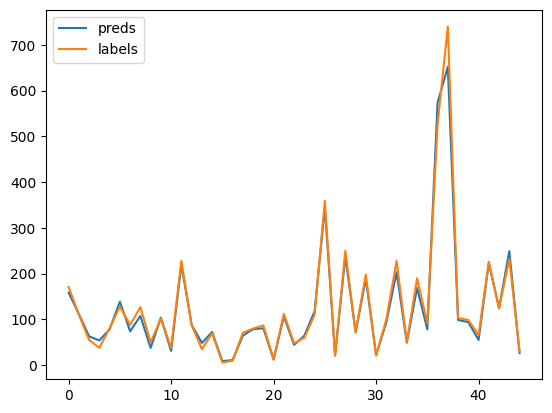

In [29]:
x_axis = [i for i in range(len(preds))]
plt.plot(x_axis,preds,label='preds')
plt.plot(x_axis,Y_val,label='labels')
plt.legend()

In [30]:
from sklearn.metrics import r2_score
r2 = r2_score(Y_val, preds)
print(r2)

0.9825695427189226


model3.load_weights(ckpt_name)을 통해 가장 학습이 잘 된 상태의 모델을 불러와 향상된 R2 값을 얻을 수 있습니다.

### 1.4 Dropout 적용

Dropout을 적용해 모델의 오버피팅을 완화합니다.

In [31]:
model4 = tf.keras.Sequential()

dropout_layer = tf.keras.layers.Dropout(0.1, input_shape=(2,)) # 0.2는 dropout이 걸릴 확률

model4.add(tf.keras.Input(shape = 3))
model4.add(Dense(100))
model4.add(Activation('relu'))
model4.add(dropout_layer)
model4.add(Dense(200))
model4.add(Activation('relu'))
model4.add(dropout_layer)
model4.add(Dense(300))
model4.add(Activation('relu'))
model4.add(dropout_layer)
model4.add(Dense(200))
model4.add(Activation('relu'))
model4.add(dropout_layer)
model4.add(Dense(100))
model4.add(Activation('relu'))
model4.add(Dense(1))

In [32]:
model4.compile(loss=loss, optimizer=optimizer, metrics=['mse', 'mae'])
model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 100)               400       
                                                                 
 activation_15 (Activation)  (None, 100)               0         
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
 dense_19 (Dense)            (None, 200)               20200     
                                                                 
 activation_16 (Activation)  (None, 200)               0         
                                                                 
 dense_20 (Dense)            (None, 300)               60300     
                                                                 
 activation_17 (Activation)  (None, 300)              

In [33]:
hist4 = model4.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, validation_data =(X_val, Y_val))

Epoch 1/1000
6/6 [==============================] - 1s 46ms/step - loss: 22777.7461 - mse: 22777.7461 - mae: 100.8619 - val_loss: 31290.3691 - val_mse: 31290.3691 - val_mae: 118.0773
Epoch 2/1000
6/6 [==============================] - 0s 10ms/step - loss: 14503.6016 - mse: 14503.6016 - mae: 72.8512 - val_loss: 9696.1885 - val_mse: 9696.1885 - val_mae: 73.2404
Epoch 3/1000
6/6 [==============================] - 0s 9ms/step - loss: 7351.9360 - mse: 7351.9360 - mae: 68.2338 - val_loss: 8067.3999 - val_mse: 8067.3999 - val_mae: 41.0097
Epoch 4/1000
6/6 [==============================] - 0s 10ms/step - loss: 3180.7366 - mse: 3180.7366 - mae: 29.7595 - val_loss: 3326.6450 - val_mse: 3326.6450 - val_mae: 33.6670
Epoch 5/1000
6/6 [==============================] - 0s 9ms/step - loss: 2749.9006 - mse: 2749.9006 - mae: 35.6237 - val_loss: 2878.5132 - val_mse: 2878.5132 - val_mae: 33.0265
Epoch 6/1000
6/6 [==============================] - 0s 9ms/step - loss: 1688.2661 - mse: 1688.2661 - mae: 25.

6/6 [==============================] - 0s 8ms/step - loss: 634.0850 - mse: 634.0850 - mae: 14.3987 - val_loss: 1380.3170 - val_mse: 1380.3171 - val_mae: 17.3005
Epoch 48/1000
6/6 [==============================] - 0s 8ms/step - loss: 576.3403 - mse: 576.3403 - mae: 14.4536 - val_loss: 1427.5449 - val_mse: 1427.5449 - val_mae: 17.0304
Epoch 49/1000
6/6 [==============================] - 0s 8ms/step - loss: 819.3839 - mse: 819.3838 - mae: 16.0497 - val_loss: 1510.0920 - val_mse: 1510.0920 - val_mae: 17.3032
Epoch 50/1000
6/6 [==============================] - 0s 8ms/step - loss: 562.1553 - mse: 562.1553 - mae: 13.4866 - val_loss: 1188.6331 - val_mse: 1188.6331 - val_mae: 16.2531
Epoch 51/1000
6/6 [==============================] - 0s 8ms/step - loss: 678.4852 - mse: 678.4852 - mae: 14.5365 - val_loss: 1653.2073 - val_mse: 1653.2073 - val_mae: 18.2576
Epoch 52/1000
6/6 [==============================] - 0s 8ms/step - loss: 587.1260 - mse: 587.1260 - mae: 13.8519 - val_loss: 1310.3926 - va

Epoch 94/1000
6/6 [==============================] - 0s 9ms/step - loss: 427.7151 - mse: 427.7151 - mae: 11.8621 - val_loss: 1267.0277 - val_mse: 1267.0277 - val_mae: 15.7012
Epoch 95/1000
6/6 [==============================] - 0s 9ms/step - loss: 566.9584 - mse: 566.9584 - mae: 12.7054 - val_loss: 890.2122 - val_mse: 890.2122 - val_mae: 13.7646
Epoch 96/1000
6/6 [==============================] - 0s 9ms/step - loss: 660.0261 - mse: 660.0261 - mae: 13.6051 - val_loss: 1328.4158 - val_mse: 1328.4158 - val_mae: 16.3974
Epoch 97/1000
6/6 [==============================] - 0s 9ms/step - loss: 740.3101 - mse: 740.3101 - mae: 13.9047 - val_loss: 864.5618 - val_mse: 864.5618 - val_mae: 14.1591
Epoch 98/1000
6/6 [==============================] - 0s 9ms/step - loss: 690.5539 - mse: 690.5539 - mae: 14.5386 - val_loss: 1070.2493 - val_mse: 1070.2493 - val_mae: 15.6151
Epoch 99/1000
6/6 [==============================] - 0s 9ms/step - loss: 749.6703 - mse: 749.6703 - mae: 15.3182 - val_loss: 1315

Epoch 141/1000
6/6 [==============================] - 0s 10ms/step - loss: 231.2881 - mse: 231.2881 - mae: 9.7794 - val_loss: 1120.6548 - val_mse: 1120.6548 - val_mae: 14.8512
Epoch 142/1000
6/6 [==============================] - 0s 10ms/step - loss: 425.3221 - mse: 425.3221 - mae: 11.8612 - val_loss: 688.3070 - val_mse: 688.3070 - val_mae: 11.9582
Epoch 143/1000
6/6 [==============================] - 0s 10ms/step - loss: 379.0567 - mse: 379.0567 - mae: 11.9686 - val_loss: 1111.2109 - val_mse: 1111.2109 - val_mae: 15.3870
Epoch 144/1000
6/6 [==============================] - 0s 10ms/step - loss: 364.2196 - mse: 364.2196 - mae: 10.8674 - val_loss: 914.5898 - val_mse: 914.5898 - val_mae: 13.9981
Epoch 145/1000
6/6 [==============================] - 0s 10ms/step - loss: 351.5112 - mse: 351.5112 - mae: 10.9031 - val_loss: 808.6713 - val_mse: 808.6713 - val_mae: 12.7414
Epoch 146/1000
6/6 [==============================] - 0s 9ms/step - loss: 314.3465 - mse: 314.3465 - mae: 10.4489 - val_lo

Epoch 188/1000
6/6 [==============================] - 0s 9ms/step - loss: 565.7833 - mse: 565.7833 - mae: 12.3366 - val_loss: 538.0101 - val_mse: 538.0101 - val_mae: 10.8873
Epoch 189/1000
6/6 [==============================] - 0s 11ms/step - loss: 251.7011 - mse: 251.7011 - mae: 9.9526 - val_loss: 613.0240 - val_mse: 613.0240 - val_mae: 11.8950
Epoch 190/1000
6/6 [==============================] - 0s 9ms/step - loss: 254.4654 - mse: 254.4654 - mae: 10.0666 - val_loss: 933.7845 - val_mse: 933.7845 - val_mae: 16.6499
Epoch 191/1000
6/6 [==============================] - 0s 9ms/step - loss: 212.1072 - mse: 212.1072 - mae: 9.3764 - val_loss: 816.9938 - val_mse: 816.9938 - val_mae: 14.4326
Epoch 192/1000
6/6 [==============================] - 0s 9ms/step - loss: 312.7793 - mse: 312.7793 - mae: 10.5583 - val_loss: 818.5045 - val_mse: 818.5045 - val_mae: 13.1597
Epoch 193/1000
6/6 [==============================] - 0s 9ms/step - loss: 370.4307 - mse: 370.4307 - mae: 10.7993 - val_loss: 856.7

6/6 [==============================] - 0s 10ms/step - loss: 197.6087 - mse: 197.6087 - mae: 9.4695 - val_loss: 537.1794 - val_mse: 537.1794 - val_mae: 11.5921
Epoch 236/1000
6/6 [==============================] - 0s 10ms/step - loss: 256.4771 - mse: 256.4771 - mae: 10.7245 - val_loss: 740.8079 - val_mse: 740.8079 - val_mae: 13.2633
Epoch 237/1000
6/6 [==============================] - 0s 9ms/step - loss: 198.4809 - mse: 198.4809 - mae: 9.2036 - val_loss: 515.3945 - val_mse: 515.3945 - val_mae: 9.9953
Epoch 238/1000
6/6 [==============================] - 0s 10ms/step - loss: 204.6924 - mse: 204.6924 - mae: 8.6939 - val_loss: 663.8591 - val_mse: 663.8591 - val_mae: 12.0681
Epoch 239/1000
6/6 [==============================] - 0s 11ms/step - loss: 206.0398 - mse: 206.0398 - mae: 9.3270 - val_loss: 619.2235 - val_mse: 619.2235 - val_mae: 11.3343
Epoch 240/1000
6/6 [==============================] - 0s 10ms/step - loss: 202.2311 - mse: 202.2311 - mae: 8.9245 - val_loss: 596.6245 - val_mse: 

6/6 [==============================] - 0s 9ms/step - loss: 317.2597 - mse: 317.2597 - mae: 9.7763 - val_loss: 465.5692 - val_mse: 465.5692 - val_mae: 11.4185
Epoch 283/1000
6/6 [==============================] - 0s 9ms/step - loss: 191.1298 - mse: 191.1298 - mae: 9.2914 - val_loss: 526.4765 - val_mse: 526.4765 - val_mae: 12.5359
Epoch 284/1000
6/6 [==============================] - 0s 9ms/step - loss: 211.5240 - mse: 211.5240 - mae: 8.3855 - val_loss: 300.6115 - val_mse: 300.6115 - val_mae: 9.4713
Epoch 285/1000
6/6 [==============================] - 0s 9ms/step - loss: 415.4281 - mse: 415.4281 - mae: 11.0028 - val_loss: 654.5676 - val_mse: 654.5676 - val_mae: 13.2771
Epoch 286/1000
6/6 [==============================] - 0s 10ms/step - loss: 273.9329 - mse: 273.9329 - mae: 9.9606 - val_loss: 818.9905 - val_mse: 818.9905 - val_mae: 13.8683
Epoch 287/1000
6/6 [==============================] - 0s 9ms/step - loss: 279.1841 - mse: 279.1841 - mae: 9.9377 - val_loss: 442.9497 - val_mse: 442.

6/6 [==============================] - 0s 10ms/step - loss: 221.2226 - mse: 221.2226 - mae: 8.6834 - val_loss: 690.8727 - val_mse: 690.8727 - val_mae: 13.1362
Epoch 330/1000
6/6 [==============================] - 0s 9ms/step - loss: 226.5574 - mse: 226.5574 - mae: 8.5213 - val_loss: 543.5620 - val_mse: 543.5620 - val_mae: 11.6246
Epoch 331/1000
6/6 [==============================] - 0s 10ms/step - loss: 145.7606 - mse: 145.7606 - mae: 7.2510 - val_loss: 407.4253 - val_mse: 407.4253 - val_mae: 10.1597
Epoch 332/1000
6/6 [==============================] - 0s 9ms/step - loss: 291.2202 - mse: 291.2202 - mae: 9.3147 - val_loss: 608.6429 - val_mse: 608.6429 - val_mae: 12.5938
Epoch 333/1000
6/6 [==============================] - 0s 9ms/step - loss: 164.7229 - mse: 164.7229 - mae: 8.3010 - val_loss: 485.8614 - val_mse: 485.8614 - val_mae: 11.4880
Epoch 334/1000
6/6 [==============================] - 0s 10ms/step - loss: 243.6268 - mse: 243.6268 - mae: 9.3468 - val_loss: 512.4607 - val_mse: 51

6/6 [==============================] - 0s 9ms/step - loss: 188.8069 - mse: 188.8069 - mae: 7.4283 - val_loss: 287.0620 - val_mse: 287.0620 - val_mae: 9.6436
Epoch 377/1000
6/6 [==============================] - 0s 10ms/step - loss: 170.0572 - mse: 170.0572 - mae: 8.0355 - val_loss: 438.7285 - val_mse: 438.7285 - val_mae: 11.6965
Epoch 378/1000
6/6 [==============================] - 0s 9ms/step - loss: 200.3116 - mse: 200.3116 - mae: 8.5567 - val_loss: 414.4665 - val_mse: 414.4665 - val_mae: 11.1796
Epoch 379/1000
6/6 [==============================] - 0s 10ms/step - loss: 147.8965 - mse: 147.8965 - mae: 7.5352 - val_loss: 463.4541 - val_mse: 463.4541 - val_mae: 11.6674
Epoch 380/1000
6/6 [==============================] - 0s 10ms/step - loss: 141.1232 - mse: 141.1232 - mae: 7.4250 - val_loss: 279.5754 - val_mse: 279.5754 - val_mae: 10.2789
Epoch 381/1000
6/6 [==============================] - 0s 10ms/step - loss: 205.1266 - mse: 205.1266 - mae: 8.7108 - val_loss: 435.2419 - val_mse: 43

6/6 [==============================] - 0s 10ms/step - loss: 188.2539 - mse: 188.2539 - mae: 8.0304 - val_loss: 482.3386 - val_mse: 482.3386 - val_mae: 10.2218
Epoch 424/1000
6/6 [==============================] - 0s 9ms/step - loss: 164.7622 - mse: 164.7622 - mae: 7.3872 - val_loss: 536.7443 - val_mse: 536.7443 - val_mae: 11.7688
Epoch 425/1000
6/6 [==============================] - 0s 10ms/step - loss: 126.8963 - mse: 126.8963 - mae: 7.1888 - val_loss: 455.7603 - val_mse: 455.7603 - val_mae: 12.0698
Epoch 426/1000
6/6 [==============================] - 0s 10ms/step - loss: 242.2440 - mse: 242.2440 - mae: 8.5271 - val_loss: 428.5252 - val_mse: 428.5252 - val_mae: 12.6153
Epoch 427/1000
6/6 [==============================] - 0s 9ms/step - loss: 185.8698 - mse: 185.8698 - mae: 8.2755 - val_loss: 718.2474 - val_mse: 718.2474 - val_mae: 14.5943
Epoch 428/1000
6/6 [==============================] - 0s 10ms/step - loss: 218.5320 - mse: 218.5320 - mae: 8.5085 - val_loss: 378.4066 - val_mse: 3

6/6 [==============================] - 0s 10ms/step - loss: 395.0150 - mse: 395.0150 - mae: 10.1323 - val_loss: 439.1421 - val_mse: 439.1421 - val_mae: 12.8474
Epoch 471/1000
6/6 [==============================] - 0s 10ms/step - loss: 253.8880 - mse: 253.8880 - mae: 9.2429 - val_loss: 316.2660 - val_mse: 316.2660 - val_mae: 10.7161
Epoch 472/1000
6/6 [==============================] - 0s 10ms/step - loss: 195.0548 - mse: 195.0548 - mae: 7.8688 - val_loss: 466.7209 - val_mse: 466.7209 - val_mae: 11.9282
Epoch 473/1000
6/6 [==============================] - 0s 9ms/step - loss: 211.6424 - mse: 211.6424 - mae: 8.2114 - val_loss: 399.5693 - val_mse: 399.5693 - val_mae: 10.8092
Epoch 474/1000
6/6 [==============================] - 0s 10ms/step - loss: 197.5365 - mse: 197.5365 - mae: 7.7391 - val_loss: 300.9568 - val_mse: 300.9568 - val_mae: 9.8474
Epoch 475/1000
6/6 [==============================] - 0s 9ms/step - loss: 207.6448 - mse: 207.6448 - mae: 8.5434 - val_loss: 352.9140 - val_mse: 3

6/6 [==============================] - 0s 10ms/step - loss: 227.5603 - mse: 227.5603 - mae: 8.7433 - val_loss: 261.7254 - val_mse: 261.7254 - val_mae: 9.4078
Epoch 518/1000
6/6 [==============================] - 0s 10ms/step - loss: 262.6491 - mse: 262.6491 - mae: 8.9677 - val_loss: 775.8719 - val_mse: 775.8719 - val_mae: 17.1312
Epoch 519/1000
6/6 [==============================] - 0s 9ms/step - loss: 285.5127 - mse: 285.5127 - mae: 9.6613 - val_loss: 373.5699 - val_mse: 373.5699 - val_mae: 11.3135
Epoch 520/1000
6/6 [==============================] - 0s 10ms/step - loss: 193.6176 - mse: 193.6176 - mae: 7.9965 - val_loss: 264.2231 - val_mse: 264.2231 - val_mae: 9.5555
Epoch 521/1000
6/6 [==============================] - 0s 10ms/step - loss: 191.8475 - mse: 191.8475 - mae: 7.0616 - val_loss: 478.6184 - val_mse: 478.6184 - val_mae: 12.2281
Epoch 522/1000
6/6 [==============================] - 0s 10ms/step - loss: 115.1314 - mse: 115.1314 - mae: 6.4434 - val_loss: 475.9267 - val_mse: 47

6/6 [==============================] - 0s 9ms/step - loss: 168.4439 - mse: 168.4439 - mae: 7.5525 - val_loss: 386.8161 - val_mse: 386.8161 - val_mae: 12.1137
Epoch 565/1000
6/6 [==============================] - 0s 10ms/step - loss: 137.3624 - mse: 137.3624 - mae: 7.4312 - val_loss: 410.1382 - val_mse: 410.1382 - val_mae: 12.0962
Epoch 566/1000
6/6 [==============================] - 0s 9ms/step - loss: 240.6720 - mse: 240.6720 - mae: 8.6286 - val_loss: 372.9322 - val_mse: 372.9322 - val_mae: 10.6461
Epoch 567/1000
6/6 [==============================] - 0s 10ms/step - loss: 200.8819 - mse: 200.8819 - mae: 7.6733 - val_loss: 795.5975 - val_mse: 795.5975 - val_mae: 14.5218
Epoch 568/1000
6/6 [==============================] - 0s 10ms/step - loss: 213.4767 - mse: 213.4767 - mae: 8.4804 - val_loss: 331.3739 - val_mse: 331.3739 - val_mae: 9.0368
Epoch 569/1000
6/6 [==============================] - 0s 10ms/step - loss: 200.4624 - mse: 200.4624 - mae: 8.3140 - val_loss: 591.6912 - val_mse: 59

6/6 [==============================] - 0s 8ms/step - loss: 231.8577 - mse: 231.8577 - mae: 8.3539 - val_loss: 292.0812 - val_mse: 292.0812 - val_mae: 12.0604
Epoch 612/1000
6/6 [==============================] - 0s 8ms/step - loss: 185.2799 - mse: 185.2799 - mae: 7.6261 - val_loss: 307.5087 - val_mse: 307.5087 - val_mae: 11.3203
Epoch 613/1000
6/6 [==============================] - 0s 9ms/step - loss: 144.3167 - mse: 144.3167 - mae: 7.3330 - val_loss: 262.4503 - val_mse: 262.4503 - val_mae: 9.9091
Epoch 614/1000
6/6 [==============================] - 0s 9ms/step - loss: 175.8005 - mse: 175.8005 - mae: 7.1964 - val_loss: 237.3780 - val_mse: 237.3780 - val_mae: 10.1369
Epoch 615/1000
6/6 [==============================] - 0s 8ms/step - loss: 160.4937 - mse: 160.4937 - mae: 7.5416 - val_loss: 336.8856 - val_mse: 336.8856 - val_mae: 12.0120
Epoch 616/1000
6/6 [==============================] - 0s 8ms/step - loss: 113.8150 - mse: 113.8150 - mae: 6.5036 - val_loss: 386.2459 - val_mse: 386.24

6/6 [==============================] - 0s 10ms/step - loss: 213.8306 - mse: 213.8306 - mae: 7.7403 - val_loss: 753.6757 - val_mse: 753.6757 - val_mae: 16.6026
Epoch 659/1000
6/6 [==============================] - 0s 10ms/step - loss: 173.7160 - mse: 173.7160 - mae: 7.3195 - val_loss: 313.7570 - val_mse: 313.7570 - val_mae: 9.8499
Epoch 660/1000
6/6 [==============================] - 0s 10ms/step - loss: 143.9051 - mse: 143.9051 - mae: 7.2950 - val_loss: 222.1683 - val_mse: 222.1683 - val_mae: 8.9688
Epoch 661/1000
6/6 [==============================] - 0s 10ms/step - loss: 167.0052 - mse: 167.0052 - mae: 7.4825 - val_loss: 550.8749 - val_mse: 550.8749 - val_mae: 14.0460
Epoch 662/1000
6/6 [==============================] - 0s 8ms/step - loss: 103.9346 - mse: 103.9346 - mae: 6.3754 - val_loss: 430.9196 - val_mse: 430.9196 - val_mae: 11.7177
Epoch 663/1000
6/6 [==============================] - 0s 8ms/step - loss: 136.7714 - mse: 136.7714 - mae: 7.1346 - val_loss: 281.3246 - val_mse: 281

6/6 [==============================] - 0s 9ms/step - loss: 104.3050 - mse: 104.3050 - mae: 6.3169 - val_loss: 438.1628 - val_mse: 438.1628 - val_mae: 12.8741
Epoch 706/1000
6/6 [==============================] - 0s 8ms/step - loss: 160.0609 - mse: 160.0609 - mae: 7.7760 - val_loss: 307.8811 - val_mse: 307.8811 - val_mae: 11.4644
Epoch 707/1000
6/6 [==============================] - 0s 8ms/step - loss: 180.9516 - mse: 180.9516 - mae: 7.3233 - val_loss: 296.5570 - val_mse: 296.5570 - val_mae: 10.9383
Epoch 708/1000
6/6 [==============================] - 0s 8ms/step - loss: 116.2674 - mse: 116.2674 - mae: 6.6132 - val_loss: 725.0966 - val_mse: 725.0966 - val_mae: 16.4923
Epoch 709/1000
6/6 [==============================] - 0s 8ms/step - loss: 219.0488 - mse: 219.0488 - mae: 7.5420 - val_loss: 232.3720 - val_mse: 232.3720 - val_mae: 9.7452
Epoch 710/1000
6/6 [==============================] - 0s 8ms/step - loss: 125.6375 - mse: 125.6375 - mae: 6.9077 - val_loss: 255.0631 - val_mse: 255.06

6/6 [==============================] - 0s 8ms/step - loss: 187.2738 - mse: 187.2738 - mae: 7.4230 - val_loss: 323.8862 - val_mse: 323.8862 - val_mae: 10.7024
Epoch 753/1000
6/6 [==============================] - 0s 8ms/step - loss: 134.6520 - mse: 134.6520 - mae: 6.8610 - val_loss: 390.4915 - val_mse: 390.4915 - val_mae: 11.5810
Epoch 754/1000
6/6 [==============================] - 0s 8ms/step - loss: 140.0899 - mse: 140.0899 - mae: 7.2205 - val_loss: 310.0239 - val_mse: 310.0239 - val_mae: 11.1285
Epoch 755/1000
6/6 [==============================] - 0s 8ms/step - loss: 178.7143 - mse: 178.7143 - mae: 7.6879 - val_loss: 599.2997 - val_mse: 599.2997 - val_mae: 14.6090
Epoch 756/1000
6/6 [==============================] - 0s 8ms/step - loss: 164.9057 - mse: 164.9057 - mae: 7.5341 - val_loss: 382.8805 - val_mse: 382.8805 - val_mae: 10.3913
Epoch 757/1000
6/6 [==============================] - 0s 7ms/step - loss: 213.1146 - mse: 213.1146 - mae: 8.2933 - val_loss: 288.5584 - val_mse: 288.5

6/6 [==============================] - 0s 8ms/step - loss: 118.7651 - mse: 118.7651 - mae: 6.0759 - val_loss: 297.5006 - val_mse: 297.5006 - val_mae: 9.9198
Epoch 800/1000
6/6 [==============================] - 0s 8ms/step - loss: 106.8016 - mse: 106.8016 - mae: 6.1726 - val_loss: 585.9984 - val_mse: 585.9984 - val_mae: 14.1362
Epoch 801/1000
6/6 [==============================] - 0s 8ms/step - loss: 183.3355 - mse: 183.3355 - mae: 7.2534 - val_loss: 378.0685 - val_mse: 378.0685 - val_mae: 10.8301
Epoch 802/1000
6/6 [==============================] - 0s 8ms/step - loss: 185.2654 - mse: 185.2654 - mae: 7.1924 - val_loss: 289.3827 - val_mse: 289.3827 - val_mae: 10.5037
Epoch 803/1000
6/6 [==============================] - 0s 8ms/step - loss: 206.0409 - mse: 206.0409 - mae: 7.5436 - val_loss: 410.3156 - val_mse: 410.3156 - val_mae: 13.1650
Epoch 804/1000
6/6 [==============================] - 0s 8ms/step - loss: 108.5065 - mse: 108.5065 - mae: 6.8024 - val_loss: 531.0182 - val_mse: 531.01

6/6 [==============================] - 0s 8ms/step - loss: 316.3690 - mse: 316.3690 - mae: 8.9550 - val_loss: 415.7433 - val_mse: 415.7433 - val_mae: 11.0890
Epoch 847/1000
6/6 [==============================] - 0s 8ms/step - loss: 270.3705 - mse: 270.3705 - mae: 8.3139 - val_loss: 592.5405 - val_mse: 592.5405 - val_mae: 14.2426
Epoch 848/1000
6/6 [==============================] - 0s 9ms/step - loss: 169.6057 - mse: 169.6057 - mae: 7.5034 - val_loss: 318.8577 - val_mse: 318.8577 - val_mae: 10.5606
Epoch 849/1000
6/6 [==============================] - 0s 9ms/step - loss: 104.6966 - mse: 104.6966 - mae: 6.0724 - val_loss: 275.9025 - val_mse: 275.9025 - val_mae: 9.8959
Epoch 850/1000
6/6 [==============================] - 0s 9ms/step - loss: 120.7737 - mse: 120.7737 - mae: 6.3862 - val_loss: 378.2871 - val_mse: 378.2872 - val_mae: 11.3559
Epoch 851/1000
6/6 [==============================] - 0s 8ms/step - loss: 233.8659 - mse: 233.8659 - mae: 7.4234 - val_loss: 299.9637 - val_mse: 299.96

6/6 [==============================] - 0s 10ms/step - loss: 167.9051 - mse: 167.9051 - mae: 7.3583 - val_loss: 245.2227 - val_mse: 245.2227 - val_mae: 9.9066
Epoch 894/1000
6/6 [==============================] - 0s 11ms/step - loss: 70.9811 - mse: 70.9811 - mae: 5.7949 - val_loss: 469.9829 - val_mse: 469.9829 - val_mae: 12.9192
Epoch 895/1000
6/6 [==============================] - 0s 10ms/step - loss: 163.0156 - mse: 163.0156 - mae: 6.5038 - val_loss: 249.5044 - val_mse: 249.5044 - val_mae: 9.8766
Epoch 896/1000
6/6 [==============================] - 0s 10ms/step - loss: 139.2742 - mse: 139.2742 - mae: 6.7595 - val_loss: 333.2796 - val_mse: 333.2796 - val_mae: 11.4795
Epoch 897/1000
6/6 [==============================] - 0s 10ms/step - loss: 97.0137 - mse: 97.0137 - mae: 6.1849 - val_loss: 410.1002 - val_mse: 410.1002 - val_mae: 12.4529
Epoch 898/1000
6/6 [==============================] - 0s 10ms/step - loss: 154.2289 - mse: 154.2289 - mae: 6.7841 - val_loss: 235.2646 - val_mse: 235.2

6/6 [==============================] - 0s 10ms/step - loss: 167.3376 - mse: 167.3376 - mae: 7.0951 - val_loss: 680.2584 - val_mse: 680.2584 - val_mae: 16.1370
Epoch 941/1000
6/6 [==============================] - 0s 10ms/step - loss: 174.8411 - mse: 174.8411 - mae: 7.3901 - val_loss: 285.0394 - val_mse: 285.0394 - val_mae: 9.8852
Epoch 942/1000
6/6 [==============================] - 0s 10ms/step - loss: 208.5712 - mse: 208.5712 - mae: 8.0164 - val_loss: 337.3907 - val_mse: 337.3907 - val_mae: 10.6258
Epoch 943/1000
6/6 [==============================] - 0s 10ms/step - loss: 175.7790 - mse: 175.7790 - mae: 7.5267 - val_loss: 808.8049 - val_mse: 808.8049 - val_mae: 16.3752
Epoch 944/1000
6/6 [==============================] - 0s 10ms/step - loss: 141.8860 - mse: 141.8860 - mae: 6.8371 - val_loss: 218.8093 - val_mse: 218.8093 - val_mae: 8.6643
Epoch 945/1000
6/6 [==============================] - 0s 11ms/step - loss: 223.7639 - mse: 223.7639 - mae: 8.5390 - val_loss: 414.0069 - val_mse: 4

6/6 [==============================] - 0s 10ms/step - loss: 72.1640 - mse: 72.1640 - mae: 5.2063 - val_loss: 330.3612 - val_mse: 330.3612 - val_mae: 10.2983
Epoch 988/1000
6/6 [==============================] - 0s 9ms/step - loss: 162.5773 - mse: 162.5773 - mae: 7.1398 - val_loss: 392.2987 - val_mse: 392.2987 - val_mae: 11.0773
Epoch 989/1000
6/6 [==============================] - 0s 10ms/step - loss: 95.8082 - mse: 95.8082 - mae: 5.9008 - val_loss: 324.6844 - val_mse: 324.6844 - val_mae: 10.9411
Epoch 990/1000
6/6 [==============================] - 0s 10ms/step - loss: 98.8608 - mse: 98.8608 - mae: 6.1583 - val_loss: 296.1925 - val_mse: 296.1925 - val_mae: 10.5495
Epoch 991/1000
6/6 [==============================] - 0s 9ms/step - loss: 152.2805 - mse: 152.2805 - mae: 6.5699 - val_loss: 374.1718 - val_mse: 374.1718 - val_mae: 11.1204
Epoch 992/1000
6/6 [==============================] - 0s 9ms/step - loss: 198.1864 - mse: 198.1864 - mae: 6.6851 - val_loss: 238.7795 - val_mse: 238.7795

In [34]:
preds = model4.predict(X_val, batch_size=128)
print('예측값 : ', preds[0])
print('정답 : ', Y_val[0])

1/1 [==============================] - 0s 99ms/step
예측값 :  [165.25957]
정답 :  tf.Tensor(171, shape=(), dtype=int64)


In [35]:
r2 = r2_score(Y_val, preds)
print(r2)

0.9835012996166043


### 1.5 Weight constraints 적용

Layer weight constraints 특정 파라미터가 지나치게 영향력이 커지는 것을 방지하여 오버피팅을 완화합니다.

In [36]:
from tensorflow.keras.constraints import max_norm

In [37]:
model5 = tf.keras.Sequential()

model5.add(tf.keras.Input(shape = 3))
model5.add(Dense(100, kernel_constraint=max_norm(2.))) # 모델의 weight는 2.0 초과로 커질 수 없습니다.
model5.add(Activation('relu'))
model5.add(Dense(200, kernel_constraint=max_norm(2.)))
model5.add(Activation('relu'))
model5.add(Dense(300, kernel_constraint=max_norm(2.)))
model5.add(Activation('relu'))
model5.add(Dense(200, kernel_constraint=max_norm(2.)))
model5.add(Activation('relu'))
model5.add(Dense(100, kernel_constraint=max_norm(2.)))

model5.add(Dense(1))

In [38]:
model5.compile(loss=loss, optimizer=optimizer, metrics=['mse', 'mae'])
model5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 100)               400       
                                                                 
 activation_20 (Activation)  (None, 100)               0         
                                                                 
 dense_25 (Dense)            (None, 200)               20200     
                                                                 
 activation_21 (Activation)  (None, 200)               0         
                                                                 
 dense_26 (Dense)            (None, 300)               60300     
                                                                 
 activation_22 (Activation)  (None, 300)               0         
                                                                 
 dense_27 (Dense)            (None, 200)              

In [39]:
hist5 = model5.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, validation_data =(X_val, Y_val))

Epoch 1/1000
6/6 [==============================] - 1s 47ms/step - loss: 22290.4219 - mse: 22290.4219 - mae: 98.7847 - val_loss: 27873.3926 - val_mse: 27873.3887 - val_mae: 105.8955
Epoch 2/1000
6/6 [==============================] - 0s 9ms/step - loss: 12336.0713 - mse: 12336.0713 - mae: 78.9754 - val_loss: 8132.9819 - val_mse: 8132.9819 - val_mae: 63.8108
Epoch 3/1000
6/6 [==============================] - 0s 9ms/step - loss: 3605.4382 - mse: 3605.4382 - mae: 39.9315 - val_loss: 4548.3262 - val_mse: 4548.3262 - val_mae: 30.6307
Epoch 4/1000
6/6 [==============================] - 0s 9ms/step - loss: 1995.1492 - mse: 1995.1492 - mae: 27.6408 - val_loss: 2778.8604 - val_mse: 2778.8604 - val_mae: 28.9295
Epoch 5/1000
6/6 [==============================] - 0s 9ms/step - loss: 1561.8003 - mse: 1561.8003 - mae: 26.6672 - val_loss: 2530.3550 - val_mse: 2530.3550 - val_mae: 31.6944
Epoch 6/1000
6/6 [==============================] - 0s 9ms/step - loss: 1378.1855 - mse: 1378.1855 - mae: 26.775

Epoch 48/1000
6/6 [==============================] - 0s 9ms/step - loss: 383.0526 - mse: 383.0526 - mae: 10.0856 - val_loss: 1172.1973 - val_mse: 1172.1973 - val_mae: 15.0219
Epoch 49/1000
6/6 [==============================] - 0s 9ms/step - loss: 381.2849 - mse: 381.2849 - mae: 9.9175 - val_loss: 1072.5397 - val_mse: 1072.5397 - val_mae: 14.4382
Epoch 50/1000
6/6 [==============================] - 0s 9ms/step - loss: 370.0210 - mse: 370.0210 - mae: 9.6563 - val_loss: 1099.8610 - val_mse: 1099.8610 - val_mae: 14.4292
Epoch 51/1000
6/6 [==============================] - 0s 9ms/step - loss: 351.4739 - mse: 351.4739 - mae: 9.8331 - val_loss: 992.1875 - val_mse: 992.1875 - val_mae: 14.1966
Epoch 52/1000
6/6 [==============================] - 0s 9ms/step - loss: 350.3808 - mse: 350.3808 - mae: 9.7993 - val_loss: 1089.2465 - val_mse: 1089.2465 - val_mae: 14.2407
Epoch 53/1000
6/6 [==============================] - 0s 9ms/step - loss: 332.4214 - mse: 332.4214 - mae: 9.5084 - val_loss: 989.118

6/6 [==============================] - 0s 9ms/step - loss: 94.8051 - mse: 94.8051 - mae: 5.7425 - val_loss: 601.6069 - val_mse: 601.6069 - val_mae: 11.8228
Epoch 96/1000
6/6 [==============================] - 0s 9ms/step - loss: 87.1623 - mse: 87.1623 - mae: 5.4579 - val_loss: 672.4236 - val_mse: 672.4236 - val_mae: 12.2760
Epoch 97/1000
6/6 [==============================] - 0s 9ms/step - loss: 88.6186 - mse: 88.6186 - mae: 5.4628 - val_loss: 564.6701 - val_mse: 564.6701 - val_mae: 11.6484
Epoch 98/1000
6/6 [==============================] - 0s 9ms/step - loss: 93.5791 - mse: 93.5791 - mae: 5.6755 - val_loss: 722.3646 - val_mse: 722.3646 - val_mae: 12.9477
Epoch 99/1000
6/6 [==============================] - 0s 9ms/step - loss: 97.0068 - mse: 97.0068 - mae: 5.7651 - val_loss: 550.3746 - val_mse: 550.3746 - val_mae: 11.2309
Epoch 100/1000
6/6 [==============================] - 0s 9ms/step - loss: 121.2816 - mse: 121.2816 - mae: 6.5106 - val_loss: 745.3749 - val_mse: 745.3749 - val_mae:

Epoch 143/1000
6/6 [==============================] - 0s 9ms/step - loss: 38.0634 - mse: 38.0634 - mae: 3.6530 - val_loss: 447.6402 - val_mse: 447.6402 - val_mae: 10.8848
Epoch 144/1000
6/6 [==============================] - 0s 9ms/step - loss: 43.1607 - mse: 43.1607 - mae: 3.9008 - val_loss: 606.1542 - val_mse: 606.1542 - val_mae: 12.3900
Epoch 145/1000
6/6 [==============================] - 0s 9ms/step - loss: 38.9514 - mse: 38.9514 - mae: 3.7694 - val_loss: 499.5532 - val_mse: 499.5532 - val_mae: 11.2457
Epoch 146/1000
6/6 [==============================] - 0s 9ms/step - loss: 36.9857 - mse: 36.9857 - mae: 3.6274 - val_loss: 563.0886 - val_mse: 563.0886 - val_mae: 12.1371
Epoch 147/1000
6/6 [==============================] - 0s 9ms/step - loss: 34.3082 - mse: 34.3082 - mae: 3.4737 - val_loss: 507.6019 - val_mse: 507.6019 - val_mae: 11.3851
Epoch 148/1000
6/6 [==============================] - 0s 9ms/step - loss: 32.4121 - mse: 32.4121 - mae: 3.3346 - val_loss: 580.2809 - val_mse: 58

Epoch 191/1000
6/6 [==============================] - 0s 9ms/step - loss: 22.5212 - mse: 22.5212 - mae: 2.7875 - val_loss: 534.3828 - val_mse: 534.3828 - val_mae: 11.7653
Epoch 192/1000
6/6 [==============================] - 0s 9ms/step - loss: 19.2557 - mse: 19.2557 - mae: 2.6404 - val_loss: 527.3383 - val_mse: 527.3383 - val_mae: 11.5810
Epoch 193/1000
6/6 [==============================] - 0s 9ms/step - loss: 20.1912 - mse: 20.1912 - mae: 2.6448 - val_loss: 500.2214 - val_mse: 500.2214 - val_mae: 11.2927
Epoch 194/1000
6/6 [==============================] - 0s 9ms/step - loss: 19.6435 - mse: 19.6435 - mae: 2.6736 - val_loss: 526.8422 - val_mse: 526.8422 - val_mae: 11.8016
Epoch 195/1000
6/6 [==============================] - 0s 9ms/step - loss: 18.7710 - mse: 18.7710 - mae: 2.5982 - val_loss: 482.1844 - val_mse: 482.1844 - val_mae: 11.2649
Epoch 196/1000
6/6 [==============================] - 0s 9ms/step - loss: 20.1172 - mse: 20.1172 - mae: 2.6828 - val_loss: 563.0303 - val_mse: 56

Epoch 239/1000
6/6 [==============================] - 0s 10ms/step - loss: 13.8612 - mse: 13.8612 - mae: 2.1746 - val_loss: 502.3944 - val_mse: 502.3944 - val_mae: 11.7621
Epoch 240/1000
6/6 [==============================] - 0s 9ms/step - loss: 13.7204 - mse: 13.7204 - mae: 2.1892 - val_loss: 528.2935 - val_mse: 528.2935 - val_mae: 11.9031
Epoch 241/1000
6/6 [==============================] - 0s 9ms/step - loss: 13.7070 - mse: 13.7070 - mae: 2.0628 - val_loss: 507.0776 - val_mse: 507.0776 - val_mae: 11.6140
Epoch 242/1000
6/6 [==============================] - 0s 9ms/step - loss: 13.4432 - mse: 13.4432 - mae: 2.1142 - val_loss: 543.5862 - val_mse: 543.5862 - val_mae: 11.6870
Epoch 243/1000
6/6 [==============================] - 0s 9ms/step - loss: 14.2513 - mse: 14.2513 - mae: 2.1763 - val_loss: 479.7292 - val_mse: 479.7292 - val_mae: 11.4346
Epoch 244/1000
6/6 [==============================] - 0s 9ms/step - loss: 13.1779 - mse: 13.1779 - mae: 2.0342 - val_loss: 561.3898 - val_mse: 5

Epoch 287/1000
6/6 [==============================] - 0s 9ms/step - loss: 11.1359 - mse: 11.1359 - mae: 1.8093 - val_loss: 517.8301 - val_mse: 517.8301 - val_mae: 11.5751
Epoch 288/1000
6/6 [==============================] - 0s 10ms/step - loss: 9.5351 - mse: 9.5351 - mae: 1.6366 - val_loss: 530.2731 - val_mse: 530.2731 - val_mae: 11.6278
Epoch 289/1000
6/6 [==============================] - 0s 9ms/step - loss: 9.0930 - mse: 9.0930 - mae: 1.5996 - val_loss: 483.3334 - val_mse: 483.3334 - val_mae: 11.2488
Epoch 290/1000
6/6 [==============================] - 0s 9ms/step - loss: 11.7843 - mse: 11.7843 - mae: 1.7892 - val_loss: 556.1858 - val_mse: 556.1858 - val_mae: 11.8351
Epoch 291/1000
6/6 [==============================] - 0s 9ms/step - loss: 13.9679 - mse: 13.9679 - mae: 2.0426 - val_loss: 561.1293 - val_mse: 561.1293 - val_mae: 12.0086
Epoch 292/1000
6/6 [==============================] - 0s 10ms/step - loss: 11.1653 - mse: 11.1653 - mae: 1.8966 - val_loss: 501.8444 - val_mse: 501.

6/6 [==============================] - 0s 9ms/step - loss: 17.5098 - mse: 17.5098 - mae: 2.3801 - val_loss: 534.9797 - val_mse: 534.9797 - val_mae: 11.4670
Epoch 336/1000
6/6 [==============================] - 0s 9ms/step - loss: 14.7943 - mse: 14.7943 - mae: 2.1990 - val_loss: 620.1072 - val_mse: 620.1072 - val_mae: 12.5645
Epoch 337/1000
6/6 [==============================] - 0s 9ms/step - loss: 14.9003 - mse: 14.9003 - mae: 2.5300 - val_loss: 441.4703 - val_mse: 441.4703 - val_mae: 10.6090
Epoch 338/1000
6/6 [==============================] - 0s 9ms/step - loss: 14.0842 - mse: 14.0842 - mae: 2.5283 - val_loss: 588.4858 - val_mse: 588.4858 - val_mae: 12.5273
Epoch 339/1000
6/6 [==============================] - 0s 9ms/step - loss: 12.7204 - mse: 12.7204 - mae: 2.0744 - val_loss: 489.9358 - val_mse: 489.9358 - val_mae: 11.3869
Epoch 340/1000
6/6 [==============================] - 0s 9ms/step - loss: 7.5109 - mse: 7.5109 - mae: 1.5739 - val_loss: 513.0196 - val_mse: 513.0196 - val_mae:

6/6 [==============================] - 0s 9ms/step - loss: 4.7003 - mse: 4.7003 - mae: 1.1997 - val_loss: 488.1017 - val_mse: 488.1017 - val_mae: 10.9817
Epoch 384/1000
6/6 [==============================] - 0s 9ms/step - loss: 6.5695 - mse: 6.5695 - mae: 1.5334 - val_loss: 571.6179 - val_mse: 571.6179 - val_mae: 12.0167
Epoch 385/1000
6/6 [==============================] - 0s 9ms/step - loss: 7.3436 - mse: 7.3436 - mae: 1.5096 - val_loss: 573.5150 - val_mse: 573.5150 - val_mae: 11.7599
Epoch 386/1000
6/6 [==============================] - 0s 9ms/step - loss: 7.5383 - mse: 7.5383 - mae: 1.6002 - val_loss: 502.8918 - val_mse: 502.8918 - val_mae: 11.3300
Epoch 387/1000
6/6 [==============================] - 0s 9ms/step - loss: 5.0808 - mse: 5.0808 - mae: 1.2928 - val_loss: 500.1236 - val_mse: 500.1236 - val_mae: 11.3084
Epoch 388/1000
6/6 [==============================] - 0s 9ms/step - loss: 4.4655 - mse: 4.4655 - mae: 1.0853 - val_loss: 519.2709 - val_mse: 519.2709 - val_mae: 11.3703
E

6/6 [==============================] - 0s 9ms/step - loss: 7.8387 - mse: 7.8387 - mae: 1.6985 - val_loss: 539.1460 - val_mse: 539.1460 - val_mae: 11.2792
Epoch 432/1000
6/6 [==============================] - 0s 9ms/step - loss: 8.5603 - mse: 8.5603 - mae: 1.7521 - val_loss: 504.4203 - val_mse: 504.4203 - val_mae: 11.0934
Epoch 433/1000
6/6 [==============================] - 0s 10ms/step - loss: 8.2796 - mse: 8.2796 - mae: 1.9037 - val_loss: 567.5349 - val_mse: 567.5349 - val_mae: 11.2744
Epoch 434/1000
6/6 [==============================] - 0s 9ms/step - loss: 7.6975 - mse: 7.6975 - mae: 1.8213 - val_loss: 500.1105 - val_mse: 500.1105 - val_mae: 10.9570
Epoch 435/1000
6/6 [==============================] - 0s 9ms/step - loss: 7.0637 - mse: 7.0637 - mae: 1.7203 - val_loss: 558.1948 - val_mse: 558.1948 - val_mae: 11.5867
Epoch 436/1000
6/6 [==============================] - 0s 9ms/step - loss: 6.5900 - mse: 6.5900 - mae: 1.5591 - val_loss: 527.0440 - val_mse: 527.0440 - val_mae: 11.0365


6/6 [==============================] - 0s 9ms/step - loss: 3.0213 - mse: 3.0213 - mae: 0.9674 - val_loss: 538.7006 - val_mse: 538.7006 - val_mae: 11.2036
Epoch 480/1000
6/6 [==============================] - 0s 9ms/step - loss: 3.2774 - mse: 3.2774 - mae: 1.0165 - val_loss: 525.2826 - val_mse: 525.2826 - val_mae: 11.0274
Epoch 481/1000
6/6 [==============================] - 0s 9ms/step - loss: 2.8964 - mse: 2.8964 - mae: 0.9618 - val_loss: 512.7863 - val_mse: 512.7863 - val_mae: 11.0381
Epoch 482/1000
6/6 [==============================] - 0s 9ms/step - loss: 3.2132 - mse: 3.2132 - mae: 1.0266 - val_loss: 541.8201 - val_mse: 541.8201 - val_mae: 11.2400
Epoch 483/1000
6/6 [==============================] - 0s 9ms/step - loss: 3.3556 - mse: 3.3556 - mae: 0.9754 - val_loss: 527.9493 - val_mse: 527.9493 - val_mae: 11.0956
Epoch 484/1000
6/6 [==============================] - 0s 9ms/step - loss: 2.6424 - mse: 2.6424 - mae: 0.9019 - val_loss: 535.8837 - val_mse: 535.8837 - val_mae: 11.2603
E

6/6 [==============================] - 0s 9ms/step - loss: 2.5381 - mse: 2.5381 - mae: 1.0061 - val_loss: 552.9592 - val_mse: 552.9592 - val_mae: 11.0479
Epoch 528/1000
6/6 [==============================] - 0s 9ms/step - loss: 2.6974 - mse: 2.6974 - mae: 0.9806 - val_loss: 539.8049 - val_mse: 539.8049 - val_mae: 11.1116
Epoch 529/1000
6/6 [==============================] - 0s 10ms/step - loss: 2.4972 - mse: 2.4972 - mae: 0.9595 - val_loss: 564.6247 - val_mse: 564.6247 - val_mae: 11.1142
Epoch 530/1000
6/6 [==============================] - 0s 10ms/step - loss: 2.3628 - mse: 2.3628 - mae: 0.9998 - val_loss: 525.3503 - val_mse: 525.3503 - val_mae: 10.8407
Epoch 531/1000
6/6 [==============================] - 0s 9ms/step - loss: 2.1396 - mse: 2.1396 - mae: 0.9441 - val_loss: 557.6505 - val_mse: 557.6505 - val_mae: 11.4299
Epoch 532/1000
6/6 [==============================] - 0s 9ms/step - loss: 2.1528 - mse: 2.1528 - mae: 0.8459 - val_loss: 531.0343 - val_mse: 531.0343 - val_mae: 10.8778

6/6 [==============================] - 0s 9ms/step - loss: 1.4285 - mse: 1.4285 - mae: 0.6638 - val_loss: 544.8019 - val_mse: 544.8019 - val_mae: 11.0791
Epoch 576/1000
6/6 [==============================] - 0s 9ms/step - loss: 1.1790 - mse: 1.1790 - mae: 0.6014 - val_loss: 544.4825 - val_mse: 544.4825 - val_mae: 11.1048
Epoch 577/1000
6/6 [==============================] - 0s 9ms/step - loss: 1.1984 - mse: 1.1984 - mae: 0.6062 - val_loss: 526.1607 - val_mse: 526.1607 - val_mae: 10.9122
Epoch 578/1000
6/6 [==============================] - 0s 9ms/step - loss: 1.2267 - mse: 1.2267 - mae: 0.6575 - val_loss: 571.9437 - val_mse: 571.9437 - val_mae: 11.4303
Epoch 579/1000
6/6 [==============================] - 0s 10ms/step - loss: 2.2021 - mse: 2.2021 - mae: 0.8333 - val_loss: 533.1843 - val_mse: 533.1843 - val_mae: 10.9953
Epoch 580/1000
6/6 [==============================] - 0s 9ms/step - loss: 1.4330 - mse: 1.4330 - mae: 0.6918 - val_loss: 511.2894 - val_mse: 511.2894 - val_mae: 10.8770


6/6 [==============================] - 0s 10ms/step - loss: 1.5700 - mse: 1.5700 - mae: 0.7519 - val_loss: 525.7310 - val_mse: 525.7310 - val_mae: 11.0107
Epoch 624/1000
6/6 [==============================] - 0s 10ms/step - loss: 1.6860 - mse: 1.6860 - mae: 0.7735 - val_loss: 575.8679 - val_mse: 575.8679 - val_mae: 11.3131
Epoch 625/1000
6/6 [==============================] - 0s 9ms/step - loss: 1.8685 - mse: 1.8685 - mae: 0.8332 - val_loss: 546.5325 - val_mse: 546.5325 - val_mae: 10.9697
Epoch 626/1000
6/6 [==============================] - 0s 9ms/step - loss: 1.6028 - mse: 1.6028 - mae: 0.7884 - val_loss: 517.7276 - val_mse: 517.7276 - val_mae: 10.9159
Epoch 627/1000
6/6 [==============================] - 0s 9ms/step - loss: 1.6803 - mse: 1.6803 - mae: 0.7625 - val_loss: 539.4909 - val_mse: 539.4909 - val_mae: 10.9325
Epoch 628/1000
6/6 [==============================] - 0s 9ms/step - loss: 1.9413 - mse: 1.9413 - mae: 0.9038 - val_loss: 554.5341 - val_mse: 554.5341 - val_mae: 11.3016

6/6 [==============================] - 0s 9ms/step - loss: 8.5393 - mse: 8.5393 - mae: 1.9179 - val_loss: 519.9469 - val_mse: 519.9469 - val_mae: 10.6664
Epoch 672/1000
6/6 [==============================] - 0s 9ms/step - loss: 6.0803 - mse: 6.0803 - mae: 1.4576 - val_loss: 438.7997 - val_mse: 438.7997 - val_mae: 10.1669
Epoch 673/1000
6/6 [==============================] - 0s 9ms/step - loss: 7.1817 - mse: 7.1817 - mae: 1.3796 - val_loss: 568.0469 - val_mse: 568.0469 - val_mae: 11.0543
Epoch 674/1000
6/6 [==============================] - 0s 9ms/step - loss: 2.3080 - mse: 2.3080 - mae: 1.0702 - val_loss: 601.4932 - val_mse: 601.4932 - val_mae: 11.5929
Epoch 675/1000
6/6 [==============================] - 0s 9ms/step - loss: 3.0090 - mse: 3.0090 - mae: 0.9720 - val_loss: 541.9835 - val_mse: 541.9835 - val_mae: 11.0068
Epoch 676/1000
6/6 [==============================] - 0s 9ms/step - loss: 1.2775 - mse: 1.2775 - mae: 0.6753 - val_loss: 515.7598 - val_mse: 515.7598 - val_mae: 10.7468
E

6/6 [==============================] - 0s 9ms/step - loss: 59.6199 - mse: 59.6199 - mae: 4.3678 - val_loss: 474.2935 - val_mse: 474.2935 - val_mae: 11.3913
Epoch 720/1000
6/6 [==============================] - 0s 9ms/step - loss: 20.7432 - mse: 20.7432 - mae: 3.2781 - val_loss: 401.4785 - val_mse: 401.4785 - val_mae: 9.9641
Epoch 721/1000
6/6 [==============================] - 0s 9ms/step - loss: 27.0038 - mse: 27.0038 - mae: 3.1393 - val_loss: 533.8333 - val_mse: 533.8333 - val_mae: 11.3121
Epoch 722/1000
6/6 [==============================] - 0s 9ms/step - loss: 11.2495 - mse: 11.2495 - mae: 2.4320 - val_loss: 687.8480 - val_mse: 687.8480 - val_mae: 12.2591
Epoch 723/1000
6/6 [==============================] - 0s 9ms/step - loss: 17.7647 - mse: 17.7647 - mae: 2.2936 - val_loss: 410.4252 - val_mse: 410.4252 - val_mae: 10.0242
Epoch 724/1000
6/6 [==============================] - 0s 9ms/step - loss: 18.1445 - mse: 18.1445 - mae: 2.8692 - val_loss: 516.0358 - val_mse: 516.0358 - val_mae

6/6 [==============================] - 0s 9ms/step - loss: 1.0205 - mse: 1.0205 - mae: 0.5366 - val_loss: 509.8052 - val_mse: 509.8052 - val_mae: 10.7071
Epoch 768/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.8694 - mse: 0.8694 - mae: 0.5663 - val_loss: 539.9404 - val_mse: 539.9404 - val_mae: 11.1114
Epoch 769/1000
6/6 [==============================] - 0s 9ms/step - loss: 1.0417 - mse: 1.0417 - mae: 0.5758 - val_loss: 522.5085 - val_mse: 522.5085 - val_mae: 10.8575
Epoch 770/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.8157 - mse: 0.8157 - mae: 0.5191 - val_loss: 507.4763 - val_mse: 507.4763 - val_mae: 10.7633
Epoch 771/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.6641 - mse: 0.6641 - mae: 0.4715 - val_loss: 508.1042 - val_mse: 508.1042 - val_mae: 10.8032
Epoch 772/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.5620 - mse: 0.5620 - mae: 0.4136 - val_loss: 518.5046 - val_mse: 518.5046 - val_mae: 10.799

6/6 [==============================] - 0s 9ms/step - loss: 0.5960 - mse: 0.5960 - mae: 0.3820 - val_loss: 516.2555 - val_mse: 516.2555 - val_mae: 10.6997
Epoch 816/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.4366 - mse: 0.4366 - mae: 0.3573 - val_loss: 533.1760 - val_mse: 533.1760 - val_mae: 11.0667
Epoch 817/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.5435 - mse: 0.5435 - mae: 0.3741 - val_loss: 527.8101 - val_mse: 527.8101 - val_mae: 10.9850
Epoch 818/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.5877 - mse: 0.5877 - mae: 0.4275 - val_loss: 495.4685 - val_mse: 495.4685 - val_mae: 10.4891
Epoch 819/1000
6/6 [==============================] - 0s 9ms/step - loss: 1.0930 - mse: 1.0930 - mae: 0.6244 - val_loss: 503.4416 - val_mse: 503.4416 - val_mae: 10.7825
Epoch 820/1000
6/6 [==============================] - 0s 9ms/step - loss: 1.6096 - mse: 1.6096 - mae: 0.6671 - val_loss: 595.7502 - val_mse: 595.7502 - val_mae: 11.5277
E

6/6 [==============================] - 0s 9ms/step - loss: 0.4720 - mse: 0.4720 - mae: 0.3741 - val_loss: 499.8686 - val_mse: 499.8686 - val_mae: 10.7264
Epoch 864/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.4895 - mse: 0.4895 - mae: 0.3742 - val_loss: 488.1430 - val_mse: 488.1430 - val_mae: 10.5587
Epoch 865/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.4314 - mse: 0.4314 - mae: 0.3581 - val_loss: 510.7172 - val_mse: 510.7172 - val_mae: 10.8970
Epoch 866/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.6009 - mse: 0.6009 - mae: 0.3907 - val_loss: 508.9812 - val_mse: 508.9812 - val_mae: 10.9527
Epoch 867/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.5239 - mse: 0.5239 - mae: 0.3805 - val_loss: 493.3459 - val_mse: 493.3459 - val_mae: 10.6514
Epoch 868/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.4553 - mse: 0.4553 - mae: 0.3309 - val_loss: 501.7829 - val_mse: 501.7829 - val_mae: 10.8110

6/6 [==============================] - 0s 9ms/step - loss: 0.4186 - mse: 0.4186 - mae: 0.3496 - val_loss: 541.4384 - val_mse: 541.4384 - val_mae: 11.1724
Epoch 912/1000
6/6 [==============================] - 0s 9ms/step - loss: 1.0182 - mse: 1.0182 - mae: 0.5440 - val_loss: 535.4173 - val_mse: 535.4173 - val_mae: 11.1030
Epoch 913/1000
6/6 [==============================] - 0s 9ms/step - loss: 1.0927 - mse: 1.0927 - mae: 0.6157 - val_loss: 508.1142 - val_mse: 508.1142 - val_mae: 10.4324
Epoch 914/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.8785 - mse: 0.8785 - mae: 0.5531 - val_loss: 536.8259 - val_mse: 536.8259 - val_mae: 10.9513
Epoch 915/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.5015 - mse: 0.5015 - mae: 0.4066 - val_loss: 504.2234 - val_mse: 504.2234 - val_mae: 10.6413
Epoch 916/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.6919 - mse: 0.6919 - mae: 0.4659 - val_loss: 483.9002 - val_mse: 483.9002 - val_mae: 10.5023
E

6/6 [==============================] - 0s 9ms/step - loss: 1.0320 - mse: 1.0320 - mae: 0.5112 - val_loss: 518.3601 - val_mse: 518.3601 - val_mae: 11.1077
Epoch 960/1000
6/6 [==============================] - 0s 9ms/step - loss: 1.2836 - mse: 1.2836 - mae: 0.6334 - val_loss: 554.1804 - val_mse: 554.1804 - val_mae: 11.2735
Epoch 961/1000
6/6 [==============================] - 0s 9ms/step - loss: 3.0617 - mse: 3.0617 - mae: 0.8695 - val_loss: 526.4203 - val_mse: 526.4203 - val_mae: 10.9692
Epoch 962/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.9955 - mse: 0.9955 - mae: 0.5662 - val_loss: 548.2888 - val_mse: 548.2888 - val_mae: 11.0313
Epoch 963/1000
6/6 [==============================] - 0s 10ms/step - loss: 1.6135 - mse: 1.6135 - mae: 0.6856 - val_loss: 488.6500 - val_mse: 488.6500 - val_mae: 11.0669
Epoch 964/1000
6/6 [==============================] - 0s 9ms/step - loss: 1.2394 - mse: 1.2394 - mae: 0.7170 - val_loss: 505.0236 - val_mse: 505.0236 - val_mae: 10.6182


In [40]:
preds = model5.predict(X_val, batch_size=128)
print('예측값 : ', preds[0])
print('정답 : ', Y_val[0])

1/1 [==============================] - 0s 92ms/step
예측값 :  [155.4876]
정답 :  tf.Tensor(171, shape=(), dtype=int64)


In [41]:
r2 = r2_score(Y_val, preds)
print(r2)

0.9712039542900389


### 1.6 weight initialization 기법 적용

In [42]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense

In [43]:
learning_rate = 5e-4
optimizer = tf.keras.optimizers.Adam(lr = learning_rate)
loss = MeanSquaredError()
epochs = 1000
batch_size=32

/home/elicer/.local/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [44]:
model6 = tf.keras.Sequential()

model6.add(tf.keras.Input(shape = 3))
#Activation function을 내부에 넣어 줄 수도 있습니다.
model6.add(Dense(100, activation='relu', kernel_initializer='he_normal')) 
model6.add(Dense(200, activation='relu', kernel_initializer='he_normal'))
model6.add(Dense(300, activation='relu', kernel_initializer='he_normal')) 
model6.add(Dense(200, activation='relu', kernel_initializer='he_normal'))
model6.add(Dense(100, activation='relu', kernel_initializer='he_normal'))
model6.add(Dense(1))

In [45]:
model6.compile(loss=loss, optimizer=optimizer, metrics=['mse', 'mae'])
model6.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 100)               400       
                                                                 
 dense_31 (Dense)            (None, 200)               20200     
                                                                 
 dense_32 (Dense)            (None, 300)               60300     
                                                                 
 dense_33 (Dense)            (None, 200)               60200     
                                                                 
 dense_34 (Dense)            (None, 100)               20100     
                                                                 
 dense_35 (Dense)            (None, 1)                 101       
                                                                 
Total params: 161,301
Trainable params: 161,301
Non-tr

In [46]:
hist6 = model6.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, validation_data =(X_val, Y_val))

Epoch 1/1000
6/6 [==============================] - 1s 47ms/step - loss: 22351.1934 - mse: 22351.1934 - mae: 98.4794 - val_loss: 31620.9004 - val_mse: 31620.9004 - val_mae: 117.8865
Epoch 2/1000
6/6 [==============================] - 0s 11ms/step - loss: 20358.4492 - mse: 20358.4492 - mae: 89.7444 - val_loss: 28346.2168 - val_mse: 28346.2168 - val_mae: 106.8462
Epoch 3/1000
6/6 [==============================] - 0s 9ms/step - loss: 17426.1211 - mse: 17426.1211 - mae: 79.9645 - val_loss: 23649.9551 - val_mse: 23649.9551 - val_mae: 91.2390
Epoch 4/1000
6/6 [==============================] - 0s 9ms/step - loss: 14417.9639 - mse: 14417.9639 - mae: 72.2417 - val_loss: 17837.5840 - val_mse: 17837.5840 - val_mae: 74.8226
Epoch 5/1000
6/6 [==============================] - 0s 9ms/step - loss: 9946.8496 - mse: 9946.8496 - mae: 64.6175 - val_loss: 12247.2949 - val_mse: 12247.2949 - val_mae: 65.4646
Epoch 6/1000
6/6 [==============================] - 0s 8ms/step - loss: 6419.8770 - mse: 6419.8770

6/6 [==============================] - 0s 9ms/step - loss: 662.4670 - mse: 662.4670 - mae: 16.2165 - val_loss: 1682.1021 - val_mse: 1682.1021 - val_mae: 21.1556
Epoch 48/1000
6/6 [==============================] - 0s 9ms/step - loss: 719.4745 - mse: 719.4745 - mae: 17.1262 - val_loss: 1601.3696 - val_mse: 1601.3696 - val_mae: 21.0862
Epoch 49/1000
6/6 [==============================] - 0s 9ms/step - loss: 708.0571 - mse: 708.0571 - mae: 16.6310 - val_loss: 2035.1841 - val_mse: 2035.1841 - val_mae: 22.9973
Epoch 50/1000
6/6 [==============================] - 0s 9ms/step - loss: 670.6763 - mse: 670.6763 - mae: 16.1693 - val_loss: 1621.7108 - val_mse: 1621.7108 - val_mae: 21.5991
Epoch 51/1000
6/6 [==============================] - 0s 9ms/step - loss: 663.6181 - mse: 663.6181 - mae: 16.6580 - val_loss: 1635.0250 - val_mse: 1635.0250 - val_mae: 20.9875
Epoch 52/1000
6/6 [==============================] - 0s 9ms/step - loss: 662.9650 - mse: 662.9650 - mae: 16.0640 - val_loss: 1814.9524 - va

Epoch 94/1000
6/6 [==============================] - 0s 9ms/step - loss: 592.2530 - mse: 592.2530 - mae: 15.2938 - val_loss: 1692.2960 - val_mse: 1692.2960 - val_mae: 20.7265
Epoch 95/1000
6/6 [==============================] - 0s 9ms/step - loss: 476.0487 - mse: 476.0487 - mae: 15.2972 - val_loss: 1314.4304 - val_mse: 1314.4304 - val_mae: 20.0935
Epoch 96/1000
6/6 [==============================] - 0s 9ms/step - loss: 465.7708 - mse: 465.7708 - mae: 13.2021 - val_loss: 1617.0217 - val_mse: 1617.0217 - val_mae: 23.4037
Epoch 97/1000
6/6 [==============================] - 0s 9ms/step - loss: 477.4360 - mse: 477.4360 - mae: 14.3556 - val_loss: 1450.7463 - val_mse: 1450.7463 - val_mae: 19.6677
Epoch 98/1000
6/6 [==============================] - 0s 9ms/step - loss: 472.8438 - mse: 472.8438 - mae: 14.4607 - val_loss: 1335.8374 - val_mse: 1335.8374 - val_mae: 18.9941
Epoch 99/1000
6/6 [==============================] - 0s 9ms/step - loss: 529.7220 - mse: 529.7220 - mae: 14.5349 - val_loss: 

Epoch 141/1000
6/6 [==============================] - 0s 8ms/step - loss: 274.6100 - mse: 274.6100 - mae: 9.8092 - val_loss: 1209.1731 - val_mse: 1209.1731 - val_mae: 18.0757
Epoch 142/1000
6/6 [==============================] - 0s 8ms/step - loss: 309.4959 - mse: 309.4959 - mae: 11.2764 - val_loss: 1493.9059 - val_mse: 1493.9059 - val_mae: 22.3018
Epoch 143/1000
6/6 [==============================] - 0s 8ms/step - loss: 285.1939 - mse: 285.1939 - mae: 12.1916 - val_loss: 1111.7720 - val_mse: 1111.7720 - val_mae: 17.3533
Epoch 144/1000
6/6 [==============================] - 0s 8ms/step - loss: 242.8343 - mse: 242.8343 - mae: 10.4221 - val_loss: 1434.8976 - val_mse: 1434.8976 - val_mae: 19.5687
Epoch 145/1000
6/6 [==============================] - 0s 8ms/step - loss: 219.6290 - mse: 219.6290 - mae: 9.2210 - val_loss: 1108.0543 - val_mse: 1108.0543 - val_mae: 16.7052
Epoch 146/1000
6/6 [==============================] - 0s 7ms/step - loss: 242.8277 - mse: 242.8277 - mae: 9.1768 - val_los

Epoch 188/1000
6/6 [==============================] - 0s 9ms/step - loss: 58.9077 - mse: 58.9077 - mae: 4.1499 - val_loss: 1325.6284 - val_mse: 1325.6285 - val_mae: 15.7013
Epoch 189/1000
6/6 [==============================] - 0s 9ms/step - loss: 72.3660 - mse: 72.3660 - mae: 4.7497 - val_loss: 1194.0609 - val_mse: 1194.0609 - val_mae: 14.5183
Epoch 190/1000
6/6 [==============================] - 0s 10ms/step - loss: 69.0039 - mse: 69.0039 - mae: 4.8045 - val_loss: 1287.8329 - val_mse: 1287.8329 - val_mae: 15.0318
Epoch 191/1000
6/6 [==============================] - 0s 9ms/step - loss: 64.0378 - mse: 64.0378 - mae: 4.3310 - val_loss: 1468.0692 - val_mse: 1468.0692 - val_mae: 17.0682
Epoch 192/1000
6/6 [==============================] - 0s 9ms/step - loss: 87.4297 - mse: 87.4297 - mae: 5.8095 - val_loss: 1109.7913 - val_mse: 1109.7913 - val_mae: 14.6171
Epoch 193/1000
6/6 [==============================] - 0s 10ms/step - loss: 54.1080 - mse: 54.1080 - mae: 4.5322 - val_loss: 1485.3882 

6/6 [==============================] - 0s 9ms/step - loss: 21.3600 - mse: 21.3600 - mae: 2.8474 - val_loss: 1211.9736 - val_mse: 1211.9736 - val_mae: 13.9735
Epoch 236/1000
6/6 [==============================] - 0s 10ms/step - loss: 18.8075 - mse: 18.8075 - mae: 2.4997 - val_loss: 1205.1888 - val_mse: 1205.1888 - val_mae: 13.9366
Epoch 237/1000
6/6 [==============================] - 0s 9ms/step - loss: 17.4391 - mse: 17.4391 - mae: 2.4388 - val_loss: 1216.1156 - val_mse: 1216.1156 - val_mae: 14.0223
Epoch 238/1000
6/6 [==============================] - 0s 9ms/step - loss: 17.9103 - mse: 17.9103 - mae: 2.4657 - val_loss: 1263.0615 - val_mse: 1263.0615 - val_mae: 14.4132
Epoch 239/1000
6/6 [==============================] - 0s 9ms/step - loss: 18.4919 - mse: 18.4919 - mae: 2.5491 - val_loss: 1197.2389 - val_mse: 1197.2389 - val_mae: 13.8313
Epoch 240/1000
6/6 [==============================] - 0s 9ms/step - loss: 20.8194 - mse: 20.8194 - mae: 2.8355 - val_loss: 1151.1561 - val_mse: 1151.

6/6 [==============================] - 0s 9ms/step - loss: 10.7232 - mse: 10.7232 - mae: 2.0711 - val_loss: 1241.4380 - val_mse: 1241.4380 - val_mae: 13.8132
Epoch 283/1000
6/6 [==============================] - 0s 8ms/step - loss: 10.2911 - mse: 10.2911 - mae: 1.9944 - val_loss: 1221.5880 - val_mse: 1221.5880 - val_mae: 13.6664
Epoch 284/1000
6/6 [==============================] - 0s 9ms/step - loss: 10.0599 - mse: 10.0599 - mae: 1.8510 - val_loss: 1108.3898 - val_mse: 1108.3898 - val_mae: 13.3914
Epoch 285/1000
6/6 [==============================] - 0s 10ms/step - loss: 12.5641 - mse: 12.5641 - mae: 2.2114 - val_loss: 1212.5546 - val_mse: 1212.5546 - val_mae: 13.5785
Epoch 286/1000
6/6 [==============================] - 0s 9ms/step - loss: 9.7708 - mse: 9.7708 - mae: 1.7824 - val_loss: 1214.8911 - val_mse: 1214.8911 - val_mae: 13.6714
Epoch 287/1000
6/6 [==============================] - 0s 9ms/step - loss: 8.8694 - mse: 8.8694 - mae: 1.6566 - val_loss: 1191.7991 - val_mse: 1191.7991

Epoch 330/1000
6/6 [==============================] - 0s 9ms/step - loss: 4.2865 - mse: 4.2865 - mae: 1.0467 - val_loss: 1238.4146 - val_mse: 1238.4146 - val_mae: 13.4329
Epoch 331/1000
6/6 [==============================] - 0s 9ms/step - loss: 4.5315 - mse: 4.5315 - mae: 1.0850 - val_loss: 1227.0815 - val_mse: 1227.0815 - val_mae: 13.4756
Epoch 332/1000
6/6 [==============================] - 0s 9ms/step - loss: 5.4638 - mse: 5.4638 - mae: 1.2214 - val_loss: 1337.2479 - val_mse: 1337.2479 - val_mae: 14.2012
Epoch 333/1000
6/6 [==============================] - 0s 9ms/step - loss: 13.2679 - mse: 13.2679 - mae: 2.1838 - val_loss: 1153.8445 - val_mse: 1153.8445 - val_mae: 13.5435
Epoch 334/1000
6/6 [==============================] - 0s 9ms/step - loss: 11.0631 - mse: 11.0631 - mae: 2.2617 - val_loss: 1171.9691 - val_mse: 1171.9691 - val_mae: 13.1740
Epoch 335/1000
6/6 [==============================] - 0s 9ms/step - loss: 9.3392 - mse: 9.3392 - mae: 2.2073 - val_loss: 1315.6429 - val_mse:

Epoch 378/1000
6/6 [==============================] - 0s 8ms/step - loss: 5.1791 - mse: 5.1791 - mae: 1.2661 - val_loss: 1161.6434 - val_mse: 1161.6434 - val_mae: 13.0310
Epoch 379/1000
6/6 [==============================] - 0s 9ms/step - loss: 4.6533 - mse: 4.6533 - mae: 1.3535 - val_loss: 1153.8372 - val_mse: 1153.8372 - val_mae: 13.2597
Epoch 380/1000
6/6 [==============================] - 0s 9ms/step - loss: 3.9465 - mse: 3.9465 - mae: 1.1661 - val_loss: 1251.3129 - val_mse: 1251.3129 - val_mae: 13.4349
Epoch 381/1000
6/6 [==============================] - 0s 9ms/step - loss: 4.7512 - mse: 4.7512 - mae: 1.4204 - val_loss: 1280.5392 - val_mse: 1280.5392 - val_mae: 13.6797
Epoch 382/1000
6/6 [==============================] - 0s 9ms/step - loss: 7.2362 - mse: 7.2362 - mae: 1.6536 - val_loss: 1232.6180 - val_mse: 1232.6180 - val_mae: 14.1705
Epoch 383/1000
6/6 [==============================] - 0s 9ms/step - loss: 13.1412 - mse: 13.1412 - mae: 2.6261 - val_loss: 1221.5636 - val_mse: 1

Epoch 426/1000
6/6 [==============================] - 0s 9ms/step - loss: 39.0479 - mse: 39.0479 - mae: 4.2118 - val_loss: 1249.4647 - val_mse: 1249.4647 - val_mae: 13.3712
Epoch 427/1000
6/6 [==============================] - 0s 9ms/step - loss: 26.0047 - mse: 26.0047 - mae: 3.3815 - val_loss: 1126.6765 - val_mse: 1126.6765 - val_mae: 13.8153
Epoch 428/1000
6/6 [==============================] - 0s 9ms/step - loss: 16.2994 - mse: 16.2994 - mae: 2.9610 - val_loss: 1260.1600 - val_mse: 1260.1600 - val_mae: 13.7956
Epoch 429/1000
6/6 [==============================] - 0s 9ms/step - loss: 13.7821 - mse: 13.7821 - mae: 2.7587 - val_loss: 1248.0897 - val_mse: 1248.0897 - val_mae: 13.5278
Epoch 430/1000
6/6 [==============================] - 0s 9ms/step - loss: 7.4661 - mse: 7.4661 - mae: 2.0961 - val_loss: 1209.6896 - val_mse: 1209.6896 - val_mae: 13.5745
Epoch 431/1000
6/6 [==============================] - 0s 9ms/step - loss: 6.0238 - mse: 6.0238 - mae: 1.8507 - val_loss: 1323.2485 - val_

Epoch 474/1000
6/6 [==============================] - 0s 8ms/step - loss: 10.4189 - mse: 10.4189 - mae: 2.2114 - val_loss: 1262.3909 - val_mse: 1262.3909 - val_mae: 14.3580
Epoch 475/1000
6/6 [==============================] - 0s 9ms/step - loss: 14.5338 - mse: 14.5338 - mae: 2.4249 - val_loss: 1274.0059 - val_mse: 1274.0059 - val_mae: 13.5204
Epoch 476/1000
6/6 [==============================] - 0s 8ms/step - loss: 11.5449 - mse: 11.5449 - mae: 2.3941 - val_loss: 1279.6628 - val_mse: 1279.6630 - val_mae: 13.8898
Epoch 477/1000
6/6 [==============================] - 0s 9ms/step - loss: 9.4457 - mse: 9.4457 - mae: 2.2410 - val_loss: 1438.1350 - val_mse: 1438.1350 - val_mae: 14.7370
Epoch 478/1000
6/6 [==============================] - 0s 9ms/step - loss: 12.3672 - mse: 12.3672 - mae: 2.5689 - val_loss: 1218.2603 - val_mse: 1218.2603 - val_mae: 13.5915
Epoch 479/1000
6/6 [==============================] - 0s 9ms/step - loss: 5.7733 - mse: 5.7733 - mae: 1.7388 - val_loss: 1183.6503 - val_

6/6 [==============================] - 0s 9ms/step - loss: 3.2463 - mse: 3.2463 - mae: 1.1815 - val_loss: 1264.5630 - val_mse: 1264.5631 - val_mae: 13.5542
Epoch 522/1000
6/6 [==============================] - 0s 9ms/step - loss: 3.1284 - mse: 3.1284 - mae: 1.2254 - val_loss: 1298.6206 - val_mse: 1298.6207 - val_mae: 13.6633
Epoch 523/1000
6/6 [==============================] - 0s 9ms/step - loss: 2.5518 - mse: 2.5518 - mae: 1.0168 - val_loss: 1226.8568 - val_mse: 1226.8568 - val_mae: 13.1941
Epoch 524/1000
6/6 [==============================] - 0s 9ms/step - loss: 1.7541 - mse: 1.7541 - mae: 0.8424 - val_loss: 1160.6782 - val_mse: 1160.6782 - val_mae: 13.1973
Epoch 525/1000
6/6 [==============================] - 0s 10ms/step - loss: 1.8011 - mse: 1.8011 - mae: 0.8014 - val_loss: 1106.6698 - val_mse: 1106.6698 - val_mae: 12.9801
Epoch 526/1000
6/6 [==============================] - 0s 9ms/step - loss: 1.9912 - mse: 1.9912 - mae: 0.8990 - val_loss: 1226.2509 - val_mse: 1226.2509 - val_m

Epoch 569/1000
6/6 [==============================] - 0s 9ms/step - loss: 1.3233 - mse: 1.3233 - mae: 0.8424 - val_loss: 1228.3171 - val_mse: 1228.3171 - val_mae: 13.3918
Epoch 570/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.9668 - mse: 0.9668 - mae: 0.7210 - val_loss: 1238.2905 - val_mse: 1238.2905 - val_mae: 13.3018
Epoch 571/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.8739 - mse: 0.8739 - mae: 0.6671 - val_loss: 1197.7860 - val_mse: 1197.7860 - val_mae: 13.1978
Epoch 572/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.9410 - mse: 0.9410 - mae: 0.6726 - val_loss: 1177.9453 - val_mse: 1177.9453 - val_mae: 13.1268
Epoch 573/1000
6/6 [==============================] - 0s 8ms/step - loss: 1.4069 - mse: 1.4069 - mae: 0.9041 - val_loss: 1208.7297 - val_mse: 1208.7297 - val_mae: 13.1683
Epoch 574/1000
6/6 [==============================] - 0s 9ms/step - loss: 1.1577 - mse: 1.1577 - mae: 0.6838 - val_loss: 1245.7332 - val_mse: 124

Epoch 617/1000
6/6 [==============================] - 0s 9ms/step - loss: 2.2909 - mse: 2.2909 - mae: 0.9154 - val_loss: 1150.5641 - val_mse: 1150.5641 - val_mae: 13.1363
Epoch 618/1000
6/6 [==============================] - 0s 9ms/step - loss: 3.1251 - mse: 3.1251 - mae: 1.0576 - val_loss: 1228.8462 - val_mse: 1228.8462 - val_mae: 13.2863
Epoch 619/1000
6/6 [==============================] - 0s 9ms/step - loss: 2.6391 - mse: 2.6391 - mae: 1.0457 - val_loss: 1236.6038 - val_mse: 1236.6038 - val_mae: 13.3178
Epoch 620/1000
6/6 [==============================] - 0s 9ms/step - loss: 1.8167 - mse: 1.8167 - mae: 0.9240 - val_loss: 1313.4464 - val_mse: 1313.4464 - val_mae: 13.4698
Epoch 621/1000
6/6 [==============================] - 0s 9ms/step - loss: 2.6166 - mse: 2.6166 - mae: 1.0345 - val_loss: 1212.0364 - val_mse: 1212.0364 - val_mae: 13.3131
Epoch 622/1000
6/6 [==============================] - 0s 9ms/step - loss: 1.7996 - mse: 1.7996 - mae: 0.8796 - val_loss: 1286.9894 - val_mse: 128

Epoch 665/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.8323 - mse: 0.8323 - mae: 0.6723 - val_loss: 1174.0537 - val_mse: 1174.0537 - val_mae: 13.3399
Epoch 666/1000
6/6 [==============================] - 0s 9ms/step - loss: 1.0594 - mse: 1.0594 - mae: 0.6371 - val_loss: 1173.5552 - val_mse: 1173.5552 - val_mae: 13.2550
Epoch 667/1000
6/6 [==============================] - 0s 10ms/step - loss: 1.2833 - mse: 1.2833 - mae: 0.8500 - val_loss: 1229.1843 - val_mse: 1229.1843 - val_mae: 13.5311
Epoch 668/1000
6/6 [==============================] - 0s 9ms/step - loss: 1.1963 - mse: 1.1963 - mae: 0.8049 - val_loss: 1251.9092 - val_mse: 1251.9092 - val_mae: 13.5855
Epoch 669/1000
6/6 [==============================] - 0s 9ms/step - loss: 1.8938 - mse: 1.8938 - mae: 0.8797 - val_loss: 1277.3671 - val_mse: 1277.3672 - val_mae: 13.8662
Epoch 670/1000
6/6 [==============================] - 0s 9ms/step - loss: 1.6774 - mse: 1.6774 - mae: 0.8027 - val_loss: 1212.7975 - val_mse: 12

Epoch 713/1000
6/6 [==============================] - 0s 9ms/step - loss: 26.0796 - mse: 26.0796 - mae: 3.5156 - val_loss: 1453.6567 - val_mse: 1453.6569 - val_mae: 15.6625
Epoch 714/1000
6/6 [==============================] - 0s 9ms/step - loss: 19.8054 - mse: 19.8054 - mae: 3.0581 - val_loss: 1380.1014 - val_mse: 1380.1014 - val_mae: 14.3358
Epoch 715/1000
6/6 [==============================] - 0s 9ms/step - loss: 23.5699 - mse: 23.5699 - mae: 3.1337 - val_loss: 1545.0621 - val_mse: 1545.0620 - val_mae: 16.0811
Epoch 716/1000
6/6 [==============================] - 0s 9ms/step - loss: 36.1800 - mse: 36.1800 - mae: 4.0782 - val_loss: 1482.5255 - val_mse: 1482.5255 - val_mae: 15.4691
Epoch 717/1000
6/6 [==============================] - 0s 9ms/step - loss: 75.5070 - mse: 75.5070 - mae: 5.2937 - val_loss: 1300.6949 - val_mse: 1300.6951 - val_mae: 14.7146
Epoch 718/1000
6/6 [==============================] - 0s 9ms/step - loss: 94.1740 - mse: 94.1740 - mae: 6.1647 - val_loss: 1172.2384 - 

6/6 [==============================] - 0s 9ms/step - loss: 2.7611 - mse: 2.7611 - mae: 1.2980 - val_loss: 1128.5380 - val_mse: 1128.5380 - val_mae: 12.8281
Epoch 761/1000
6/6 [==============================] - 0s 9ms/step - loss: 3.0275 - mse: 3.0275 - mae: 1.3130 - val_loss: 1168.4052 - val_mse: 1168.4052 - val_mae: 13.3952
Epoch 762/1000
6/6 [==============================] - 0s 9ms/step - loss: 4.0615 - mse: 4.0615 - mae: 1.0971 - val_loss: 1227.9905 - val_mse: 1227.9905 - val_mae: 13.2646
Epoch 763/1000
6/6 [==============================] - 0s 9ms/step - loss: 4.5090 - mse: 4.5090 - mae: 1.3811 - val_loss: 1223.9371 - val_mse: 1223.9371 - val_mae: 13.1482
Epoch 764/1000
6/6 [==============================] - 0s 9ms/step - loss: 2.9972 - mse: 2.9972 - mae: 1.2988 - val_loss: 1165.8185 - val_mse: 1165.8185 - val_mae: 13.2316
Epoch 765/1000
6/6 [==============================] - 0s 9ms/step - loss: 1.9701 - mse: 1.9701 - mae: 1.1149 - val_loss: 1161.5254 - val_mse: 1161.5254 - val_ma

Epoch 808/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.3055 - mse: 0.3055 - mae: 0.3698 - val_loss: 1183.7902 - val_mse: 1183.7902 - val_mae: 13.0643
Epoch 809/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.3296 - mse: 0.3296 - mae: 0.3466 - val_loss: 1198.7791 - val_mse: 1198.7791 - val_mae: 13.1303
Epoch 810/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.4671 - mse: 0.4671 - mae: 0.4305 - val_loss: 1236.6572 - val_mse: 1236.6572 - val_mae: 13.3258
Epoch 811/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.5174 - mse: 0.5174 - mae: 0.5233 - val_loss: 1222.2041 - val_mse: 1222.2041 - val_mae: 13.0963
Epoch 812/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.5680 - mse: 0.5680 - mae: 0.5074 - val_loss: 1161.8411 - val_mse: 1161.8411 - val_mae: 13.0403
Epoch 813/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.6057 - mse: 0.6057 - mae: 0.4964 - val_loss: 1180.0159 - val_mse: 118

Epoch 856/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.5187 - mse: 0.5187 - mae: 0.4553 - val_loss: 1219.6876 - val_mse: 1219.6876 - val_mae: 13.2633
Epoch 857/1000
6/6 [==============================] - 0s 10ms/step - loss: 1.3245 - mse: 1.3245 - mae: 0.6151 - val_loss: 1288.8159 - val_mse: 1288.8159 - val_mae: 13.4352
Epoch 858/1000
6/6 [==============================] - 0s 10ms/step - loss: 2.1494 - mse: 2.1494 - mae: 0.8238 - val_loss: 1257.9147 - val_mse: 1257.9146 - val_mae: 13.4199
Epoch 859/1000
6/6 [==============================] - 0s 9ms/step - loss: 2.7747 - mse: 2.7747 - mae: 1.0786 - val_loss: 1198.1067 - val_mse: 1198.1067 - val_mae: 13.1904
Epoch 860/1000
6/6 [==============================] - 0s 10ms/step - loss: 3.1492 - mse: 3.1492 - mae: 1.0685 - val_loss: 1119.1211 - val_mse: 1119.1211 - val_mae: 12.7766
Epoch 861/1000
6/6 [==============================] - 0s 9ms/step - loss: 3.0218 - mse: 3.0218 - mae: 1.0715 - val_loss: 1140.5831 - val_mse: 

Epoch 904/1000
6/6 [==============================] - 0s 9ms/step - loss: 2.5688 - mse: 2.5688 - mae: 1.1243 - val_loss: 1137.7170 - val_mse: 1137.7170 - val_mae: 13.0652
Epoch 905/1000
6/6 [==============================] - 0s 9ms/step - loss: 2.8974 - mse: 2.8974 - mae: 1.1564 - val_loss: 1093.5789 - val_mse: 1093.5789 - val_mae: 12.8798
Epoch 906/1000
6/6 [==============================] - 0s 10ms/step - loss: 1.6693 - mse: 1.6693 - mae: 0.9235 - val_loss: 1055.6981 - val_mse: 1055.6981 - val_mae: 12.7388
Epoch 907/1000
6/6 [==============================] - 0s 9ms/step - loss: 1.7138 - mse: 1.7138 - mae: 0.9298 - val_loss: 1093.1304 - val_mse: 1093.1304 - val_mae: 12.9075
Epoch 908/1000
6/6 [==============================] - 0s 9ms/step - loss: 1.5652 - mse: 1.5652 - mae: 0.8634 - val_loss: 1108.9779 - val_mse: 1108.9779 - val_mae: 12.9079
Epoch 909/1000
6/6 [==============================] - 0s 9ms/step - loss: 1.3642 - mse: 1.3642 - mae: 0.7492 - val_loss: 1040.1606 - val_mse: 10

Epoch 952/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.3297 - mse: 0.3297 - mae: 0.3692 - val_loss: 1039.6727 - val_mse: 1039.6727 - val_mae: 12.6632
Epoch 953/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.4554 - mse: 0.4554 - mae: 0.4146 - val_loss: 1029.1462 - val_mse: 1029.1462 - val_mae: 12.7485
Epoch 954/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.4362 - mse: 0.4362 - mae: 0.4100 - val_loss: 1049.9923 - val_mse: 1049.9923 - val_mae: 12.8127
Epoch 955/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.3011 - mse: 0.3011 - mae: 0.3500 - val_loss: 1065.3267 - val_mse: 1065.3267 - val_mae: 12.7525
Epoch 956/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.3583 - mse: 0.3583 - mae: 0.3584 - val_loss: 1048.7074 - val_mse: 1048.7074 - val_mae: 12.8085
Epoch 957/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.3457 - mse: 0.3457 - mae: 0.3631 - val_loss: 1047.5258 - val_mse: 10

Epoch 1000/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.2636 - mse: 0.2636 - mae: 0.3134 - val_loss: 1055.1566 - val_mse: 1055.1566 - val_mae: 12.6928


In [47]:
preds = model6.predict(X_val, batch_size=128)
print('예측값 : ', preds[0])
print('정답 : ', Y_val[0])

1/1 [==============================] - 0s 101ms/step
예측값 :  [164.01994]
정답 :  tf.Tensor(171, shape=(), dtype=int64)


In [48]:
r2 = r2_score(Y_val, preds)
print(r2)

0.941251435356909


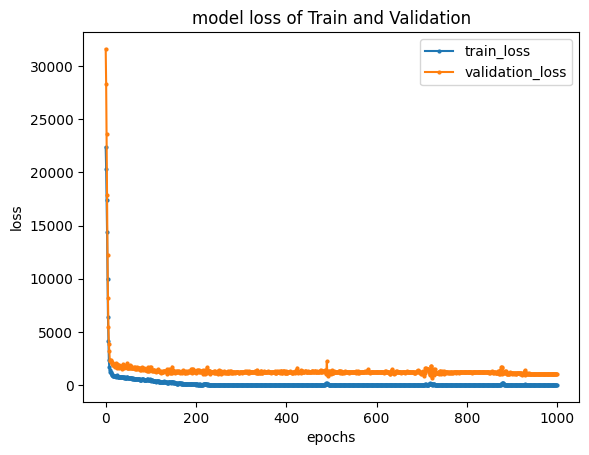

In [49]:
plt.title('model loss of Train and Validation')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(hist6.history['loss'], marker = 'o', ms = 2, label='train_loss')
plt.plot(hist6.history['val_loss'], marker = 'o', ms = 2, label='validation_loss')
plt.legend()

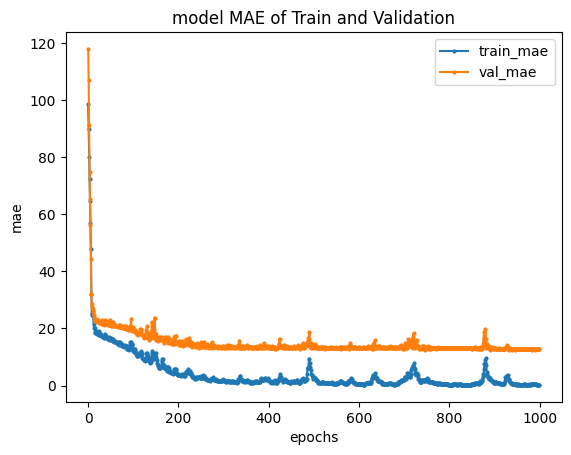

In [50]:
plt.title('model MAE of Train and Validation')
plt.xlabel('epochs')
plt.ylabel('mae')
plt.plot(hist6.history['mae'], marker = 'o', ms = 2, label='train_mae')
plt.plot(hist6.history['val_mae'], marker = 'o', ms = 2, label='val_mae')
plt.legend()

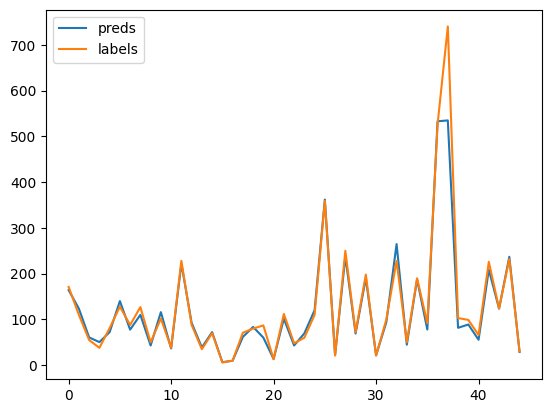

In [51]:
x_axis = [i for i in range(len(preds))]
plt.plot(x_axis,preds,label='preds')
plt.plot(x_axis,Y_val,label='labels')
plt.legend()

## 2. TabNet 활용한 잉크젯 생성 데이터 예측


### 2.1 TabNet 라이브러리 설치

In [52]:
import pandas as pd
import numpy  as np
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

import os
from pathlib import Path

from matplotlib import pyplot as plt
%matplotlib inline

/home/elicer/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [53]:
df = pd.read_csv('InkjetDB_preprocessing.csv')
X = df.loc[:, 'Viscosity': 'PrintingSpeed']
Y = df['PatternSize']

### 2.2 Train/Test set split

train/valid 를 8:2 비율로 나눠줍니다. TabNet은 전처리가 필요 없는 것이 장점이기 때문에 Scaling은 하지 않습니다.

In [54]:
X_len = len(X)
Y_len = len(Y)

X_train = X[:int(X_len*0.8)]
X_val = X[int(X_len*0.8):]
Y_train = Y[:int(Y_len*0.8)]
Y_val = Y[int(Y_len*0.8):]

print(len(X_train), len(Y_train))
print(len(X_val), len(Y_val))

180 180
45 45


In [55]:
X_train = X_train.to_numpy()
X_val = X_val.to_numpy()

TabNetRegressor의 내부 구현에 맞추어 레이블의 형태를 (row 수, 1) 로 수정합니다.

In [56]:
Y_train = Y_train.to_numpy()
Y_train = Y_train.reshape(-1, 1)
Y_val = Y_val.to_numpy()
Y_val = Y_val.reshape(-1, 1)
print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)

(180, 3)
(180, 1)
(45, 3)
(45, 1)


### 2.3 TabNet 모델 선언 및 학습

TabNet은 별도의 feature engineering이 필요치 않습니다. raw data로 그대로 학습을 진행합니다.

In [57]:
n_steps = 2

regressor = TabNetRegressor(verbose=1, seed=42, n_steps=n_steps)
regressor.fit(X_train=X_train, y_train=Y_train,
             eval_set=[(X_val, Y_val)],
             patience=300, max_epochs=2000,
             eval_metric=['mse'])

Device used : cpu
epoch 0  | loss: 23085.56641| val_0_mse: 32166.83233|  0:00:00s
epoch 1  | loss: 22947.19727| val_0_mse: 34882.6751|  0:00:00s
epoch 2  | loss: 22773.07227| val_0_mse: 34554.14413|  0:00:00s
epoch 3  | loss: 22606.64648| val_0_mse: 34559.53837|  0:00:00s
epoch 4  | loss: 22499.34766| val_0_mse: 34109.62506|  0:00:00s
epoch 5  | loss: 22332.6543| val_0_mse: 33471.04336|  0:00:00s
epoch 6  | loss: 22160.85352| val_0_mse: 32646.84285|  0:00:00s
epoch 7  | loss: 22014.74609| val_0_mse: 31622.26007|  0:00:00s
epoch 8  | loss: 21883.43945| val_0_mse: 31235.34114|  0:00:00s
epoch 9  | loss: 21732.07227| val_0_mse: 31067.62729|  0:00:00s
epoch 10 | loss: 21585.35352| val_0_mse: 31015.11199|  0:00:00s
epoch 11 | loss: 21412.14258| val_0_mse: 31355.37538|  0:00:00s
epoch 12 | loss: 21287.17578| val_0_mse: 31778.8547|  0:00:00s
epoch 13 | loss: 21157.02148| val_0_mse: 31915.52028|  0:00:00s
epoch 14 | loss: 21034.66016| val_0_mse: 32105.35593|  0:00:00s
epoch 15 | loss: 20892.11

epoch 131| loss: 584.36206| val_0_mse: 3616.81157|  0:00:03s
epoch 132| loss: 112.43831| val_0_mse: 3907.09429|  0:00:03s
epoch 133| loss: 568.59283| val_0_mse: 4304.02147|  0:00:03s
epoch 134| loss: 193.06  | val_0_mse: 4632.68112|  0:00:03s
epoch 135| loss: 132.47795| val_0_mse: 5234.52734|  0:00:03s
epoch 136| loss: 1128.78577| val_0_mse: 5636.63255|  0:00:03s
epoch 137| loss: 278.23981| val_0_mse: 6525.22887|  0:00:03s
epoch 138| loss: 399.62781| val_0_mse: 7591.25991|  0:00:03s
epoch 139| loss: 167.77669| val_0_mse: 7950.47857|  0:00:03s
epoch 140| loss: 162.03316| val_0_mse: 8136.54273|  0:00:03s
epoch 141| loss: 216.96645| val_0_mse: 8352.73223|  0:00:03s
epoch 142| loss: 276.52332| val_0_mse: 8669.69593|  0:00:03s
epoch 143| loss: 105.37615| val_0_mse: 8573.46553|  0:00:03s
epoch 144| loss: 73.87508| val_0_mse: 8185.81104|  0:00:03s
epoch 145| loss: 171.09393| val_0_mse: 7871.61872|  0:00:03s
epoch 146| loss: 245.46404| val_0_mse: 8307.90138|  0:00:03s
epoch 147| loss: 539.5975

epoch 268| loss: 314.07123| val_0_mse: 4121.80704|  0:00:06s
epoch 269| loss: 116.29223| val_0_mse: 4389.23646|  0:00:06s
epoch 270| loss: 107.10375| val_0_mse: 3840.80334|  0:00:06s
epoch 271| loss: 130.44783| val_0_mse: 2647.37579|  0:00:06s
epoch 272| loss: 238.59448| val_0_mse: 1906.15854|  0:00:06s
epoch 273| loss: 232.26547| val_0_mse: 1649.54387|  0:00:06s
epoch 274| loss: 779.28754| val_0_mse: 1798.75166|  0:00:06s
epoch 275| loss: 158.89339| val_0_mse: 1879.76155|  0:00:06s
epoch 276| loss: 95.72199| val_0_mse: 1656.45862|  0:00:06s
epoch 277| loss: 352.66086| val_0_mse: 1416.47364|  0:00:06s
epoch 278| loss: 164.67714| val_0_mse: 1123.5864|  0:00:06s
epoch 279| loss: 333.60889| val_0_mse: 830.70341|  0:00:06s
epoch 280| loss: 580.48285| val_0_mse: 796.3978|  0:00:06s
epoch 281| loss: 300.79602| val_0_mse: 933.08077|  0:00:06s
epoch 282| loss: 138.8166| val_0_mse: 831.56159|  0:00:06s
epoch 283| loss: 101.96471| val_0_mse: 640.85571|  0:00:06s
epoch 284| loss: 148.50343| val_0

epoch 408| loss: 57.33604| val_0_mse: 213.32816|  0:00:07s
epoch 409| loss: 264.85031| val_0_mse: 196.03567|  0:00:07s
epoch 410| loss: 100.52213| val_0_mse: 267.08165|  0:00:07s
epoch 411| loss: 224.39583| val_0_mse: 396.00492|  0:00:07s
epoch 412| loss: 565.9931| val_0_mse: 487.70328|  0:00:07s
epoch 413| loss: 144.77979| val_0_mse: 657.53766|  0:00:08s
epoch 414| loss: 197.17375| val_0_mse: 818.21863|  0:00:08s
epoch 415| loss: 606.48236| val_0_mse: 1297.22094|  0:00:08s
epoch 416| loss: 473.19571| val_0_mse: 1775.45356|  0:00:08s
epoch 417| loss: 148.03308| val_0_mse: 2283.14158|  0:00:08s
epoch 418| loss: 226.9223| val_0_mse: 2680.97715|  0:00:08s
epoch 419| loss: 240.90154| val_0_mse: 2750.44836|  0:00:08s
epoch 420| loss: 89.59358| val_0_mse: 2605.51995|  0:00:08s
epoch 421| loss: 262.88126| val_0_mse: 2563.44151|  0:00:08s
epoch 422| loss: 90.07674| val_0_mse: 2949.81909|  0:00:08s
epoch 423| loss: 121.52829| val_0_mse: 3148.21481|  0:00:08s
epoch 424| loss: 114.71535| val_0_ms

epoch 549| loss: 76.42796| val_0_mse: 338.84564|  0:00:09s
epoch 550| loss: 79.82983| val_0_mse: 281.91032|  0:00:09s
epoch 551| loss: 125.22348| val_0_mse: 338.64996|  0:00:09s
epoch 552| loss: 270.5463| val_0_mse: 450.03933|  0:00:09s
epoch 553| loss: 104.2912| val_0_mse: 525.57276|  0:00:09s
epoch 554| loss: 89.66048| val_0_mse: 479.03534|  0:00:09s
epoch 555| loss: 45.15277| val_0_mse: 383.89347|  0:00:09s
epoch 556| loss: 37.18834| val_0_mse: 282.00194|  0:00:09s
epoch 557| loss: 174.35075| val_0_mse: 258.48569|  0:00:09s
epoch 558| loss: 75.46384| val_0_mse: 230.98425|  0:00:09s
epoch 559| loss: 216.98195| val_0_mse: 228.01436|  0:00:09s
epoch 560| loss: 151.16599| val_0_mse: 239.81333|  0:00:09s
epoch 561| loss: 100.29947| val_0_mse: 290.16519|  0:00:09s
epoch 562| loss: 94.54443| val_0_mse: 301.16272|  0:00:10s
epoch 563| loss: 78.12361| val_0_mse: 314.40875|  0:00:10s
epoch 564| loss: 160.88564| val_0_mse: 292.29196|  0:00:10s
epoch 565| loss: 39.48642| val_0_mse: 308.57807|  

epoch 690| loss: 68.71866| val_0_mse: 240.56322|  0:00:11s
epoch 691| loss: 133.74792| val_0_mse: 220.64544|  0:00:11s
epoch 692| loss: 56.8097 | val_0_mse: 252.02895|  0:00:11s
epoch 693| loss: 76.97115| val_0_mse: 252.81396|  0:00:11s
epoch 694| loss: 58.48356| val_0_mse: 249.85915|  0:00:11s
epoch 695| loss: 61.05163| val_0_mse: 173.95511|  0:00:11s
epoch 696| loss: 56.5734 | val_0_mse: 134.52989|  0:00:11s
epoch 697| loss: 58.1039 | val_0_mse: 176.89984|  0:00:11s
epoch 698| loss: 110.70933| val_0_mse: 211.63484|  0:00:11s
epoch 699| loss: 293.71841| val_0_mse: 191.42558|  0:00:11s
epoch 700| loss: 146.40306| val_0_mse: 175.25886|  0:00:11s
epoch 701| loss: 49.1085 | val_0_mse: 198.18289|  0:00:11s
epoch 702| loss: 169.30608| val_0_mse: 207.07129|  0:00:11s
epoch 703| loss: 74.2458 | val_0_mse: 240.38892|  0:00:11s
epoch 704| loss: 94.89658| val_0_mse: 282.09259|  0:00:11s
epoch 705| loss: 93.9006 | val_0_mse: 330.04119|  0:00:11s
epoch 706| loss: 70.72801| val_0_mse: 299.53  |  0:

epoch 831| loss: 91.76626| val_0_mse: 317.30338|  0:00:13s
epoch 832| loss: 83.40885| val_0_mse: 241.33089|  0:00:13s
epoch 833| loss: 165.68864| val_0_mse: 267.21921|  0:00:13s
epoch 834| loss: 122.33272| val_0_mse: 305.88491|  0:00:13s
epoch 835| loss: 124.99906| val_0_mse: 341.14799|  0:00:13s
epoch 836| loss: 109.05976| val_0_mse: 376.55119|  0:00:13s
epoch 837| loss: 81.03655| val_0_mse: 368.24256|  0:00:13s
epoch 838| loss: 83.88097| val_0_mse: 315.78911|  0:00:13s
epoch 839| loss: 67.23376| val_0_mse: 237.11416|  0:00:13s
epoch 840| loss: 52.67363| val_0_mse: 233.36562|  0:00:13s
epoch 841| loss: 73.39273| val_0_mse: 229.04689|  0:00:13s
epoch 842| loss: 125.55729| val_0_mse: 266.4862|  0:00:13s
epoch 843| loss: 184.05455| val_0_mse: 312.31596|  0:00:13s
epoch 844| loss: 66.8587 | val_0_mse: 414.67386|  0:00:13s
epoch 845| loss: 91.91307| val_0_mse: 435.79837|  0:00:13s
epoch 846| loss: 43.92969| val_0_mse: 364.83584|  0:00:13s
epoch 847| loss: 72.69176| val_0_mse: 325.53814|  0

epoch 972| loss: 61.55759| val_0_mse: 210.95392|  0:00:15s
epoch 973| loss: 133.28471| val_0_mse: 204.78565|  0:00:15s
epoch 974| loss: 142.58722| val_0_mse: 458.09335|  0:00:15s
epoch 975| loss: 167.76503| val_0_mse: 1069.862|  0:00:15s
epoch 976| loss: 97.82956| val_0_mse: 1369.68831|  0:00:15s
epoch 977| loss: 126.17056| val_0_mse: 1329.89429|  0:00:15s
epoch 978| loss: 76.21614| val_0_mse: 1034.83587|  0:00:15s
epoch 979| loss: 71.29897| val_0_mse: 633.46068|  0:00:15s
epoch 980| loss: 64.23603| val_0_mse: 345.47401|  0:00:15s
epoch 981| loss: 121.659 | val_0_mse: 268.06558|  0:00:15s
epoch 982| loss: 103.94711| val_0_mse: 207.03843|  0:00:15s
epoch 983| loss: 85.59187| val_0_mse: 258.25829|  0:00:15s
epoch 984| loss: 102.08182| val_0_mse: 237.73978|  0:00:15s
epoch 985| loss: 67.83831| val_0_mse: 194.42975|  0:00:15s
epoch 986| loss: 201.62378| val_0_mse: 164.01925|  0:00:15s
epoch 987| loss: 72.30637| val_0_mse: 169.08576|  0:00:15s
epoch 988| loss: 95.4477 | val_0_mse: 171.36093

### 2.4 TabNet 성능 평가

실제 값에 보다 가까워진 예측값을 확인할 수 있습니다.

In [58]:
preds = regressor.predict(X_val)
print('예측값 : ', preds[0])
print('정답 : ', Y_val[0])

예측값 :  [169.44333]
정답 :  [171]


r2 score도 MLP 베이스 모델에 비해 높은 성능을 보여줍니다.

In [59]:
r2 = r2_score(Y_val, preds)
print(r2)

0.9925097014981012


학습된 mask를 시각화하여 각 test case를 regression하며 어떤 feature가 중요하게 여겨졌는지 확인합니다. n_steps를 조정하면 생성되는 mask 수를 조절할 수 있습니다.

In [60]:
explain_matrix, masks = regressor.explain(X_val)

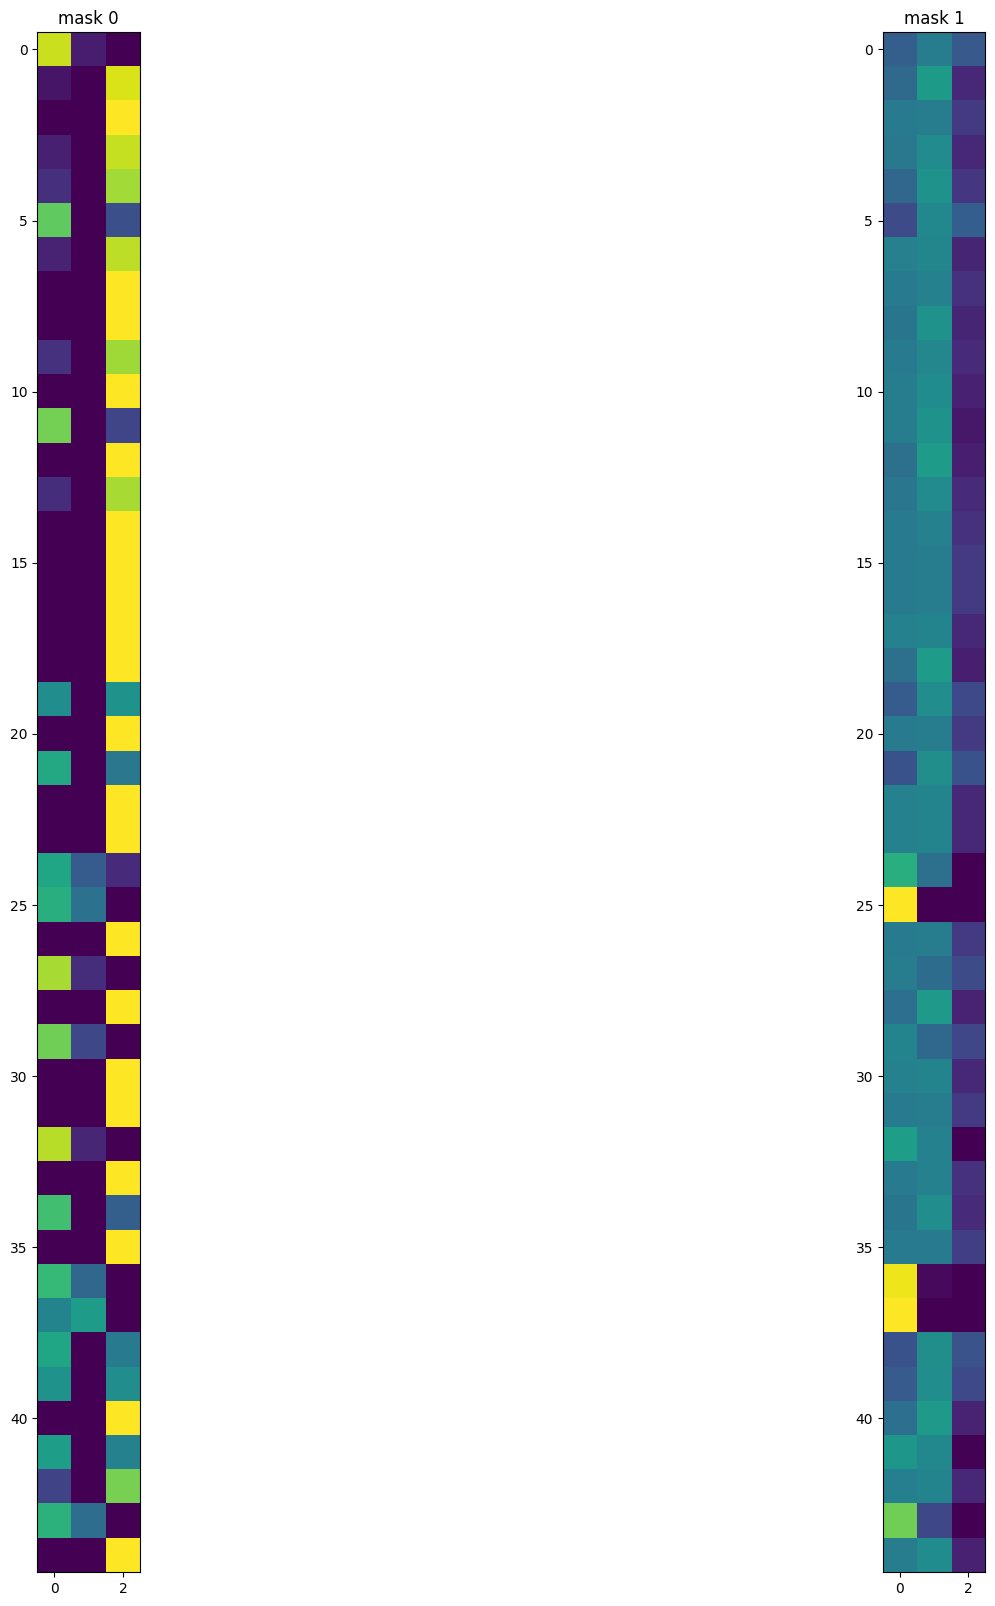

In [61]:
fig, axs = plt.subplots(1, n_steps, figsize=(20,20))

for i in range(n_steps):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")

## 3. 연습문제

### 3.1 MLP 모델 구조를 수정하거나, 오버피팅 방지 기법을 모두 적용하며 성능을 최대한 끌어올려 봅니다.
  평가 지표는 'R2 score'입니다.

- epochs
- batch size
- dropout
- weight restriction
- weight initialization
- early stopping
- 그 외 모델 변형 및 하이퍼파라미터 튜닝

In [62]:
df = pd.read_csv('InkjetDB_preprocessing.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df.head()
X = df.loc[:, 'Viscosity': 'PrintingSpeed']
Y = df['PatternSize']
from sklearn.preprocessing import StandardScaler

# 원래 데이터들의 평균과 분산 확인 
print('feature 들의 평균 값')
print(X.mean())
print('\nfeature 들의 분산 값')
print(X.var())

X_train = X.loc[:int(len(X)*0.8)-1]
X_val = X.loc[int(len(X)*0.8):]
Y_train = Y.loc[:int(len(Y)*0.8)-1]
Y_val = Y.loc[int(len(Y)*0.8):]
print("\n=========== 표준화 ==============\n")

# StandardScaler객체 생성
scaler = StandardScaler()
# StandardScaler 로 데이터 셋 변환. fit( ) 과 transform( ) 호출.  
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled=scaler.transform(X_val)

#transform( )시 scale 변환된 데이터 셋이 numpy ndarry로 반환되어 이를 DataFrame으로 변환
X_df_scaled = pd.DataFrame(data=X_train_scaled, columns=X.columns)
print('(Train) feature 들의 평균 값')
print(X_df_scaled.mean())
print('\n(Train) feature 들의 분산 값')
print(X_df_scaled.var())

X_train=tf.convert_to_tensor(X_train_scaled)
X_val=tf.convert_to_tensor(X_val_scaled)
Y_train=tf.convert_to_tensor(Y_train)
Y_val=tf.convert_to_tensor(Y_val)


print('X_train_shape : ', X_train.shape)
print('X_val_shape : ', X_val.shape)
print('Y_train_shape : ', Y_train.shape)
print('Y_val_shape :', Y_val.shape)

feature 들의 평균 값
Viscosity          6.080000
Velocity           6.537778
PrintingSpeed    129.777778
dtype: float64

feature 들의 분산 값
Viscosity           3.493571
Velocity            1.356825
PrintingSpeed    4728.745040
dtype: float64

=========== 표준화 ==============

(Train) feature 들의 평균 값
Viscosity       -1.973730e-16
Velocity        -1.973730e-17
PrintingSpeed   -1.875043e-16
dtype: float64

(Train) feature 들의 분산 값
Viscosity        1.005587
Velocity         1.005587
PrintingSpeed    1.005587
dtype: float64
X_train_shape :  (180, 3)
X_val_shape :  (45, 3)
Y_train_shape :  (180,)
Y_val_shape : (45,)


In [63]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.constraints import max_norm
from sklearn.metrics import r2_score

In [65]:
learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(lr = learning_rate)
loss = MeanSquaredError()
epochs = 1000
batch_size=32

/home/elicer/.local/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [66]:
earlystopping = EarlyStopping(monitor='val_loss',  # 모니터 기준 설정 (val loss) 
                patience=100,               # _____회 Epoch동안 개선되지 않는다면 종료
                )

ckpt_name = 'checkpoint-epoch-{}-batch-{}-trial-001.h5'.format(epochs, batch_size)
checkpoint = ModelCheckpoint(ckpt_name,             # file명을 지정합니다
                            monitor='val_loss',     # val_loss 값이 개선되었을때 호출됩니다
                            verbose=1,              # 로그를 출력합니다
                            save_best_only=True,    # 가장 best 값만 저장합니다
                            )

In [67]:
dropout_layer = tf.keras.layers.Dropout(0.2, input_shape=(2,)) # 0.2는 dropout이 걸릴 확률

In [70]:
model_custom = tf.keras.Sequential()

model_custom.add(tf.keras.Input(shape = 3))
model_custom.add(Dense(300, kernel_constraint=max_norm(2.0), activation='relu', kernel_initializer='he_normal'))
model_custom.add(dropout_layer) # dropout을 추가할 layer 입니다.
model_custom.add(Dense(200, kernel_constraint=max_norm(2.0), activation='relu', kernel_initializer='he_normal'))
model_custom.add(dropout_layer) # dropout을 추가할 layer 입니다.
model_custom.add(Dense(150, kernel_constraint=max_norm(2.0), activation='relu', kernel_initializer='he_normal'))
model_custom.add(dropout_layer) # dropout을 추가할 layer 입니다.
model_custom.add(Dense(100, kernel_constraint=max_norm(2.0), activation='relu', kernel_initializer='he_normal'))
model_custom.add(dropout_layer)
model_custom.add(Dense(50, kernel_constraint=max_norm(2.0), activation='relu', kernel_initializer='he_normal'))
model_custom.add(dropout_layer)
model_custom.add(Dense(1))

In [71]:
model_custom.compile(loss=loss, optimizer=optimizer, metrics=['mse', 'mae'])
model_custom.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 300)               1200      
                                                                 
 dropout_1 (Dropout)         multiple                  0         
                                                                 
 dense_37 (Dense)            (None, 200)               60200     
                                                                 
 dense_38 (Dense)            (None, 150)               30150     
                                                                 
 dense_39 (Dense)            (None, 100)               15100     
                                                                 
 dense_40 (Dense)            (None, 50)                5050      
                                                                 
 dense_41 (Dense)            (None, 1)                

In [72]:
hist_custom = model_custom.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, validation_data =(X_val, Y_val),callbacks=[earlystopping,checkpoint])

Epoch 1/1000
1/6 [====>.........................] - ETA: 4s - loss: 20817.4043 - mse: 20817.4043 - mae: 110.5926
Epoch 1: val_loss improved from inf to 31366.75586, saving model to checkpoint-epoch-1000-batch-32-trial-001.h5
6/6 [==============================] - 1s 58ms/step - loss: 22382.2188 - mse: 22382.2188 - mae: 99.0758 - val_loss: 31366.7559 - val_mse: 31366.7559 - val_mae: 117.8805
Epoch 2/1000
1/6 [====>.........................] - ETA: 0s - loss: 21721.0156 - mse: 21721.0156 - mae: 98.0977
Epoch 2: val_loss improved from 31366.75586 to 25655.87695, saving model to checkpoint-epoch-1000-batch-32-trial-001.h5
6/6 [==============================] - 0s 19ms/step - loss: 19385.1602 - mse: 19385.1602 - mae: 87.8143 - val_loss: 25655.8770 - val_mse: 25655.8809 - val_mae: 99.9403
Epoch 3/1000
1/6 [====>.........................] - ETA: 0s - loss: 14136.9316 - mse: 14136.9316 - mae: 64.1915
Epoch 3: val_loss improved from 25655.87695 to 16230.37891, saving model to checkpoint-epoch-1

Epoch 24/1000
1/6 [====>.........................] - ETA: 0s - loss: 1724.8049 - mse: 1724.8049 - mae: 28.2804
Epoch 24: val_loss did not improve from 1629.40613
6/6 [==============================] - 0s 10ms/step - loss: 1584.3309 - mse: 1584.3309 - mae: 25.5556 - val_loss: 3192.9785 - val_mse: 3192.9785 - val_mae: 30.1058
Epoch 25/1000
1/6 [====>.........................] - ETA: 0s - loss: 2005.6135 - mse: 2005.6135 - mae: 29.6991
Epoch 25: val_loss did not improve from 1629.40613
6/6 [==============================] - 0s 9ms/step - loss: 1802.2042 - mse: 1802.2042 - mae: 26.0690 - val_loss: 2807.7773 - val_mse: 2807.7773 - val_mae: 27.9569
Epoch 26/1000
1/6 [====>.........................] - ETA: 0s - loss: 2970.8835 - mse: 2970.8835 - mae: 32.8341
Epoch 26: val_loss did not improve from 1629.40613
6/6 [==============================] - 0s 9ms/step - loss: 1798.1768 - mse: 1798.1768 - mae: 25.9990 - val_loss: 1849.1012 - val_mse: 1849.1012 - val_mae: 22.1446
Epoch 27/1000
1/6 [====>

1/6 [====>.........................] - ETA: 0s - loss: 738.3123 - mse: 738.3123 - mae: 17.7468
Epoch 49: val_loss did not improve from 1605.03162
6/6 [==============================] - 0s 9ms/step - loss: 1932.8751 - mse: 1932.8751 - mae: 26.0490 - val_loss: 2080.1169 - val_mse: 2080.1169 - val_mae: 22.8414
Epoch 50/1000
1/6 [====>.........................] - ETA: 0s - loss: 940.5175 - mse: 940.5175 - mae: 21.9734
Epoch 50: val_loss did not improve from 1605.03162
6/6 [==============================] - 0s 10ms/step - loss: 1429.4000 - mse: 1429.4000 - mae: 25.1427 - val_loss: 2232.3279 - val_mse: 2232.3279 - val_mae: 24.1879
Epoch 51/1000
1/6 [====>.........................] - ETA: 0s - loss: 458.8578 - mse: 458.8578 - mae: 15.2436
Epoch 51: val_loss did not improve from 1605.03162
6/6 [==============================] - 0s 9ms/step - loss: 1928.5675 - mse: 1928.5675 - mae: 26.4221 - val_loss: 1785.2063 - val_mse: 1785.2063 - val_mae: 21.8848
Epoch 52/1000
1/6 [====>....................

1/6 [====>.........................] - ETA: 0s - loss: 322.7011 - mse: 322.7011 - mae: 13.9053
Epoch 74: val_loss did not improve from 1462.18420
6/6 [==============================] - 0s 9ms/step - loss: 1575.2850 - mse: 1575.2850 - mae: 22.9967 - val_loss: 1738.0021 - val_mse: 1738.0021 - val_mae: 21.0952
Epoch 75/1000
1/6 [====>.........................] - ETA: 0s - loss: 1952.5208 - mse: 1952.5208 - mae: 30.2608
Epoch 75: val_loss did not improve from 1462.18420
6/6 [==============================] - 0s 9ms/step - loss: 1451.2339 - mse: 1451.2339 - mae: 22.9661 - val_loss: 1539.6038 - val_mse: 1539.6038 - val_mae: 20.9477
Epoch 76/1000
1/6 [====>.........................] - ETA: 0s - loss: 2036.5170 - mse: 2036.5170 - mae: 25.1290
Epoch 76: val_loss did not improve from 1462.18420
6/6 [==============================] - 0s 9ms/step - loss: 1572.1342 - mse: 1572.1342 - mae: 22.1860 - val_loss: 1833.5332 - val_mse: 1833.5332 - val_mae: 22.8478
Epoch 77/1000
1/6 [====>.................

Epoch 99/1000
1/6 [====>.........................] - ETA: 0s - loss: 585.3562 - mse: 585.3562 - mae: 17.9675
Epoch 99: val_loss did not improve from 1443.30762
6/6 [==============================] - 0s 10ms/step - loss: 1316.2942 - mse: 1316.2942 - mae: 21.6360 - val_loss: 2027.5059 - val_mse: 2027.5059 - val_mae: 22.0457
Epoch 100/1000
1/6 [====>.........................] - ETA: 0s - loss: 534.4846 - mse: 534.4846 - mae: 15.4572
Epoch 100: val_loss did not improve from 1443.30762
6/6 [==============================] - 0s 9ms/step - loss: 1119.7826 - mse: 1119.7826 - mae: 20.0833 - val_loss: 2431.1052 - val_mse: 2431.1052 - val_mae: 23.1809
Epoch 101/1000
1/6 [====>.........................] - ETA: 0s - loss: 500.4440 - mse: 500.4440 - mae: 15.9906
Epoch 101: val_loss did not improve from 1443.30762
6/6 [==============================] - 0s 9ms/step - loss: 858.2317 - mse: 858.2317 - mae: 19.4550 - val_loss: 1818.0983 - val_mse: 1818.0983 - val_mae: 20.9337
Epoch 102/1000
1/6 [====>...

Epoch 124/1000
1/6 [====>.........................] - ETA: 0s - loss: 2383.9158 - mse: 2383.9158 - mae: 27.3238
Epoch 124: val_loss did not improve from 1430.10474
6/6 [==============================] - 0s 9ms/step - loss: 1334.6750 - mse: 1334.6750 - mae: 21.1758 - val_loss: 2640.4724 - val_mse: 2640.4724 - val_mae: 25.4002
Epoch 125/1000
1/6 [====>.........................] - ETA: 0s - loss: 1654.9941 - mse: 1654.9941 - mae: 23.6435
Epoch 125: val_loss did not improve from 1430.10474
6/6 [==============================] - 0s 9ms/step - loss: 1159.5482 - mse: 1159.5482 - mae: 20.5718 - val_loss: 2027.4774 - val_mse: 2027.4774 - val_mae: 20.8359
Epoch 126/1000
1/6 [====>.........................] - ETA: 0s - loss: 3165.7009 - mse: 3165.7009 - mae: 26.9331
Epoch 126: val_loss did not improve from 1430.10474
6/6 [==============================] - 0s 9ms/step - loss: 1635.7991 - mse: 1635.7991 - mae: 23.7576 - val_loss: 1842.1505 - val_mse: 1842.1505 - val_mae: 20.8142
Epoch 127/1000
1/6 

Epoch 149/1000
1/6 [====>.........................] - ETA: 0s - loss: 873.0896 - mse: 873.0896 - mae: 20.4712
Epoch 149: val_loss did not improve from 1213.85571
6/6 [==============================] - 0s 10ms/step - loss: 1264.1497 - mse: 1264.1497 - mae: 19.1519 - val_loss: 1522.9839 - val_mse: 1522.9839 - val_mae: 20.9650
Epoch 150/1000
1/6 [====>.........................] - ETA: 0s - loss: 3610.8535 - mse: 3610.8535 - mae: 31.9709
Epoch 150: val_loss did not improve from 1213.85571
6/6 [==============================] - 0s 9ms/step - loss: 1145.6465 - mse: 1145.6465 - mae: 19.0846 - val_loss: 1742.6558 - val_mse: 1742.6555 - val_mae: 24.7322
Epoch 151/1000
1/6 [====>.........................] - ETA: 0s - loss: 600.5506 - mse: 600.5506 - mae: 14.6357
Epoch 151: val_loss did not improve from 1213.85571
6/6 [==============================] - 0s 9ms/step - loss: 1146.7089 - mse: 1146.7089 - mae: 18.9702 - val_loss: 2321.8337 - val_mse: 2321.8337 - val_mae: 26.9766
Epoch 152/1000
1/6 [==

Epoch 174/1000
1/6 [====>.........................] - ETA: 0s - loss: 944.8983 - mse: 944.8983 - mae: 18.7484
Epoch 174: val_loss did not improve from 1073.55847
6/6 [==============================] - 0s 9ms/step - loss: 844.5948 - mse: 844.5948 - mae: 17.7852 - val_loss: 2044.5750 - val_mse: 2044.5750 - val_mae: 23.2052
Epoch 175/1000
1/6 [====>.........................] - ETA: 0s - loss: 1497.5154 - mse: 1497.5154 - mae: 23.5815
Epoch 175: val_loss did not improve from 1073.55847
6/6 [==============================] - 0s 9ms/step - loss: 1013.0200 - mse: 1013.0200 - mae: 18.8850 - val_loss: 1910.6274 - val_mse: 1910.6274 - val_mae: 21.0610
Epoch 176/1000
1/6 [====>.........................] - ETA: 0s - loss: 1326.6132 - mse: 1326.6132 - mae: 18.3228
Epoch 176: val_loss did not improve from 1073.55847
6/6 [==============================] - 0s 9ms/step - loss: 1153.6859 - mse: 1153.6859 - mae: 18.1944 - val_loss: 1442.2489 - val_mse: 1442.2489 - val_mae: 19.2891
Epoch 177/1000
1/6 [===

1/6 [====>.........................] - ETA: 0s - loss: 399.1620 - mse: 399.1620 - mae: 14.1898
Epoch 199: val_loss did not improve from 1073.55847
6/6 [==============================] - 0s 10ms/step - loss: 946.1527 - mse: 946.1527 - mae: 17.9839 - val_loss: 1938.9893 - val_mse: 1938.9893 - val_mae: 22.4662
Epoch 200/1000
1/6 [====>.........................] - ETA: 0s - loss: 1160.4211 - mse: 1160.4211 - mae: 21.6465
Epoch 200: val_loss did not improve from 1073.55847
6/6 [==============================] - 0s 9ms/step - loss: 796.1892 - mse: 796.1892 - mae: 17.1344 - val_loss: 1818.9865 - val_mse: 1818.9865 - val_mae: 20.0333
Epoch 201/1000
1/6 [====>.........................] - ETA: 0s - loss: 1237.8253 - mse: 1237.8253 - mae: 17.0671
Epoch 201: val_loss did not improve from 1073.55847
6/6 [==============================] - 0s 9ms/step - loss: 932.7057 - mse: 932.7057 - mae: 16.4346 - val_loss: 1263.3787 - val_mse: 1263.3787 - val_mae: 17.7977
Epoch 202/1000
1/6 [====>................

1/6 [====>.........................] - ETA: 0s - loss: 1013.0596 - mse: 1013.0596 - mae: 20.1573
Epoch 224: val_loss did not improve from 1073.55847
6/6 [==============================] - 0s 9ms/step - loss: 933.5551 - mse: 933.5551 - mae: 18.6824 - val_loss: 3280.9910 - val_mse: 3280.9910 - val_mae: 32.5531
Epoch 225/1000
1/6 [====>.........................] - ETA: 0s - loss: 1474.9406 - mse: 1474.9406 - mae: 21.1773
Epoch 225: val_loss did not improve from 1073.55847
6/6 [==============================] - 0s 10ms/step - loss: 1333.0679 - mse: 1333.0679 - mae: 20.0274 - val_loss: 1198.4814 - val_mse: 1198.4814 - val_mae: 16.7564
Epoch 226/1000
1/6 [====>.........................] - ETA: 0s - loss: 1988.4976 - mse: 1988.4976 - mae: 21.5343
Epoch 226: val_loss did not improve from 1073.55847
6/6 [==============================] - 0s 10ms/step - loss: 1480.8149 - mse: 1480.8149 - mae: 21.1984 - val_loss: 1926.5167 - val_mse: 1926.5167 - val_mae: 22.4404
Epoch 227/1000
1/6 [====>.........

1/6 [====>.........................] - ETA: 0s - loss: 687.6499 - mse: 687.6499 - mae: 17.8199
Epoch 249: val_loss did not improve from 848.35992
6/6 [==============================] - 0s 9ms/step - loss: 955.0648 - mse: 955.0648 - mae: 17.8761 - val_loss: 1873.2349 - val_mse: 1873.2349 - val_mae: 22.4840
Epoch 250/1000
1/6 [====>.........................] - ETA: 0s - loss: 332.7755 - mse: 332.7755 - mae: 12.1827
Epoch 250: val_loss did not improve from 848.35992
6/6 [==============================] - 0s 9ms/step - loss: 752.2461 - mse: 752.2461 - mae: 16.8606 - val_loss: 1744.3195 - val_mse: 1744.3195 - val_mae: 22.3446
Epoch 251/1000
1/6 [====>.........................] - ETA: 0s - loss: 639.1732 - mse: 639.1732 - mae: 16.1501
Epoch 251: val_loss did not improve from 848.35992
6/6 [==============================] - 0s 10ms/step - loss: 770.2162 - mse: 770.2162 - mae: 16.9315 - val_loss: 915.8962 - val_mse: 915.8962 - val_mae: 17.7896
Epoch 252/1000
1/6 [====>.........................

1/6 [====>.........................] - ETA: 0s - loss: 514.9709 - mse: 514.9709 - mae: 14.1104
Epoch 274: val_loss did not improve from 848.35992
6/6 [==============================] - 0s 10ms/step - loss: 794.5196 - mse: 794.5196 - mae: 16.4457 - val_loss: 1397.4900 - val_mse: 1397.4900 - val_mae: 20.0441
Epoch 275/1000
1/6 [====>.........................] - ETA: 0s - loss: 722.0787 - mse: 722.0787 - mae: 16.2455
Epoch 275: val_loss did not improve from 848.35992
6/6 [==============================] - 0s 9ms/step - loss: 862.6764 - mse: 862.6764 - mae: 16.6320 - val_loss: 1766.7635 - val_mse: 1766.7635 - val_mae: 23.3324
Epoch 276/1000
1/6 [====>.........................] - ETA: 0s - loss: 672.5184 - mse: 672.5184 - mae: 15.6482
Epoch 276: val_loss did not improve from 848.35992
6/6 [==============================] - 0s 10ms/step - loss: 1192.8259 - mse: 1192.8259 - mae: 19.6581 - val_loss: 1477.3809 - val_mse: 1477.3809 - val_mae: 17.9764
Epoch 277/1000
1/6 [====>....................

1/6 [====>.........................] - ETA: 0s - loss: 871.9346 - mse: 871.9346 - mae: 16.8318
Epoch 299: val_loss did not improve from 707.27264
6/6 [==============================] - 0s 9ms/step - loss: 1201.5656 - mse: 1201.5656 - mae: 18.2709 - val_loss: 1993.9413 - val_mse: 1993.9413 - val_mae: 23.5556
Epoch 300/1000
1/6 [====>.........................] - ETA: 0s - loss: 364.9917 - mse: 364.9917 - mae: 14.0042
Epoch 300: val_loss did not improve from 707.27264
6/6 [==============================] - 0s 11ms/step - loss: 1102.8052 - mse: 1102.8052 - mae: 18.1391 - val_loss: 1707.4194 - val_mse: 1707.4194 - val_mae: 21.2689
Epoch 301/1000
1/6 [====>.........................] - ETA: 0s - loss: 441.7384 - mse: 441.7384 - mae: 12.7991
Epoch 301: val_loss did not improve from 707.27264
6/6 [==============================] - 0s 9ms/step - loss: 995.0859 - mse: 995.0859 - mae: 17.6530 - val_loss: 2276.0959 - val_mse: 2276.0959 - val_mae: 22.4042
Epoch 302/1000
1/6 [====>...................

6/6 [==============================] - 0s 10ms/step - loss: 934.8401 - mse: 934.8401 - mae: 17.5663 - val_loss: 1346.1714 - val_mse: 1346.1714 - val_mae: 18.3782
Epoch 325/1000
1/6 [====>.........................] - ETA: 0s - loss: 321.4423 - mse: 321.4423 - mae: 12.7177
Epoch 325: val_loss did not improve from 707.27264
6/6 [==============================] - 0s 9ms/step - loss: 833.5089 - mse: 833.5089 - mae: 16.9165 - val_loss: 796.1499 - val_mse: 796.1499 - val_mae: 14.0483
Epoch 326/1000
1/6 [====>.........................] - ETA: 0s - loss: 586.8970 - mse: 586.8970 - mae: 15.2131
Epoch 326: val_loss did not improve from 707.27264
6/6 [==============================] - 0s 10ms/step - loss: 994.9645 - mse: 994.9645 - mae: 18.0656 - val_loss: 2196.2625 - val_mse: 2196.2625 - val_mae: 27.1414
Epoch 327/1000
1/6 [====>.........................] - ETA: 0s - loss: 1077.3405 - mse: 1077.3405 - mae: 15.2411
Epoch 327: val_loss did not improve from 707.27264
6/6 [===========================

Epoch 350/1000
1/6 [====>.........................] - ETA: 0s - loss: 810.2344 - mse: 810.2344 - mae: 14.2346
Epoch 350: val_loss did not improve from 707.27264
6/6 [==============================] - 0s 9ms/step - loss: 741.2611 - mse: 741.2611 - mae: 15.1236 - val_loss: 1703.0861 - val_mse: 1703.0861 - val_mae: 21.5982
Epoch 351/1000
1/6 [====>.........................] - ETA: 0s - loss: 1150.0215 - mse: 1150.0215 - mae: 15.2872
Epoch 351: val_loss did not improve from 707.27264
6/6 [==============================] - 0s 9ms/step - loss: 680.0201 - mse: 680.0201 - mae: 14.1705 - val_loss: 1036.3783 - val_mse: 1036.3783 - val_mae: 16.5936
Epoch 352/1000
1/6 [====>.........................] - ETA: 0s - loss: 844.2881 - mse: 844.2881 - mae: 15.9521
Epoch 352: val_loss did not improve from 707.27264
6/6 [==============================] - 0s 10ms/step - loss: 762.3491 - mse: 762.3491 - mae: 15.9730 - val_loss: 2241.1199 - val_mse: 2241.1199 - val_mae: 25.6613
Epoch 353/1000
1/6 [====>......

Epoch 375/1000
1/6 [====>.........................] - ETA: 0s - loss: 372.1935 - mse: 372.1935 - mae: 12.7852
Epoch 375: val_loss did not improve from 595.87030
6/6 [==============================] - 0s 11ms/step - loss: 598.2609 - mse: 598.2609 - mae: 14.2955 - val_loss: 2080.6450 - val_mse: 2080.6450 - val_mae: 19.2795
Epoch 376/1000
1/6 [====>.........................] - ETA: 0s - loss: 458.1721 - mse: 458.1721 - mae: 12.0352
Epoch 376: val_loss did not improve from 595.87030
6/6 [==============================] - 0s 10ms/step - loss: 1114.0116 - mse: 1114.0116 - mae: 17.2968 - val_loss: 846.4291 - val_mse: 846.4291 - val_mae: 13.5800
Epoch 377/1000
1/6 [====>.........................] - ETA: 0s - loss: 3264.5806 - mse: 3264.5806 - mae: 32.6735
Epoch 377: val_loss did not improve from 595.87030
6/6 [==============================] - 0s 10ms/step - loss: 1155.7493 - mse: 1155.7493 - mae: 18.3301 - val_loss: 2521.3965 - val_mse: 2521.3965 - val_mae: 30.9910
Epoch 378/1000
1/6 [====>..

6/6 [==============================] - 0s 10ms/step - loss: 927.2587 - mse: 927.2587 - mae: 16.7926 - val_loss: 1369.3890 - val_mse: 1369.3890 - val_mae: 20.7530
Epoch 401/1000
1/6 [====>.........................] - ETA: 0s - loss: 1402.8893 - mse: 1402.8893 - mae: 22.7517
Epoch 401: val_loss improved from 595.87030 to 503.76294, saving model to checkpoint-epoch-1000-batch-32-trial-001.h5
6/6 [==============================] - 0s 17ms/step - loss: 600.7744 - mse: 600.7744 - mae: 14.2588 - val_loss: 503.7629 - val_mse: 503.7629 - val_mae: 12.2821
Epoch 402/1000
1/6 [====>.........................] - ETA: 0s - loss: 1262.2590 - mse: 1262.2590 - mae: 17.4478
Epoch 402: val_loss did not improve from 503.76294
6/6 [==============================] - 0s 12ms/step - loss: 827.0158 - mse: 827.0158 - mae: 15.7848 - val_loss: 1934.7877 - val_mse: 1934.7877 - val_mae: 26.0814
Epoch 403/1000
1/6 [====>.........................] - ETA: 0s - loss: 1364.0146 - mse: 1364.0146 - mae: 19.2513
Epoch 403: 

Epoch 426/1000
1/6 [====>.........................] - ETA: 0s - loss: 3191.3311 - mse: 3191.3311 - mae: 25.6554
Epoch 426: val_loss did not improve from 503.76294
6/6 [==============================] - 0s 11ms/step - loss: 1148.3400 - mse: 1148.3400 - mae: 16.4959 - val_loss: 1112.9050 - val_mse: 1112.9050 - val_mae: 12.9416
Epoch 427/1000
1/6 [====>.........................] - ETA: 0s - loss: 478.0977 - mse: 478.0977 - mae: 10.0759
Epoch 427: val_loss did not improve from 503.76294
6/6 [==============================] - 0s 10ms/step - loss: 575.8963 - mse: 575.8963 - mae: 13.2986 - val_loss: 1212.3730 - val_mse: 1212.3730 - val_mae: 16.4496
Epoch 428/1000
1/6 [====>.........................] - ETA: 0s - loss: 506.8869 - mse: 506.8869 - mae: 15.8863
Epoch 428: val_loss did not improve from 503.76294
6/6 [==============================] - 0s 10ms/step - loss: 728.7686 - mse: 728.7686 - mae: 15.0909 - val_loss: 1434.6218 - val_mse: 1434.6217 - val_mae: 19.9046
Epoch 429/1000
1/6 [====>..

Epoch 451/1000
1/6 [====>.........................] - ETA: 0s - loss: 770.5562 - mse: 770.5562 - mae: 18.0595
Epoch 451: val_loss did not improve from 476.57266
6/6 [==============================] - 0s 10ms/step - loss: 916.9649 - mse: 916.9649 - mae: 18.6149 - val_loss: 2236.7527 - val_mse: 2236.7527 - val_mae: 26.0097
Epoch 452/1000
1/6 [====>.........................] - ETA: 0s - loss: 1142.6960 - mse: 1142.6960 - mae: 21.2859
Epoch 452: val_loss did not improve from 476.57266
6/6 [==============================] - 0s 10ms/step - loss: 1014.1091 - mse: 1014.1091 - mae: 17.5505 - val_loss: 714.6982 - val_mse: 714.6982 - val_mae: 11.6046
Epoch 453/1000
1/6 [====>.........................] - ETA: 0s - loss: 429.8785 - mse: 429.8785 - mae: 14.1321
Epoch 453: val_loss did not improve from 476.57266
6/6 [==============================] - 0s 10ms/step - loss: 595.9626 - mse: 595.9626 - mae: 14.3981 - val_loss: 1187.0576 - val_mse: 1187.0576 - val_mae: 17.4634
Epoch 454/1000
1/6 [====>....

6/6 [==============================] - 0s 10ms/step - loss: 553.5020 - mse: 553.5020 - mae: 15.0778 - val_loss: 1100.1913 - val_mse: 1100.1913 - val_mae: 16.2341
Epoch 477/1000
1/6 [====>.........................] - ETA: 0s - loss: 343.5591 - mse: 343.5591 - mae: 12.0259
Epoch 477: val_loss did not improve from 476.57266
6/6 [==============================] - 0s 10ms/step - loss: 349.6800 - mse: 349.6800 - mae: 12.4728 - val_loss: 837.4982 - val_mse: 837.4982 - val_mae: 15.0954
Epoch 478/1000
1/6 [====>.........................] - ETA: 0s - loss: 150.3495 - mse: 150.3495 - mae: 8.3762
Epoch 478: val_loss did not improve from 476.57266
6/6 [==============================] - 0s 10ms/step - loss: 539.3593 - mse: 539.3593 - mae: 13.9023 - val_loss: 1417.9777 - val_mse: 1417.9777 - val_mae: 21.0485
Epoch 479/1000
1/6 [====>.........................] - ETA: 0s - loss: 389.2752 - mse: 389.2752 - mae: 14.2446
Epoch 479: val_loss did not improve from 476.57266
6/6 [=============================

Epoch 502/1000
1/6 [====>.........................] - ETA: 0s - loss: 312.6278 - mse: 312.6278 - mae: 10.9992
Epoch 502: val_loss improved from 476.57266 to 467.16498, saving model to checkpoint-epoch-1000-batch-32-trial-001.h5
6/6 [==============================] - 0s 17ms/step - loss: 921.6826 - mse: 921.6826 - mae: 15.4363 - val_loss: 467.1650 - val_mse: 467.1650 - val_mae: 11.1263
Epoch 503/1000
1/6 [====>.........................] - ETA: 0s - loss: 404.0462 - mse: 404.0462 - mae: 12.3552
Epoch 503: val_loss did not improve from 467.16498
6/6 [==============================] - 0s 12ms/step - loss: 807.2524 - mse: 807.2524 - mae: 15.4501 - val_loss: 2595.3708 - val_mse: 2595.3708 - val_mae: 30.4863
Epoch 504/1000
1/6 [====>.........................] - ETA: 0s - loss: 1589.3604 - mse: 1589.3604 - mae: 22.4631
Epoch 504: val_loss did not improve from 467.16498
6/6 [==============================] - 0s 10ms/step - loss: 793.1483 - mse: 793.1483 - mae: 16.9872 - val_loss: 1765.7109 - va

1/6 [====>.........................] - ETA: 0s - loss: 551.4275 - mse: 551.4275 - mae: 13.5078
Epoch 527: val_loss did not improve from 467.16498
6/6 [==============================] - 0s 10ms/step - loss: 690.5385 - mse: 690.5385 - mae: 14.3603 - val_loss: 1607.0077 - val_mse: 1607.0077 - val_mae: 18.3269
Epoch 528/1000
1/6 [====>.........................] - ETA: 0s - loss: 269.7633 - mse: 269.7633 - mae: 11.4823
Epoch 528: val_loss did not improve from 467.16498
6/6 [==============================] - 0s 10ms/step - loss: 485.3835 - mse: 485.3835 - mae: 13.3817 - val_loss: 996.2084 - val_mse: 996.2084 - val_mae: 13.6963
Epoch 529/1000
1/6 [====>.........................] - ETA: 0s - loss: 137.4386 - mse: 137.4386 - mae: 8.2529
Epoch 529: val_loss did not improve from 467.16498
6/6 [==============================] - 0s 10ms/step - loss: 783.2947 - mse: 783.2947 - mae: 14.6566 - val_loss: 1632.2030 - val_mse: 1632.2030 - val_mae: 21.5794
Epoch 530/1000
1/6 [====>........................

6/6 [==============================] - 0s 10ms/step - loss: 866.5704 - mse: 866.5704 - mae: 15.5716 - val_loss: 1060.9236 - val_mse: 1060.9236 - val_mae: 12.7060
Epoch 553/1000
1/6 [====>.........................] - ETA: 0s - loss: 761.5322 - mse: 761.5322 - mae: 16.5886
Epoch 553: val_loss did not improve from 467.16498
6/6 [==============================] - 0s 10ms/step - loss: 832.7305 - mse: 832.7305 - mae: 17.1668 - val_loss: 871.0514 - val_mse: 871.0514 - val_mae: 11.4077
Epoch 554/1000
1/6 [====>.........................] - ETA: 0s - loss: 388.4362 - mse: 388.4362 - mae: 12.2210
Epoch 554: val_loss did not improve from 467.16498
6/6 [==============================] - 0s 9ms/step - loss: 1107.3096 - mse: 1107.3096 - mae: 17.1136 - val_loss: 2244.4998 - val_mse: 2244.4998 - val_mae: 26.6946
Epoch 555/1000
1/6 [====>.........................] - ETA: 0s - loss: 1048.3396 - mse: 1048.3396 - mae: 20.1088
Epoch 555: val_loss did not improve from 467.16498
6/6 [=========================

Epoch 578/1000
1/6 [====>.........................] - ETA: 0s - loss: 575.9861 - mse: 575.9861 - mae: 13.8366
Epoch 578: val_loss did not improve from 419.97427
6/6 [==============================] - 0s 10ms/step - loss: 691.0693 - mse: 691.0693 - mae: 14.9389 - val_loss: 712.9758 - val_mse: 712.9758 - val_mae: 11.2236
Epoch 579/1000
1/6 [====>.........................] - ETA: 0s - loss: 127.7761 - mse: 127.7761 - mae: 8.4525
Epoch 579: val_loss did not improve from 419.97427
6/6 [==============================] - 0s 9ms/step - loss: 744.2316 - mse: 744.2316 - mae: 13.8000 - val_loss: 1721.4602 - val_mse: 1721.4602 - val_mae: 22.8629
Epoch 580/1000
1/6 [====>.........................] - ETA: 0s - loss: 2611.7744 - mse: 2611.7744 - mae: 22.4446
Epoch 580: val_loss improved from 419.97427 to 416.96744, saving model to checkpoint-epoch-1000-batch-32-trial-001.h5
6/6 [==============================] - 0s 16ms/step - loss: 972.3123 - mse: 972.3123 - mae: 15.3677 - val_loss: 416.9674 - val_m

1/6 [====>.........................] - ETA: 0s - loss: 369.9287 - mse: 369.9287 - mae: 12.6946
Epoch 603: val_loss did not improve from 416.96744
6/6 [==============================] - 0s 10ms/step - loss: 508.2009 - mse: 508.2009 - mae: 12.5498 - val_loss: 1232.6370 - val_mse: 1232.6370 - val_mae: 18.1993
Epoch 604/1000
1/6 [====>.........................] - ETA: 0s - loss: 262.2377 - mse: 262.2377 - mae: 11.0508
Epoch 604: val_loss did not improve from 416.96744
6/6 [==============================] - 0s 10ms/step - loss: 754.8553 - mse: 754.8553 - mae: 15.1833 - val_loss: 985.4769 - val_mse: 985.4769 - val_mae: 16.0421
Epoch 605/1000
1/6 [====>.........................] - ETA: 0s - loss: 357.0338 - mse: 357.0338 - mae: 13.3532
Epoch 605: val_loss did not improve from 416.96744
6/6 [==============================] - 0s 10ms/step - loss: 864.4231 - mse: 864.4231 - mae: 14.6676 - val_loss: 993.9029 - val_mse: 993.9029 - val_mae: 15.7882
Epoch 606/1000
1/6 [====>.........................

6/6 [==============================] - 0s 10ms/step - loss: 553.8887 - mse: 553.8887 - mae: 13.2905 - val_loss: 1978.5662 - val_mse: 1978.5662 - val_mae: 22.5874
Epoch 629/1000
1/6 [====>.........................] - ETA: 0s - loss: 181.3014 - mse: 181.3014 - mae: 10.1805
Epoch 629: val_loss did not improve from 416.96744
6/6 [==============================] - 0s 10ms/step - loss: 534.8708 - mse: 534.8708 - mae: 13.2769 - val_loss: 2098.9822 - val_mse: 2098.9822 - val_mae: 21.3652
Epoch 630/1000
1/6 [====>.........................] - ETA: 0s - loss: 987.7231 - mse: 987.7231 - mae: 14.3087
Epoch 630: val_loss did not improve from 416.96744
6/6 [==============================] - 0s 10ms/step - loss: 966.7196 - mse: 966.7196 - mae: 15.6613 - val_loss: 825.5438 - val_mse: 825.5438 - val_mae: 10.4345
Epoch 631/1000
1/6 [====>.........................] - ETA: 0s - loss: 714.2316 - mse: 714.2316 - mae: 14.0112
Epoch 631: val_loss did not improve from 416.96744
6/6 [============================

Epoch 654/1000
1/6 [====>.........................] - ETA: 0s - loss: 425.0049 - mse: 425.0049 - mae: 13.4505
Epoch 654: val_loss did not improve from 416.96744
6/6 [==============================] - 0s 9ms/step - loss: 756.6930 - mse: 756.6930 - mae: 16.2053 - val_loss: 1741.8204 - val_mse: 1741.8204 - val_mae: 24.9097
Epoch 655/1000
1/6 [====>.........................] - ETA: 0s - loss: 604.2764 - mse: 604.2764 - mae: 13.7060
Epoch 655: val_loss did not improve from 416.96744
6/6 [==============================] - 0s 10ms/step - loss: 536.4194 - mse: 536.4194 - mae: 13.8657 - val_loss: 606.5729 - val_mse: 606.5729 - val_mae: 13.1696
Epoch 656/1000
1/6 [====>.........................] - ETA: 0s - loss: 343.0239 - mse: 343.0239 - mae: 12.5702
Epoch 656: val_loss did not improve from 416.96744
6/6 [==============================] - 0s 9ms/step - loss: 679.3857 - mse: 679.3857 - mae: 14.7470 - val_loss: 684.2629 - val_mse: 684.2629 - val_mae: 12.7611
Epoch 657/1000
1/6 [====>............

1/6 [====>.........................] - ETA: 0s - loss: 326.9654 - mse: 326.9654 - mae: 10.4067
Epoch 679: val_loss did not improve from 341.46194
6/6 [==============================] - 0s 9ms/step - loss: 685.5154 - mse: 685.5154 - mae: 13.8422 - val_loss: 586.7076 - val_mse: 586.7076 - val_mae: 10.4933
Epoch 680/1000
1/6 [====>.........................] - ETA: 0s - loss: 565.1931 - mse: 565.1931 - mae: 16.5452
Epoch 680: val_loss did not improve from 341.46194
6/6 [==============================] - 0s 10ms/step - loss: 302.4464 - mse: 302.4464 - mae: 11.6571 - val_loss: 656.1135 - val_mse: 656.1135 - val_mae: 12.4689
Epoch 681/1000
1/6 [====>.........................] - ETA: 0s - loss: 261.7900 - mse: 261.7900 - mae: 10.9366
Epoch 681: val_loss did not improve from 341.46194
6/6 [==============================] - 0s 10ms/step - loss: 477.9530 - mse: 477.9530 - mae: 12.7194 - val_loss: 751.9361 - val_mse: 751.9361 - val_mae: 14.3616
Epoch 682/1000
1/6 [====>.........................] -

6/6 [==============================] - 0s 10ms/step - loss: 501.7874 - mse: 501.7874 - mae: 12.7458 - val_loss: 913.4304 - val_mse: 913.4304 - val_mae: 13.8794
Epoch 705/1000
1/6 [====>.........................] - ETA: 0s - loss: 316.4249 - mse: 316.4249 - mae: 12.1414
Epoch 705: val_loss did not improve from 341.46194
6/6 [==============================] - 0s 10ms/step - loss: 483.0463 - mse: 483.0463 - mae: 13.1955 - val_loss: 1030.9397 - val_mse: 1030.9397 - val_mae: 15.1720
Epoch 706/1000
1/6 [====>.........................] - ETA: 0s - loss: 457.7943 - mse: 457.7943 - mae: 13.3009
Epoch 706: val_loss did not improve from 341.46194
6/6 [==============================] - 0s 10ms/step - loss: 733.3237 - mse: 733.3237 - mae: 15.0417 - val_loss: 982.5657 - val_mse: 982.5657 - val_mae: 15.0630
Epoch 707/1000
1/6 [====>.........................] - ETA: 0s - loss: 172.4151 - mse: 172.4151 - mae: 8.1772
Epoch 707: val_loss did not improve from 341.46194
6/6 [==============================]

Epoch 730/1000
1/6 [====>.........................] - ETA: 0s - loss: 587.4537 - mse: 587.4537 - mae: 14.0812
Epoch 730: val_loss did not improve from 341.46194
6/6 [==============================] - 0s 10ms/step - loss: 734.7360 - mse: 734.7360 - mae: 14.8532 - val_loss: 711.2316 - val_mse: 711.2316 - val_mae: 13.3251
Epoch 731/1000
1/6 [====>.........................] - ETA: 0s - loss: 530.3241 - mse: 530.3241 - mae: 13.1068
Epoch 731: val_loss did not improve from 341.46194
6/6 [==============================] - 0s 9ms/step - loss: 704.1786 - mse: 704.1786 - mae: 14.7558 - val_loss: 1655.0601 - val_mse: 1655.0601 - val_mae: 20.8631
Epoch 732/1000
1/6 [====>.........................] - ETA: 0s - loss: 950.0964 - mse: 950.0964 - mae: 16.9525
Epoch 732: val_loss did not improve from 341.46194
6/6 [==============================] - 0s 10ms/step - loss: 748.0469 - mse: 748.0469 - mae: 14.8210 - val_loss: 929.3590 - val_mse: 929.3590 - val_mae: 15.6045
Epoch 733/1000
1/6 [====>...........

6/6 [==============================] - 0s 9ms/step - loss: 626.5079 - mse: 626.5079 - mae: 13.5249 - val_loss: 1006.1224 - val_mse: 1006.1224 - val_mae: 16.5249
Epoch 756/1000
1/6 [====>.........................] - ETA: 0s - loss: 544.9999 - mse: 544.9999 - mae: 12.4134
Epoch 756: val_loss did not improve from 341.46194
6/6 [==============================] - 0s 10ms/step - loss: 537.7071 - mse: 537.7071 - mae: 12.8065 - val_loss: 673.2550 - val_mse: 673.2550 - val_mae: 13.4167
Epoch 757/1000
1/6 [====>.........................] - ETA: 0s - loss: 1980.2305 - mse: 1980.2305 - mae: 19.6267
Epoch 757: val_loss did not improve from 341.46194
6/6 [==============================] - 0s 10ms/step - loss: 718.5400 - mse: 718.5400 - mae: 13.2326 - val_loss: 1355.4547 - val_mse: 1355.4547 - val_mae: 18.4521
Epoch 758/1000
1/6 [====>.........................] - ETA: 0s - loss: 1923.4940 - mse: 1923.4940 - mae: 23.9339
Epoch 758: val_loss did not improve from 341.46194
6/6 [=========================

In [73]:
model_custom.load_weights(ckpt_name)
preds = model_custom.predict(X_val, batch_size=128)
print('예측값 : ', preds[0])
print('정답 : ', Y_val[0])

1/1 [==============================] - 0s 92ms/step
예측값 :  [162.66104]
정답 :  tf.Tensor(171, shape=(), dtype=int64)


In [74]:
r2 = r2_score(Y_val, preds)
print(r2)

0.980988226638114
